In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
from pathlib import Path 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumtrapz
from scipy import integrate, signal, special, stats

from tqdm.auto import tqdm 

import jax 
import jax.numpy as jnp

from rowing.analysis import geodesy, files, splits, garmin
from rowing.model import pico, dynamics, kalman, profile, utils, peaks 

In [4]:
data_folder = Path("pico")

activity = files.read_fit_file(data_folder / '8585396211_ACTIVITY.fit')
activity_start_time = activity.time[0]
activity_start_delta = activity_start_time - pd.to_datetime(activity_start_time.date())

pico_data = pico.load_raw_pico_data(
    data_folder / 'capture_0062_full_gyro.json'
)
accelgyro_data, valid_gps_data = pico.process_pico_data(pico_data)
valid = ~ (accelgyro_data == 0).all(1)
accel_data, gyro_data = accelgyro_data.loc[valid, pico.accel_cols], accelgyro_data.loc[valid, pico.gyro_cols]

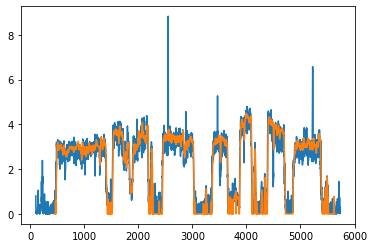

In [5]:
gps_data = pico_data['UBX0'].sort_index()
valid_gps_data = gps_data.loc[
    (gps_data.Hor_accuracy < 1000)
    & (gps_data.HDOP > 0)
    & (gps_data.HDOP < 5)
].copy()
valid_gps_data.index /= 1e6
times = pd.to_timedelta(valid_gps_data.UTC)
start_time = pd.to_timedelta(
    (times.dt.total_seconds() - times.index).mean(),
    unit='s'
)
valid_gps_data['latitude'] = valid_gps_data.Lat
valid_gps_data['longitude'] = valid_gps_data.Lon
valid_gps_data['distanceDelta'] = geodesy.haversine_km(
    valid_gps_data, valid_gps_data.shift()
).fillna(0)
valid_gps_data['distance'] = valid_gps_data.distanceDelta.cumsum()
valid_gps_data['timestamp'] = valid_gps_data.index 
valid_gps_data['timeDelta'] = valid_gps_data.timestamp.diff().fillna(0)

valid_gps_data['metrePerSecond'] = 1e3 * valid_gps_data.distanceDelta / valid_gps_data.timeDelta

start_date_time = pd.to_datetime(activity.time[0].date()) + start_time 
activity['timestamp'] = (activity.time - start_date_time).dt.total_seconds()

plt.plot(valid_gps_data.Speed_over_ground * 1000 / 3600)
plt.plot(activity.timestamp, activity.speed)

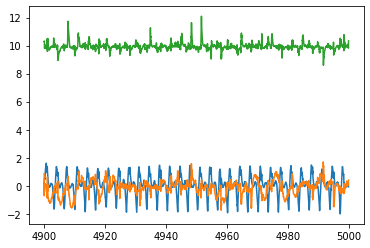

In [6]:
x, y, z = XYZ = dynamics.estimate_orientation(accel_data, gyro_data)

x *= -1

acc_scale = 9.81 / accel_data.dot(z).mean()
acc_scale

accel_orient = accel_data.dot(XYZ.T) * acc_scale
accel_orient.columns = accel_data.columns

plt.plot(
    accel_orient.loc[4900:5000].ewm(alpha=0.1).mean()
)

acc_x = accel_orient.accX

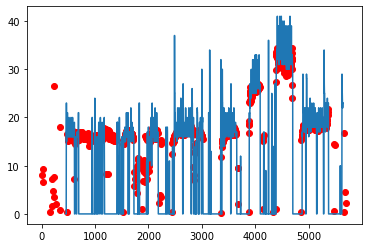

In [7]:
crossings = peaks.find_smoothed_crossings(acc_x.index, acc_x.values)
strokes = peaks.find_strokes(crossings, 0.3, 0.3)


plt.plot(activity.timestamp, activity.cadence)
plt.scatter(strokes.index, strokes.stroke_rate, c='r')

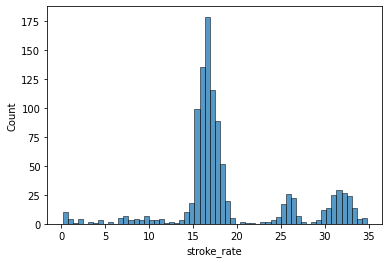

In [8]:
sns.histplot(
    strokes.stroke_rate,
)

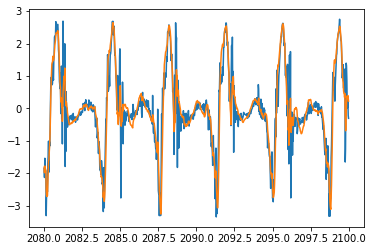

In [9]:
t0, t1 = 2080, 2100
times, acc = acc_x.loc[t0:t1].index.values, acc_x.loc[t0:t1].values 
rates = np.arange(1, 2, 1)
freqs = 2 * np.pi * rates / 60
n_harms = 50
harms = np.arange(1, n_harms + 1)

coefs = dynamics.exp_rolling_lombscargle(
    times, acc, freqs, n_harms, 1e-1
)
power = pd.DataFrame(
    np.square(coefs[:, 0, :]), 
    index=times, 
    # columns=rates
)

basis = jnp.concatenate(
    [
        jnp.ones(coefs.shape[:-1] + (1,)), 
        jnp.sin(times[:, None, None] * freqs[None, :, None] * harms[None, None, :]), 
        jnp.cos(times[:, None, None] * freqs[None, :, None] * harms[None, None, :]), 
    ], axis=-1
)
smoothed = (basis * coefs).sum(-1)

plt.plot(times, acc)
plt.plot(times, smoothed)

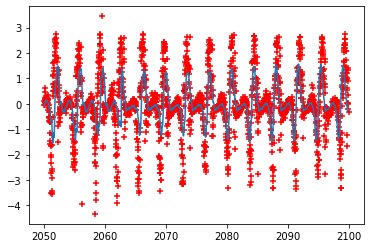

In [84]:
t0, t1 = 2000, 2100
times, acc = acc_x.loc[t0:t1].index.values, acc_x.loc[t0:t1].values 

rates = np.arange(1, 2, 1)
freqs = 2 * np.pi * rates / 60
n_harms = 50

rates = np.arange(10, 50, 0.5)
freqs = 2 * np.pi * rates / 60
n_harms = 15

coefs = dynamics.exp_rolling_lombscargle(
    times, acc, freqs, n_harms, 2e-2
)
power = pd.DataFrame(
    np.square(coefs[:, 0, :]), 
    index=times, 
    # columns=rates
)

harms = np.arange(1, n_harms + 1)
basis = jnp.concatenate(
    [
        jnp.ones(coefs.shape[:-1] + (1,)), 
        jnp.sin(times[:, None, None] * freqs[None, :, None] * harms[None, None, :]), 
        jnp.cos(times[:, None, None] * freqs[None, :, None] * harms[None, None, :]), 
    ], axis=-1
)
harm_weights = np.ones(2 * n_harms + 1) 
# harm_weights[-harms] = harm_weights[harms] = 1 / (1 + harms / 10) 

power = np.square(np.linalg.norm(coefs, axis=-1)) * 1000
weights = np.exp(power - power.max(-1, keepdims=True))
weights /= weights.sum(-1, keepdims=True)
smoothed = (
    basis * coefs * weights[..., None] * harm_weights[None, None, :]
).sum((-2, -1))

smooth_acc = pd.Series(smoothed, times)


# plt.plot(times, acc)
# plt.plot(times, smoothed)


plt.scatter(
    acc_x.loc[2050:2100].index, 
    acc_x.loc[2050:2100], 
    marker='+', c='r')
plt.plot(smooth_acc.loc[2050:2100])

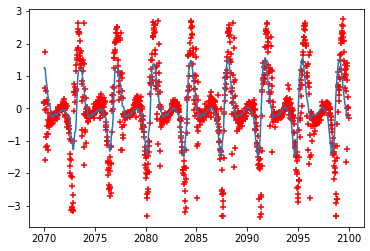

In [81]:

plt.scatter(
    acc_x.loc[2070:2100].index, 
    acc_x.loc[2070:2100], 
    marker='+', c='r')
plt.plot(smooth_acc.loc[2070:2100])

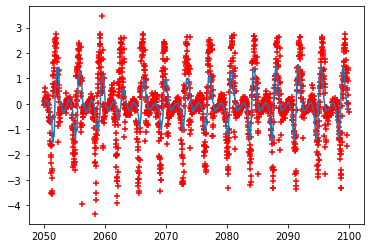

In [96]:
power = np.square(np.linalg.norm(coefs, axis=-1)) * 10
weights = np.exp(power - power.max(-1, keepdims=True))
weights /= weights.sum(-1, keepdims=True)
smoothed = (
    basis * coefs * weights[..., None] * harm_weights[None, None, :]
).sum((-2, -1))

smooth_acc = pd.Series(smoothed, times)

plt.scatter(
    acc_x.loc[2050:2100].index, 
    acc_x.loc[2050:2100], 
    marker='+', c='r')
plt.plot(smooth_acc.loc[2050:2100])

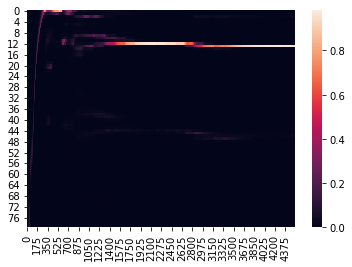

In [94]:
sns.heatmap(weights.T)

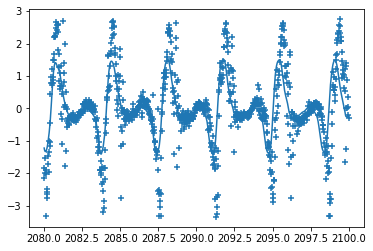

In [70]:
power = np.square(np.linalg.norm(coefs, axis=-1)) * 5000
weights = np.exp(power - power.max(-1, keepdims=True))
weights /= weights.sum(-1, keepdims=True)
smoothed = (basis * coefs * weights[..., None]).sum((-2, -1))

smooth_acc = pd.Series(smoothed, times)

plt.scatter(acc_x.loc[2080:2100].index, acc_x.loc[2080:2100], marker='+')
plt.plot(smooth_acc.loc[2080:2100])

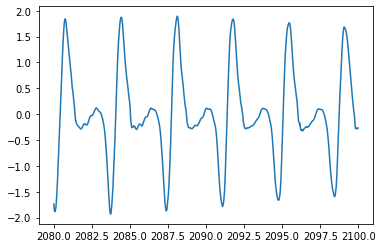

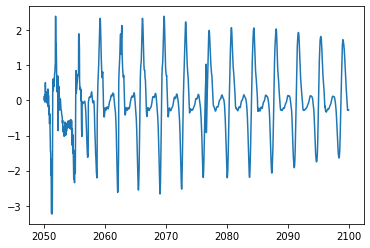

In [40]:

plt.plot(times, smoothed)

In [73]:
weight

array([[1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.0017338, 1.0016667, 1.0016013, ..., 1.0002948, 1.0003078,
        1.0003238],
       [1.0033981, 1.0033948, 1.0033915, ..., 1.0000625, 1.0000322,
        1.       ],
       ...,
       [3.3447847, 2.4504313, 1.5302149, ..., 2.5019317, 2.5583143,
        3.0564573],
       [3.3496027, 2.4517174, 1.5318459, ..., 2.5076337, 2.560763 ,
        3.0561268],
       [3.3554237, 2.4535005, 1.5335506, ..., 2.5132778, 2.562341 ,
        3.0559502]], dtype=float32)

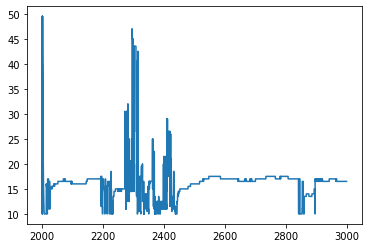

In [13]:
t0, t1 = 2000, 3000
times, acc = acc_x.loc[t0:t1].index.values, acc_x.loc[t0:t1].values 
rates = np.arange(10, 50, 0.5)
freqs = 2 * np.pi * rates / 60
n_harms = 10
coefs = dynamics.exp_rolling_lombscargle_cho(
    times, acc, freqs, n_harms, 1e-1
)
power = pd.DataFrame(
    np.linalg.norm(np.array(coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

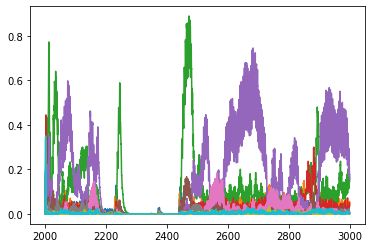

In [520]:
plt.plot(
    times, 
    amplitude[:, rates.searchsorted(8), :],
)

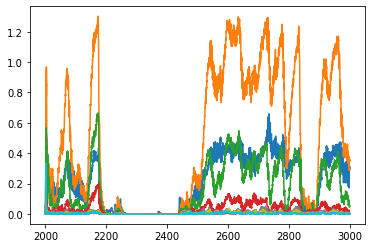

In [514]:
plt.plot(
    times, 
    amplitude[:, rates.searchsorted(17), :],
)

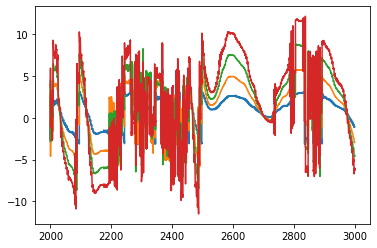

In [519]:
# plt.plot(
#     power.idxmax(1)
# )
plt.plot(
    times, 
    np.unwrap(
        phase[:, rates.searchsorted(17), :4],
        period=2 * np.pi 
    )
)
# plt.plot(
#     times, 
#     np.unwrap(
#         phase[:, rates.searchsorted(16.5), :],
#         period=2 * np.pi 
#     )
# )
# plt.plot(
#     times, phase[:, rates.searchsorted(16.5), :]
# )
# plt.plot(
#     times, 
#     phase[
#         np.arange(phase.shape[0]), 
#         np.linalg.norm(coefs[:, :, 1:], axis=-1).argmax(1),
#     ]
# )

In [484]:
phase[:, np.linalg.norm(coefs[:, :, 1:], axis=-1).argmax(1)]

MemoryError: Unable to allocate 23.0 GiB for an array with shape (45358, 45358, 3) and data type float32

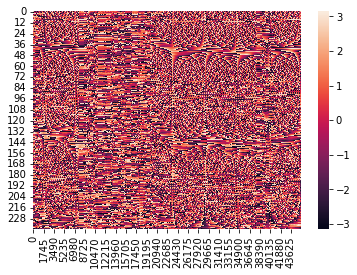

In [482]:
sns.heatmap(phase.reshape(45358, -1).T)

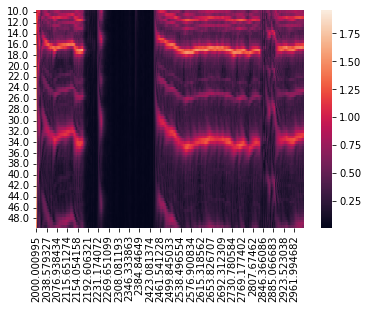

In [470]:
sns.heatmap(power.T)

In [468]:
t0, t1 = 2000, 3000
times, acc = acc_x.loc[t0:t1].index.values, acc_x.loc[t0:t1].values 
rates = np.arange(10, 50, 0.5)
freqs = 2 * np.pi * rates / 60
n_harms = 10
coefs = dynamics.exp_rolling_lombscargle(
    times, acc, freqs, n_harms, 1e-1
)
power = pd.DataFrame(
    np.linalg.norm(np.array(coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

KeyboardInterrupt: 

In [464]:
jax.scipy.linalg.cho_solve(
    
)

<function jax._src.scipy.linalg.cho_solve(c_and_lower, b, overwrite_b=False, check_finite=True)>

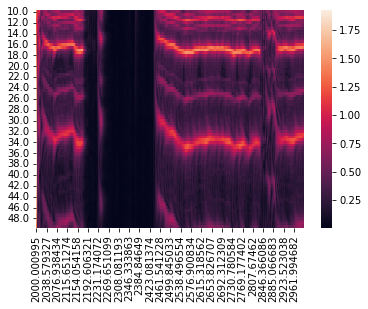

In [457]:
sns.heatmap(power.T)

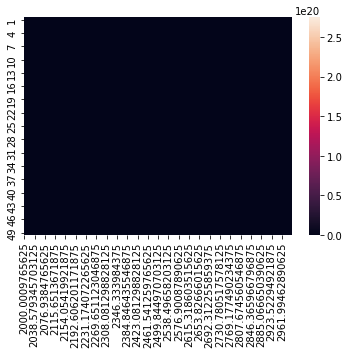

In [440]:

def rolling_fourier(carry, xt):
    AAT, Ax, x0, t0, freqs, alpha = carry

    n_freqs = len(freqs)
    t, x = xt
    dt = t - t0
    e1 = 1 - dt * alpha 
    AAT = AAT #* e1 
    Ax = Ax #* e1 

    a = jnp.r_[1, jnp.cos(freqs * t), jnp.sin(freqs[::-1] * t)]
    AAT1 = AAT * e1 + a[:, None] * a[None, :]
    Ax1 = Ax * e1 + a * x
    coefs = jnp.linalg.solve(AAT1, Ax1)
    return (AAT1, Ax1, x, t, freqs, alpha), coefs

k = np.arange(1, 50)
rates = k
periods = 60 / k
freqs =  2 * np.pi * rates / 60

t0, t1 = 2000, 3000
xt = jnp.c_[acc_x.loc[t0:t1].values, acc_x.loc[t0:t1].index.values]

AAT = jnp.eye(2 * periods.size + 1)
Ax = jnp.zeros(2 * periods.size + 1)

init = AAT, Ax, 0, 0, freqs, 1e-1

carry, coefs = rolling_fourier(init, xt[0])

carry, coefs = jax.lax.scan(
    rolling_fourier, init, xt
)
power = pd.DataFrame(
    (coefs[:, k]**2 + coefs[:, -k]**2),
    columns=rates, 
    index=xt[:, 1]
)

sns.heatmap(power.T)

In [439]:
coefs 

DeviceArray([[ 3.81789947e+00,  3.81772923e+00,  3.81711507e+00, ...,
               1.16731636e-01,  7.78282285e-02,  3.89155075e-02],
             [-3.18471827e-02, -3.50958705e-02, -4.48139049e-02, ...,
               1.94513237e+00,  1.29686558e+00,  6.48465574e-01],
             [-7.78269768e-02, -8.02089795e-02, -8.73323753e-02, ...,
               1.95689440e+00,  1.30466366e+00,  6.52351379e-01],
             ...,
             [-2.00383264e+03,  5.25703955e+03, -7.47053711e+03, ...,
              -2.37108887e+03, -8.08120938e+04,  1.44067344e+05],
             [-8.34985938e+03,  1.56944580e+04, -1.12812725e+04, ...,
              -7.07208789e+03, -1.02780398e+05,  1.56925531e+05],
             [-4.06285938e+04,  3.51162578e+04,  1.26091904e+04, ...,
               1.76482422e+05, -3.18830219e+05,  6.81702125e+05]],            dtype=float32)

In [435]:
power

1             2             3             4   \
2000.000977  3.645487e+00  3.645489e+00  3.645521e+00  3.645522e+00   
2000.022095  1.266185e+00  1.982704e+00  3.176808e+00  4.848396e+00   
2000.043213  1.425138e+00  2.148799e+00  3.354825e+00  5.043314e+00   
2000.067627  1.440212e+00  2.167388e+00  3.379300e+00  5.075999e+00   
2000.088745  1.887949e-01  6.507134e-01  1.420655e+00  2.498699e+00   
...                   ...           ...           ...           ...   
2999.894531  2.731103e+06  9.185517e+08  1.564061e+07  2.747943e+08   
2999.925049  3.551223e+10  1.394009e+09  5.726451e+08  7.265104e+09   
2999.946045  1.843659e+10  2.076441e+10  1.433333e+09  9.067974e+08   
2999.967285  7.493314e+09  1.888539e+08  1.630946e+09  2.420361e+08   
2999.988281  8.268227e+07  2.898164e+07  9.603024e+07  6.548128e+07   

                       5             6             7             8   \
2000.000977  3.645498e+00  3.645502e+00  3.645489e+00  3.645490e+00   
2000.022095  6.997233e+00  9.623108e+00  1.272582e+01  1.630489e+01   
2000.043213  7.214171e+00  9.867353e+00  1.300293e+01  1.662069e+01   
2000.067627  7.257415e+00  9.923562e+00  1.307437e+01  1.670977e+01   
2000.088745  3.884994e+00  5.579710e+00  7.583066e+00  9.895361e+00   
...                   ...           ...           ...           ...   
2999.894531  6.015744e+07  9.547033e+07  1.010464e+08  1.433173e+08   
2999.925049  4.912863e+09  1.239817e+09  1.318639e+09  7.546372e+09   
2999.946045  8.680462e+09  4.664173e+08  2.982494e+07  6.868061e+09   
2999.967285  1.972666e+08  5.635396e+08  2.514381e+09  1.325179e+09   
2999.988281  3.675590e+07  5.857270e+07  1.195471e+08  1.239929e+08   

                       9             10  ...            40            41  \
2000.000977  3.645515e+00  3.645516e+00  ...  3.645541e+00  3.645499e+00   
2000.022095  2.036004e+01  2.489090e+01  ...  3.777181e+02  3.964990e+02   
2000.043213  2.072085e+01  2.530313e+01  ...  3.864980e+02  4.059710e+02   
2000.067627  2.082988e+01  2.543447e+01  ...  3.883835e+02  4.079503e+02   
2000.088745  1.251679e+01  1.544779e+01  ...  2.505396e+02  2.634403e+02   
...                   ...           ...  ...           ...           ...   
2999.894531  4.506976e+07  1.337497e+08  ...  3.864774e+08  2.464851e+06   
2999.925049  1.283566e+08  1.652692e+08  ...  1.674742e+09  9.842429e+07   
2999.946045  1.410010e+10  3.943922e+09  ...  1.564384e+09  1.792607e+08   
2999.967285  1.085064e+09  1.993522e+08  ...  2.213121e+08  3.311479e+08   
2999.988281  2.206250e+08  3.512782e+07  ...  3.910539e+07  3.715552e+07   

                       42            43            44            45  \
2000.000977  3.645457e+00  3.645548e+00  3.645517e+00  3.645525e+00   
2000.022095  4.157145e+02  4.353634e+02  4.554431e+02  4.759508e+02   
2000.043213  4.259204e+02  4.463481e+02  4.672521e+02  4.886332e+02   
2000.067627  4.279966e+02  4.485226e+02  4.695278e+02  4.910117e+02   
2000.088745  2.766813e+02  2.902635e+02  3.041895e+02  3.184608e+02   
...                   ...           ...           ...           ...   
2999.894531  8.928550e+07  3.670563e+08  6.076820e+07  6.659193e+07   
2999.925049  1.377559e+09  9.721234e+06  4.776849e+08  2.624786e+09   
2999.946045  4.801580e+09  8.114682e+07  8.879985e+09  7.557324e+09   
2999.967285  1.436175e+08  4.620610e+08  3.482412e+08  2.985084e+08   
2999.988281  7.416811e+07  7.652029e+07  2.184350e+08  1.320913e+07   

                       46            47            48            49  
2000.000977  3.645500e+00  3.645562e+00  3.645472e+00  3.645411e+00  
2000.022095  4.968859e+02  5.182446e+02  5.400260e+02  5.622256e+02  
2000.043213  5.104899e+02  5.328226e+02  5.556320e+02  5.789169e+02  
2000.067627  5.129747e+02  5.354152e+02  5.583349e+02  5.817319e+02  
2000.088745  3.330779e+02  3.480441e+02  3.633602e+02  3.790276e+02  
...                   ...           ...           ...           ...  
2999.894531  1.907770e+08  1.625846e+08  1.226423e+07  6.6005

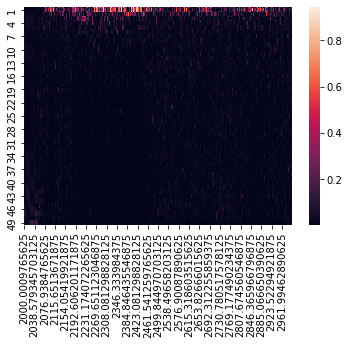

In [434]:
sns.heatmap((power / power.values.sum(1, keepdims=True)).T)

In [431]:
power

1             2             3             4   \
2000.000977  3.645487e+00  3.645489e+00  3.645521e+00  3.645522e+00   
2000.022095  1.266185e+00  1.982704e+00  3.176808e+00  4.848396e+00   
2000.043213  1.425138e+00  2.148799e+00  3.354825e+00  5.043314e+00   
2000.067627  1.440212e+00  2.167388e+00  3.379300e+00  5.075999e+00   
2000.088745  1.887949e-01  6.507134e-01  1.420655e+00  2.498699e+00   
...                   ...           ...           ...           ...   
2999.894531  2.731103e+06  9.185517e+08  1.564061e+07  2.747943e+08   
2999.925049  3.551223e+10  1.394009e+09  5.726451e+08  7.265104e+09   
2999.946045  1.843659e+10  2.076441e+10  1.433333e+09  9.067974e+08   
2999.967285  7.493314e+09  1.888539e+08  1.630946e+09  2.420361e+08   
2999.988281  8.268227e+07  2.898164e+07  9.603024e+07  6.548128e+07   

                       5             6             7             8   \
2000.000977  3.645498e+00  3.645502e+00  3.645489e+00  3.645490e+00   
2000.022095  6.997233e+00  9.623108e+00  1.272582e+01  1.630489e+01   
2000.043213  7.214171e+00  9.867353e+00  1.300293e+01  1.662069e+01   
2000.067627  7.257415e+00  9.923562e+00  1.307437e+01  1.670977e+01   
2000.088745  3.884994e+00  5.579710e+00  7.583066e+00  9.895361e+00   
...                   ...           ...           ...           ...   
2999.894531  6.015744e+07  9.547033e+07  1.010464e+08  1.433173e+08   
2999.925049  4.912863e+09  1.239817e+09  1.318639e+09  7.546372e+09   
2999.946045  8.680462e+09  4.664173e+08  2.982494e+07  6.868061e+09   
2999.967285  1.972666e+08  5.635396e+08  2.514381e+09  1.325179e+09   
2999.988281  3.675590e+07  5.857270e+07  1.195471e+08  1.239929e+08   

                       9             10  ...            40            41  \
2000.000977  3.645515e+00  3.645516e+00  ...  3.645541e+00  3.645499e+00   
2000.022095  2.036004e+01  2.489090e+01  ...  3.777181e+02  3.964990e+02   
2000.043213  2.072085e+01  2.530313e+01  ...  3.864980e+02  4.059710e+02   
2000.067627  2.082988e+01  2.543447e+01  ...  3.883835e+02  4.079503e+02   
2000.088745  1.251679e+01  1.544779e+01  ...  2.505396e+02  2.634403e+02   
...                   ...           ...  ...           ...           ...   
2999.894531  4.506976e+07  1.337497e+08  ...  3.864774e+08  2.464851e+06   
2999.925049  1.283566e+08  1.652692e+08  ...  1.674742e+09  9.842429e+07   
2999.946045  1.410010e+10  3.943922e+09  ...  1.564384e+09  1.792607e+08   
2999.967285  1.085064e+09  1.993522e+08  ...  2.213121e+08  3.311479e+08   
2999.988281  2.206250e+08  3.512782e+07  ...  3.910539e+07  3.715552e+07   

                       42            43            44            45  \
2000.000977  3.645457e+00  3.645548e+00  3.645517e+00  3.645525e+00   
2000.022095  4.157145e+02  4.353634e+02  4.554431e+02  4.759508e+02   
2000.043213  4.259204e+02  4.463481e+02  4.672521e+02  4.886332e+02   
2000.067627  4.279966e+02  4.485226e+02  4.695278e+02  4.910117e+02   
2000.088745  2.766813e+02  2.902635e+02  3.041895e+02  3.184608e+02   
...                   ...           ...           ...           ...   
2999.894531  8.928550e+07  3.670563e+08  6.076820e+07  6.659193e+07   
2999.925049  1.377559e+09  9.721234e+06  4.776849e+08  2.624786e+09   
2999.946045  4.801580e+09  8.114682e+07  8.879985e+09  7.557324e+09   
2999.967285  1.436175e+08  4.620610e+08  3.482412e+08  2.985084e+08   
2999.988281  7.416811e+07  7.652029e+07  2.184350e+08  1.320913e+07   

                       46            47            48            49  
2000.000977  3.645500e+00  3.645562e+00  3.645472e+00  3.645411e+00  
2000.022095  4.968859e+02  5.182446e+02  5.400260e+02  5.622256e+02  
2000.043213  5.104899e+02  5.328226e+02  5.556320e+02  5.789169e+02  
2000.067627  5.129747e+02  5.354152e+02  5.583349e+02  5.817319e+02  
2000.088745  3.330779e+02  3.480441e+02  3.633602e+02  3.790276e+02  
...                   ...           ...           ...           ...  
2999.894531  1.907770e+08  1.625846e+08  1.226423e+07  6.6005

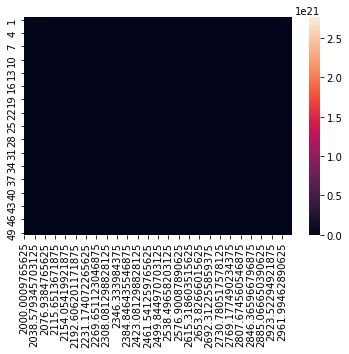

In [430]:
sns.heatmap(power.T)

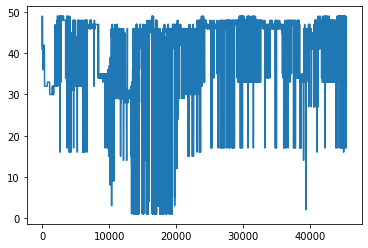

In [418]:
plt.plot(rates[(coefs[:, k]**2 + coefs[:, -k]**2).argmax(1)])

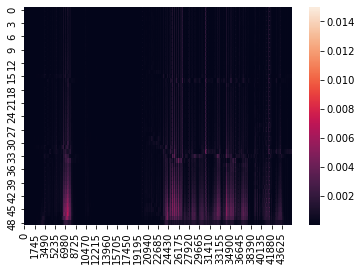

In [419]:
sns.heatmap(.T)

In [7]:
fit_strokes = strokes[
    (strokes.stroke_rate > 10)
].sort_values("stroke_rate")

In [263]:
stroke = fit_strokes.iloc[0]
stroke 

a                  1.245494
v                152.135086
smooth             0.087977
smooth_v         150.025452
var_smooth_a       1.064976
sgn_chg            1.000000
DeltaV            -0.769791
stroke_end      1787.187957
stroke_start    1781.192499
stroke_time        5.995458
stroke_rate       10.007576
Name: 1787.360218, dtype: float64

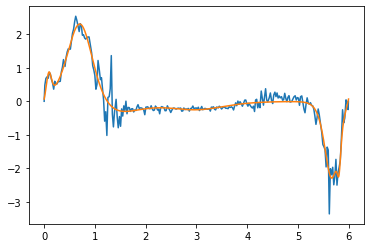

In [306]:
stroke = fit_strokes.iloc[0]

s = np.s_[stroke.stroke_start:stroke.stroke_end]

i0, j0 = acc_x.index.searchsorted([stroke.stroke_start, stroke.stroke_end])
s0, s1, e0, e1 = acc_x.index[[i0, i0 + 1, j0, j0 + 1]] 
t0 = s0 - acc_x[s0] * (s1 - s0) / (acc_x[s1] - acc_x[s0])
t1 = e0 - acc_x[e0] * (e1 - e0) / (acc_x[e1] - acc_x[e0])
stroke_profile = pd.Series(
    np.r_[0, acc_x.loc[s1:e0], 0],  
    np.r_[t0, acc_x.index[i0 + 1:j0 + 1], t1] - t0
)

t1 = stroke.stroke_time
t = np.linspace(0, t1, 1000)

peak_times = np.r_[
    0.05, 0.8, 
    (t1 - 0.7) * 0.3 + 0.4, (t1 - 0.7) * 0.6 + 0.4, 
    t1 - 0.4, t1 - 0.2
]
peaks = stroke_profile.index[
    stroke_profile.index.searchsorted(peak_times)
]
p0 = np.c_[
    stroke_profile.loc[peaks], 
    peaks, 
    np.full_like(peaks, -3)
]

_, popt, pcov = profile.fit_stroke_profile(
    stroke, acc_x, peak_times=peak_times)

stroke_params = {stroke.name: popt}
stroke_cov = {stroke.name: pcov}

plt.plot(stroke_profile)
plt.plot(t, profile.logistics(t, *popt, box=t1))

In [318]:
np.arange(1, n_basis)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,
        2,  1])

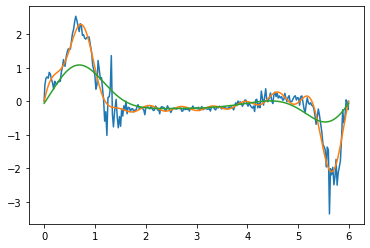

In [367]:
t1 = stroke_profile.index[-1] - stroke_profile[0]
t = np.array(stroke_profile.index) 
y = stroke_profile.values 

n_basis = 10
n = np.arange(n_basis)
k = np.roll(np.arange(1 - n_basis, n_basis), n_basis)
z = t[:, None] / t1
# X = special.eval_sh_legendre(n[None, :], z) * np.sqrt(2 * n + 1)

X = np.c_[
    np.cos(2 * np.pi * np.arange(n_basis)[None, :] * t[:, None] / t1),
    np.sin(2 * np.pi * np.arange(n_basis - 1, 0, - 1)[None, :] * t[:, None] / t1)
] * np.sqrt(2)

coefs = integrate.trapz(
    X * y[:, None], t / t1, axis=0
) 
plt.plot(t, y)
plt.plot(t, X.dot(coefs))
plt.plot(t, X.dot(coefs * np.exp(-k**2/10)))

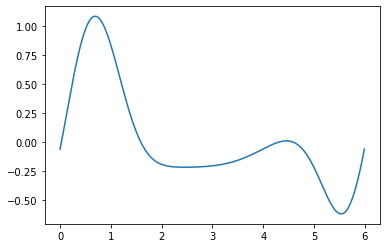

In [368]:
plt.plot(t, X.dot(coefs * np.exp(-k**2/10)))

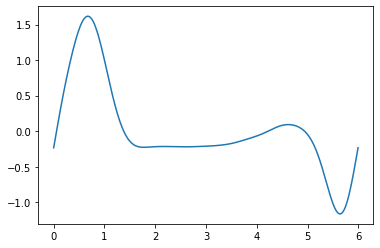

In [324]:
plt.plot(t, X.dot(coefs.pn * ))

array([[ 1.41421356e+00,  1.41421356e+00,  1.41421356e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.41421356e+00,  1.41408054e+00,  1.41368151e+00, ...,
         5.81742001e-02,  3.87888808e-02,  1.93962648e-02],
       [ 1.41421356e+00,  1.41330343e+00,  1.41057420e+00, ...,
         1.51925518e-01,  1.01392446e-01,  5.07288703e-02],
       ...,
       [ 1.41421356e+00,  1.41367968e+00,  1.41207842e+00, ...,
        -1.16450076e-01, -7.76822647e-02, -3.88558010e-02],
       [ 1.41421356e+00,  1.41419178e+00,  1.41412642e+00, ...,
        -2.35487621e-02, -1.56995778e-02, -7.84990984e-03],
       [ 1.41421356e+00,  1.41421356e+00,  1.41421356e+00, ...,
        -1.03914727e-15, -6.92764845e-16, -3.46382422e-16]])

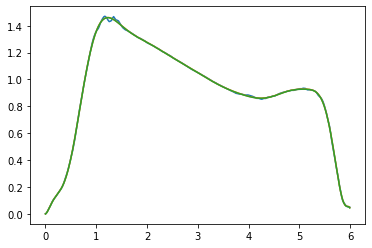

In [309]:
t1 = stroke_profile.index[-1] - stroke_profile[0]

v_profile = utils.integrate_series(stroke_profile)
t = np.array(v_profile.index) 
y = v_profile.values 


n_basis = 20
n = np.arange(n_basis)
z = t[:, None] / t1
X = special.eval_sh_legendre(n[None, :], z)

Xp = np.zeros_like(X)
Xp[:, 1:] = (2 * n[None, 1:] / t1) * X[:, :-1]
for i in range(1, n_basis):
    Xp[:, i] += (2 * z[:, 0] - 1) * Xp[:, i - 1]

Xp2 = np.zeros_like(X)
Xp2[:, 1:] = (2 / t1 * (n[None, 1:] + 1)) * Xp[:, :-1]
for i in range(1, n_basis):
    Xp2[:, i] += (2 * z[:, 0] - 1) * Xp2[:, i - 1]

coefs = integrate.trapz(
    X * y[:, None],
    t / t1, 
    axis=0
) * (2 * n + 1)

plt.plot(t, y)
plt.plot(t, X.dot(coefs))
plt.plot(t, integrate.cumtrapz(Xp.dot(coefs), t, initial=0))

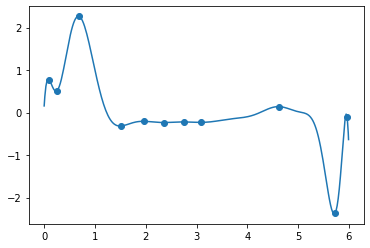

In [310]:
plt.plot(t, Xp.dot(coefs))
# plt.plot(t, Xp2.dot(coefs))

maxima = np.r_[False, np.diff(np.sign(Xp2.dot(coefs))) != 0]
plt.scatter(t[maxima], Xp.dot(coefs)[maxima])

In [9]:
from scipy import special 

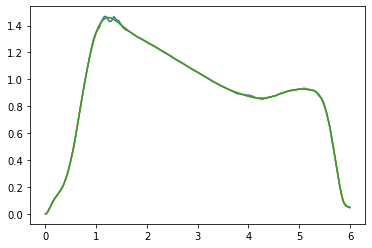

In [250]:
v_profile = utils.integrate_series(stroke_profile)
t = np.array(v_profile.index) 
y = v_profile.values

# t = np.array(stroke_profile.index) 
# y = stroke_profile.values

n_basis = 20
n = np.arange(n_basis)
z = t[:, None] / t1
X = special.eval_sh_legendre(n[None, :], z)

Xp = np.zeros_like(X)
Xp[:, 1:] = (2 * n[None, 1:] / t1) * X[:, :-1]
for i in range(1, n_basis):
    Xp[:, i] += (2 * z[:, 0] - 1) * Xp[:, i - 1]

Xp2 = np.zeros_like(X)
Xp2[:, 1:] = (2 / t1 * (n[None, 1:] + 1)) * Xp[:, :-1]
for i in range(1, n_basis):
    Xp2[:, i] += (2 * z[:, 0] - 1) * Xp2[:, i - 1]

coefs = integrate.trapz(
    X * y[:, None],
    t / t1, 
    axis=0
) * (2 * n + 1)

plt.plot(t, y)
plt.plot(t, X.dot(coefs))
plt.plot(t, integrate.cumtrapz(Xp.dot(coefs), t, initial=0))

In [259]:
t[maxima]

array([0.109105, 0.258542, 0.698052, 1.513037, 1.969126, 2.368013,
       2.759823, 3.090583, 4.637645, 5.734029, 5.974544])

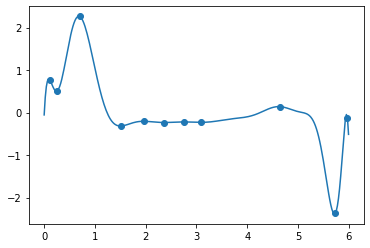

In [262]:
plt.plot(t, Xp.dot(coefs))
# plt.plot(t, Xp2.dot(coefs))

maxima = np.r_[False, np.diff(np.sign(Xp2.dot(coefs))) != 0]
plt.scatter(t[maxima], Xp.dot(coefs)[maxima])

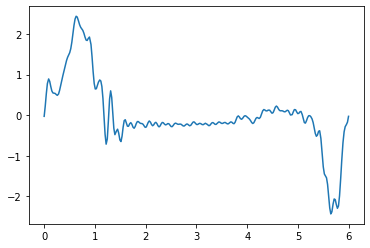

In [69]:
n_basis = 50
X = np.c_[
    np.cos(2 * np.pi * np.arange(n_basis)[None, :] * t[:, None] / t1),
    np.sin(2 * np.pi * np.arange(1, n_basis)[None, :] * t[:, None] / t1)
]
coefs = integrate.trapz(
    X * stroke_profile.values[:, None],
    t, 
    axis=0
)
coefs, *_ = np.linalg.lstsq(X, stroke_profile.values, rcond=True)

plt.plot(t, X.dot(coefs))

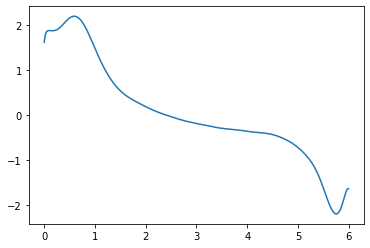

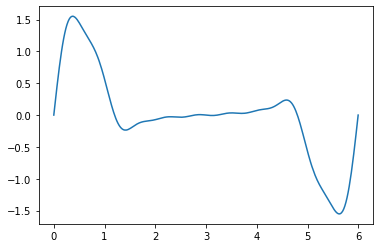

In [32]:
X = np.sin(2 * np.pi * np.arange(10)[None, :] * t[:, None] / t1)
coefs, *_ = np.linalg.lstsq(X, stroke_profile.values, rcond=True)
plt.plot(t, X.dot(coefs))

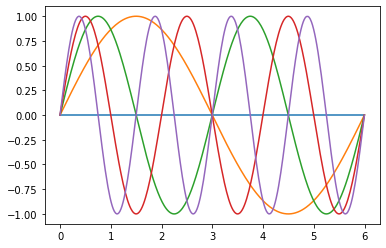

In [30]:
plt.plot(t, )

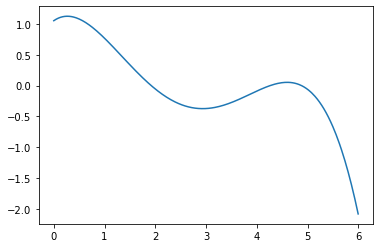

In [ ]:
n_basis = 5
t = np.array(stroke_profile.index)
X = np.concatenate([special])

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


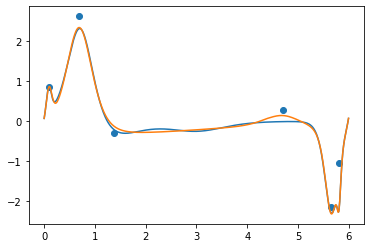

In [197]:
p1 = popt.copy()
p1[10] = 5
p1[9] = 0.1
p1[11] = 0.

stroke_profile, p1, p1cov = profile.fit_stroke_profile(
    stroke, acc_x, p0=p1)

# plt.plot(stroke_profile)
plt.plot(t, profile.observe_logistic(popt, t, box=t1))

plt.plot(t, profile.observe_logistic(p1, t, box=t1))
As, ms, logs = p1.reshape(-1, 3).T
plt.scatter(ms, As)

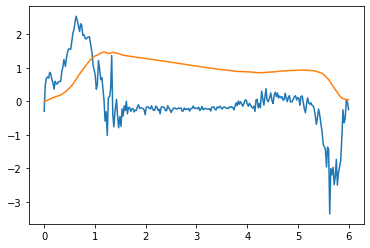

In [210]:
stroke_profile
vel_profile = utils.integrate_series(stroke_profile)
plt.plot(stroke_profile)
plt.plot(vel_profile)

In [244]:
def fit_cummax(data, logistic_thresh=1.):
    cmax = data.cummax()
    A0 = cmax.iloc[-1]
    logistic = np.log(cmax/A0) - np.log1p(-cmax/A0)
    lfit = logistic[logistic.abs() < logistic_thresh]
    a0, a1 = np.linalg.lstsq(np.c_[np.ones_like(lfit), lfit.index], lfit.values, rcond=-1)[0]

    return np.r_[A0 * a1 / 4, -a0/a1, -np.log(a1)]

In [283]:
stroke_profile
vel_profile = utils.integrate_series(stroke_profile)

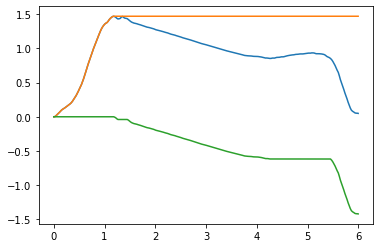

In [312]:
y = vel_profile.copy()
plt.plot(y)

for i in range(1):
    cmax = y.cummax()
    y = y - cmax
    plt.plot(cmax)

    cmin = y.cummin()
    y = y - cmin
    plt.plot(cmin)

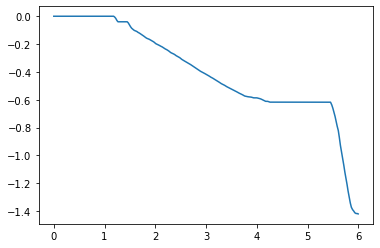

In [318]:
plt.plot((vel_profile - cmax).cummin())

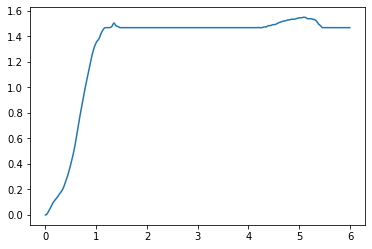

In [316]:
plt.plot(vel_profile - cmin)

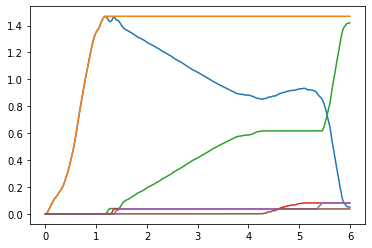

In [304]:
y = vel_profile.copy()
plt.plot(y)

for i in range(5):
    cmax = y.cummax()
    y = cmax - y
    # plt.plot(y)
    plt.plot(cmax)

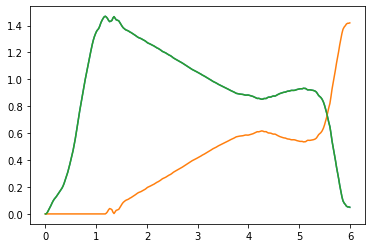

In [298]:
data = vel_profile.copy()

cmax = data.cummax() 
cmin = data.cummin() 

plt.plot(data)
plt.plot(cmax - data)
plt.plot(data - cmin)

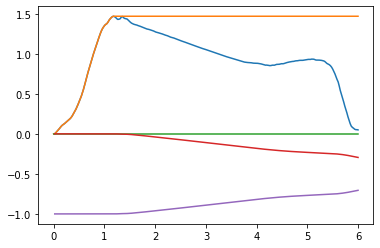

In [286]:
data = vel_profile.copy()

cmax = data.cummax() 
cmin = data.cummin() 

plt.plot(data)
plt.plot(cmax)
plt.plot(cmin)
plt.plot(utils.integrate_series(data - cmax) / utils.integrate_series(cmax - cmin))
plt.plot(utils.integrate_series(cmin - data) / utils.integrate_series(cmax - cmin))

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


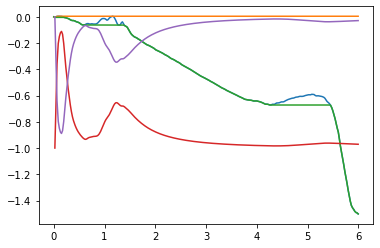

In [287]:
A, m, logt = p = fit_cummax(data)
log1 = profile.logistics_1(t, A, m, logt, box=t1)
data -= log1

A, m, logt = p = fit_cummax(data)
log1 = profile.logistics_1(t, A, m, logt, box=t1)
data -= log1

cmax = data.cummax() 
cmin = data.cummin() 

plt.plot(data)
plt.plot(cmax)
plt.plot(cmin)
plt.plot(utils.integrate_series(data - cmax) / utils.integrate_series(cmax - cmin))
plt.plot(utils.integrate_series(cmin - data) / utils.integrate_series(cmax - cmin))

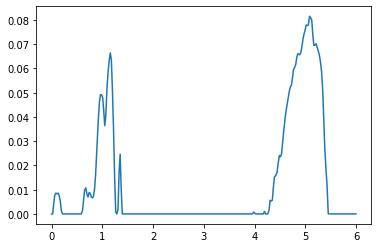

In [297]:
plt.plot(data - cmin)

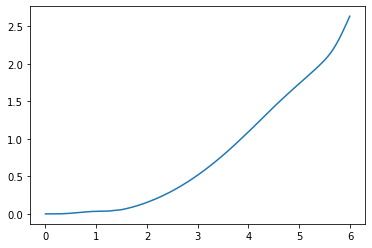

In [295]:
plt.plot(utils.integrate_series(cmax - data))

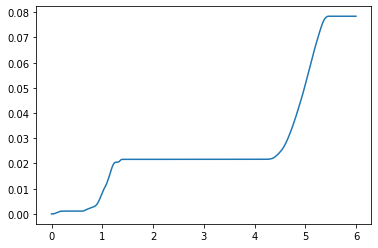

In [296]:
plt.plot(utils.integrate_series(data - cmin))

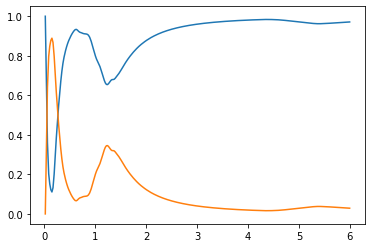

In [290]:
plt.plot(utils.integrate_series(cmax - data) / utils.integrate_series(cmax - cmin))
plt.plot(utils.integrate_series(data - cmin) / utils.integrate_series(cmax - cmin))

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


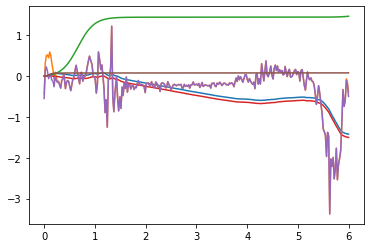

In [264]:
prof = stroke_profile.copy()
data = vel_profile.copy()
t = data.index 

for i in range(2):
    A, m, logt = p = fit_cummax(data)
    log1 = profile.logistics_1(t, A, m, logt, box=t1)
    data -= log1
    prof -= profile.logistics(t, A, m, logt, box=t1)
    plt.plot(data)
    plt.plot(prof)
    plt.plot(t, log1)

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(2.2960571473531997, 0.6633464521818335, -1.8329935677191063)

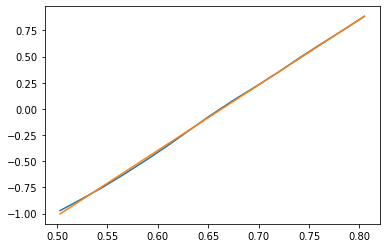

In [243]:
cmax = vel_profile.cummax()
A0 = cmax.iloc[-1]
logistic = np.log(cmax/A0) - np.log1p(-cmax/A0)
lfit = logistic[logistic.abs() < 1]
a0, a1 = np.linalg.lstsq(np.c_[np.ones_like(lfit), lfit.index], lfit.values, rcond=-1)[0]
plt.plot(lfit)
plt.plot(lfit.index, lfit.index * a1  + a0)

A, m, logt = p = np.r_[A0 * a1 / 4, -a0/a1, -np.log(a1)]
A, m, logt

(-4.000507660257247, 6.109600585416424)

In [229]:
1/m, - c/m 

(0.163676820770738, 0.6547903752998898)

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


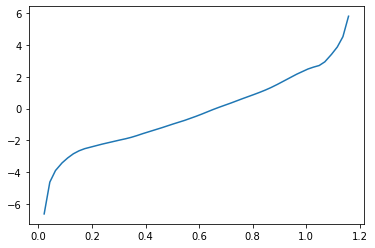

In [218]:
plt.plot(np.log(cmax/cmax.iloc[-1]) - np.log1p(-cmax/cmax.max()))

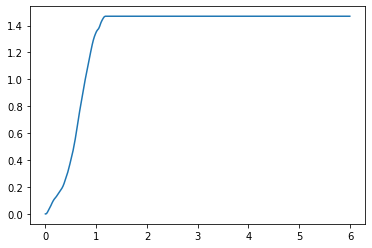

In [212]:
plt.plot(vel_profile.cummax())

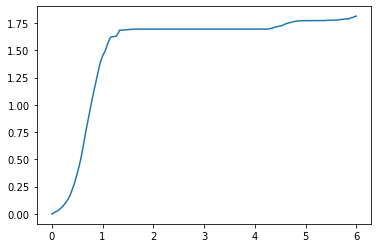

In [186]:
def _cir(x, y, wt=None, interiorStrict=True, strict=False, ybounds=None, full=False):
    x0, y0 = x, y 
    x = np.asarray(x0)
    y = np.asarray(y0)
    weight = np.ones_like(y) if wt is None else np.asarray(wt)

    
    if ybounds is None:
        ybounds = np.asarray([0.0,1.0])
    
    m = len(y)
    while True:
        viol = np.diff(y) < 0
        # This option (default True) makes sure 0s and 1s are not swept into
        # The shrinkage (in case of binary/binomial observations)
        if interiorStrict:
            equals = np.diff(y) == 0
            for i in range(0,m-1):
                if y[i] in ybounds and y[i+1] in ybounds:
                    equals[i] = False
            viol = (viol | equals)

        # strict flag overrides interior-strict nuance
        if strict:
            viol = np.diff(y)<=0
            
        if not(any(viol)):
            break

        i = np.min(np.where(viol==True))
        y[i] = (y[i]*weight[i] + y[i+1]*weight[i+1]) / (weight[i] + weight[i+1])
        x[i] = (x[i]*weight[i] + x[i+1]*weight[i+1]) / (weight[i] + weight[i+1])
        weight[i] = weight[i] + weight[i+1]

        x = np.r_[x[:i], x[i+1:]] 
        y = np.r_[y[:i], y[i+1:]] 
        weight = np.r_[weight[:i], weight[i+1:]] 
        m -= 1
        if m <= 1:
            break

    return np.interp(x=x0, xp=x, fp=y)

x = np.array(data.index) 
y = np.array(data.values)

yir = _cir(x, y)
plt.plot(x, yir)

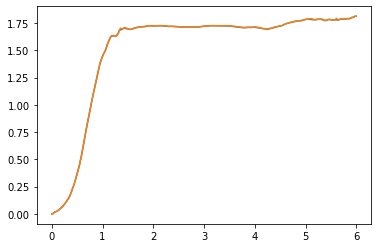

In [194]:
def _cir(x, y, wt=None, interiorStrict=True, strict=False, ybounds=None, full=False):
    
    if ybounds is None:
        ybounds = np.asarray([0.0,1.0])

    x0, y0 = x, y 
    x = np.asarray(x0)
    y = np.asarray(y0)
    weight = np.ones_like(y) if wt is None else np.asarray(wt)
    
    m = len(y)

    viol = np.diff(y) < 0
    
    if interiorStrict:
        equals = np.diff(y) == 0
        i = np.arange(m - 1)
        equals[i] |= np.in1d(y[i], ybounds) & np.in1d(y[i + 1], ybounds)
        viol = (viol | equals)

    # strict flag overrides interior-strict nuance
    if strict:
        viol = np.diff(y) <= 0
    
    while True:            
        if not(any(viol)):
            break

        i = np.min(np.where(viol==True))
        y[i] = (y[i]*weight[i] + y[i+1]*weight[i+1]) / (weight[i] + weight[i+1])
        x[i] = (x[i]*weight[i] + x[i+1]*weight[i+1]) / (weight[i] + weight[i+1])
        weight[i] = weight[i] + weight[i+1]

        x = np.r_[x[:i], x[i+1:]] 
        y = np.r_[y[:i], y[i+1:]] 
        weight = np.r_[weight[:i], weight[i+1:]] 
        viol = np.r_[viol[:i], viol[i+1:]] 
        m -= 1
        if m <= 1:
            break
        
        viol[i] = y[i + 1] < y[i]
        if interiorStrict:
            viol[i] |= y[i] == y[i + 1] or (y[i] in ybounds and y[i + 1] in ybounds)
        if strict:
            viol[i] = y[i + 1] <= y[i]

    return np.interp(x=x0, xp=x, fp=y)

x = np.array(data.index) 
y = np.array(data.values)

yir = _cir(x, y)
plt.plot(x, yir)
plt.plot(x, y)

In [150]:
def cirPAVA(y, x=None, wt=None, outx=None, interiorStrict=True, strict=False, ybounds=None, full=False, dec=False):
    """
    Perform regression.
    Args:
        x,y,wt: vectors of equal length with the doses, mean y values (usually response rates in [0,1]), and weights (often sample size)
        outx: ...
    """
    if ybounds is None:
        ybounds = np.asarray([0.0,1.0])

    y = np.asarray(y)
    if y.ndim != 1:
        raise Exception(f'You supplied an array with {y.ndim} dimensions, but must be a vector (i.e. 1 dimension)')

    m = len(y)
    dr = pd.DataFrame(data={'x':x,'y':y, 'weight':wt})
#    if (m <= 1):  ## degenerate case: only one dose level
#        if (not(full)): return (dr.y)
#        return(['output':dr,'input':dr,'shrinkage':dr])

    if outx is None:
        outx = dr.x
    else:
        outx = np.asarray(outx)

    dr0 = dr.copy()
    if dec:
        dr.loc['y'] = -dr.y

    while True:
        viol = np.diff(dr.y)<0
        # This option (default True) makes sure 0s and 1s are not swept into
        # The shrinkage (in case of binary/binomial observations)
        if interiorStrict:
            equals = np.diff(dr.y)==0
            for i in range(0,m-1):
                if dr.y[i] in ybounds and dr.y[i+1] in ybounds:
                    equals[i] = False
            viol = (viol | equals)

        # strict flag overrides interior-strict nuance
        if strict:
            viol = np.diff(dr.y)<=0
 #       print(viol)
        if not(any(viol)):
            break

        i = np.min(np.where(viol==True))
 #       print(i)
 #       print(dr)
        dr.loc[i,'y'] = (dr.y[i]*dr.weight[i]+dr.y[i+1]*dr.weight[i+1]) / (dr.weight[i]+dr.weight[i+1])
        dr.loc[i,'x'] = (dr.x[i]*dr.weight[i]+dr.x[i+1]*dr.weight[i+1]) / (dr.weight[i]+dr.weight[i+1])
        dr.loc[i,'weight'] = dr.weight[i]+dr.weight[i+1]
        dr = dr.drop(i+1).reset_index(drop=True)
        m -= 1
        if m <= 1:
            break

    # extending back to original boundaries if needed
    if dr.x[0]>dr0.x[0]:
        dr = dr0.head(1).append(dr,ignore_index=True).copy()
        dr.loc[0,'y']=dr.y[1]
        dr.loc[0,'weight']=0 # The weight is spoken for though
    if max(dr.x)<max(dr0.x):
        dr = dr.append(dr0.tail(1),ignore_index=True).copy()
        dr.loc[dr.x==max(dr.x),'weight'] = 0 # The weight is spoken for though
        dr.loc[dr.x==max(dr.x),'y'] = max(dr.y)

    # Finish up
    outy = np.interp(x=outx, xp=dr.x, fp=dr.y)
    if not full:
        return(outy)

    # Full-ass return
    else:
        inx = np.repeat(False, len(outx))
        for i in range(len(outx)-1):
            inx[i] = (outx[i] in dr0.x)

        if all(inx):
            drout = dr0
            drout.y = outy
        else:
            drout = pd.DataFrame(data={ 'x':outx,'y':outy, 'weight':0})

        output = {'output':drout,'input':dr0,'shrinkage':dr}
        return output

In [203]:
y_iso = cirPAVA(cdf.values, cdf.index, np.ones_like(cdf))

/tmp/ipykernel_10467/1813261886.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dr = dr.append(dr0.tail(1),ignore_index=True).copy()


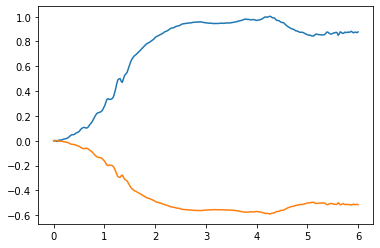

In [199]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = popt

for n in range(2, len(popt)//3):
    i0, i1 = n * 3, n * 3 + 3
    cdf_diff = (
        stroke_profile
        - profile.logistics(stroke_profile.index, *p[:i0], box=t1)
        - profile.logistics(stroke_profile.index, *p[i1:], box=t1)
    )
    A, m, logs = p[i0:i1]
    A0 = A * np.exp(logs) * 4
    t = stroke_profile.index
    # mod_pdf = cdf_diff * profile.logistics(stroke_profile.index, 1 / A0, m, logs, box=t1) 
    plt.plot(
        utils.integrate_series(cdf_diff) / A0
        # / A0
    )
    break 
    # break 

cdf = utils.integrate_series(cdf_diff)
plt.plot(cdf)

In [169]:
cirPAVA(data.values)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [155]:
y_iso = cirPAVA(data.values, data.index, wt=profile.logistics(stroke_profile.index, 1, m, logs, box=t1))

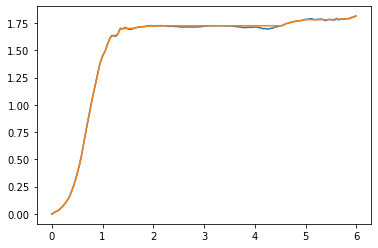

In [156]:
data = utils.integrate_series(cdf_diff)
plt.plot(data)
plt.plot(data.index, y_iso)

In [159]:
y_iso[100]

1.723978956959459

/tmp/ipykernel_10467/3545464232.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(data.index, np.log(y_iso/A) - np.log1p( - y_iso/A))
/tmp/ipykernel_10467/3545464232.py:5: RuntimeWarning: divide by zero encountered in log1p
  plt.plot(data.index, np.log(y_iso/A) - np.log1p( - y_iso/A))
/tmp/ipykernel_10467/3545464232.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(data.index, np.log(y_iso/A))
/tmp/ipykernel_10467/3545464232.py:7: RuntimeWarning: divide by zero encountered in log1p
  plt.plot(data.index, - np.log1p( - y_iso/A))


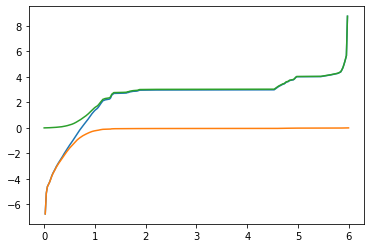

In [173]:
A = y_iso[-1]
A = y_iso[100]
A = y_iso[-1]

plt.plot(data.index, np.log(y_iso/A) - np.log1p( - y_iso/A))
plt.plot(data.index, np.log(y_iso/A))
plt.plot(data.index, - np.log1p( - y_iso/A))

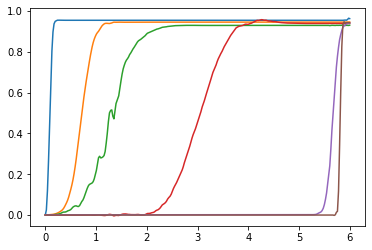

In [147]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = popt

for n in range(len(popt)//3):
    i0, i1 = n * 3, n * 3 + 3
    cdf_diff = (
        stroke_profile
        - profile.logistics(stroke_profile.index, *p[:i0], box=t1)
        - profile.logistics(stroke_profile.index, *p[i1:], box=t1)
    )
    A, m, logs = p[i0:i1]
    A0 = A * np.exp(logs) * 4
    t = stroke_profile.index
    mod_pdf = cdf_diff * profile.logistics(stroke_profile.index, 1 / A0, m, logs, box=t1) 
    plt.plot(
        utils.integrate_series(mod_pdf)
        # / A0
    )
    # break 

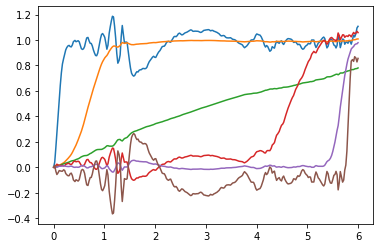

In [107]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = p1

for n in range(len(popt)//3):
    i0, i1 = n * 3, n * 3 + 3
    cdf_diff = (
        utils.integrate_series(stroke_profile)
        - profile.logistics_1(stroke_profile.index, *p[:i0], box=t1)
        - profile.logistics_1(stroke_profile.index, *p[i1:], box=t1)
    )
    A, m, logs = p[i0:i1]
    A0 = A * np.exp(logs) * 4
    plt.plot(
        cdf_diff / A0
    )

array([ 2.53529467,  0.70950106, -1.76267382])

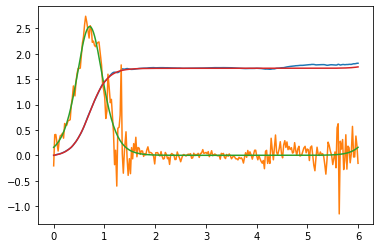

In [87]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = popt
plt.plot(
    utils.integrate_series(stroke_profile)
    - profile.logistics_1(stroke_profile.index, *p[:i0], box=t1)
    - profile.logistics_1(stroke_profile.index, *p[i1:], box=t1)
)
plt.plot(
    stroke_profile
    - profile.logistics(stroke_profile.index, *p[:i0], box=t1)
    - profile.logistics(stroke_profile.index, *p[i1:], box=t1)
)
plt.plot(
    stroke_profile.index, 
    profile.logistics(stroke_profile.index, *p[i0:i1], box=t1)
)
plt.plot(
    stroke_profile.index, 
    profile.logistics_1(stroke_profile.index, *p[i0:i1], box=t1)
)
p[i0:i1]

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


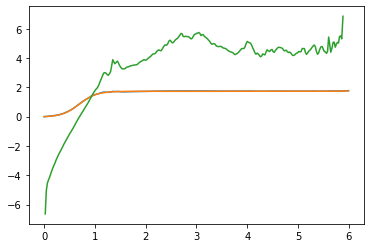

In [100]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = popt
p = p1

cdf = (
    utils.integrate_series(stroke_profile)
    - profile.logistics_1(stroke_profile.index, *p[:i0], box=t1)
    - profile.logistics_1(stroke_profile.index, *p[i1:], box=t1))
A, m, logs = p[i0:i1]

pred_cdf = profile.logistics_1(stroke_profile.index, *p[i0:i1], box=t1)

plt.plot(cdf)
plt.plot(cdf.index, pred_cdf)
A0 = A * np.exp(logs) * 4
plt.plot(np.log(cdf / A0) - np.log1p(-cdf / A0))

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


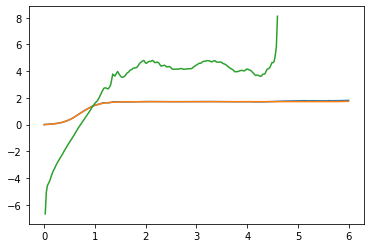

In [91]:
n = 1
i0, i1 = n * 3, n * 3 + 3
p = popt
# p = p1

cdf = (
    utils.integrate_series(stroke_profile)
    - profile.logistics_1(stroke_profile.index, *p[:i0], box=t1)
    - profile.logistics_1(stroke_profile.index, *p[i1:], box=t1))
A, m, logs = p[i0:i1]

pred_cdf = profile.logistics_1(stroke_profile.index, *p[i0:i1], box=t1)

plt.plot(cdf)
plt.plot(cdf.index, pred_cdf)
A0 = A * np.exp(logs) * 4
plt.plot(np.log(cdf / A0) - np.log1p(-cdf / A0))

In [64]:
np.exp(0.337) * 4 * 0.3

1.6808868764862424

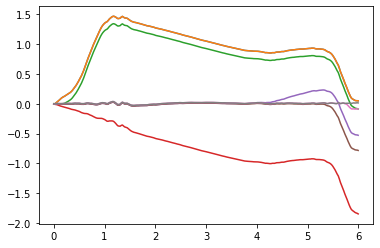

In [45]:
plt.plot(
    utils.integrate_series(stroke_profile)
)
for i in range(0, len(p1) + 1, 3):
    plt.plot(
        utils.integrate_series(stroke_profile)
        - profile.logistics_1(stroke_profile.index, *p1[0:i], box=t1)
    )

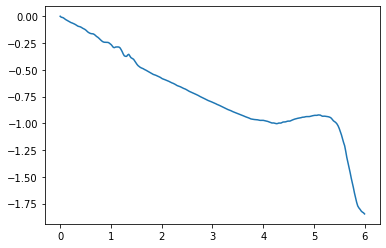

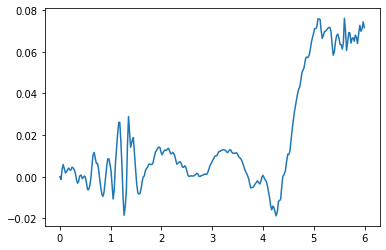

In [24]:
plt.plot(
    utils.integrate_series(stroke_profile)
    - profile.logistics_1(stroke_profile.index, *popt, box=t1)
)
# plt.plot(t, profile.logistics_1(t, *p1, box=t1))

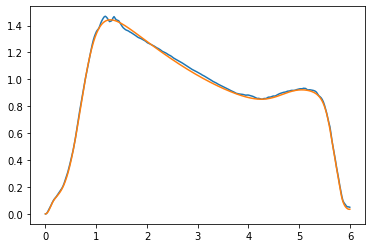

In [14]:
plt.plot(utils.integrate_series(stroke_profile))
plt.plot(t, profile.logistics_1(t, *p1, box=t1))

In [180]:
sigma_points = kalman.MSSP(
    # n=popt.size, alpha=1e-3, beta=2e0, kappa=0.
    n=popt.size, alpha=1e-1, beta=2, kappa=0.
)
points = kalman.SigmaPoints(
    sigma_points.sigma_points(popt, pcov), sigma_points
)

transition = kalman.UnscentedKalmanTransition(
    noise=pcov.diagonal() / 10
)
acc_noise_var =  acc_x.diff().var()
observe = kalman.UnscentedKalmanObserve(
    profile.observe_logistic, noise=acc_noise_var
)


new_points = transition.unscented_update(points)
pred_profile = observe.apply_to_points(
    new_points, stroke_profile.index, t1
)
loglike = - (np.square(
    pred_profile.points - stroke_profile.values[None, :]
) / acc_noise_var).sum(1)



In [181]:

W = np.exp(loglike - logsumexp(loglike))

p1, _, p1cov = kalman.weight_mean_cov(new_points.points, W)
p1 - popt 

array([-7.40377157e-04,  5.06355960e-06, -2.39477026e-05, -2.41837648e-03,
       -4.97441857e-04,  3.24845582e-04,  7.66804699e-04,  9.36387976e-04,
        1.78265493e-03,  1.02789163e-04,  4.29219536e-04, -1.23722372e-03,
        8.25417336e-04,  1.25869619e-05,  7.20368293e-04,  1.38745213e-03,
       -4.85854134e-05, -6.44985835e-04])

In [191]:
np.c_[
    np.ones((37)), 
    new_points.points, 
    (
        new_points.points[:, :, None] * new_points.points[:, None, :]
    ).reshape(37, -1)
].shape

(37, 343)

In [198]:
g, *_ = np.linalg.lstsq(
    np.c_[np.ones(37), new_points.points], loglike, rcond=-1)

In [199]:
g

array([ 1.49726199e+03,  1.21383643e+01,  1.07249070e+02,  1.18669770e+01,
       -6.54759604e+01, -5.96328966e+02, -3.14879529e+01, -7.15876904e+01,
       -2.41767790e+01,  7.10523124e+00, -4.00293761e-01, -3.94852035e+00,
        1.93040990e+00,  1.11845232e+01, -1.36786835e+02,  3.23639977e+00,
        6.59862964e+00, -4.28006519e+01, -4.25925519e+00])

In [195]:
new_points.points.shape, loglike.shape

((37, 18), (37,))

In [197]:
new_points.points.dot(new_points.points.T).shape

(37, 37)

In [185]:
g, *_ = np.linalg.lstsq(new_points.points, loglike, rcond=-1)
g

array([ 1.10304735e+01,  1.14815934e+02,  1.05882566e+01, -6.55120072e+01,
       -5.77928356e+02, -3.71716361e+01, -7.19232723e+01, -2.46720238e+01,
        8.02283883e+00, -5.30293265e-01, -3.79439684e+00,  1.89252723e+00,
        1.32554197e+01,  2.06003959e+01,  5.04947050e+00,  2.46172552e+00,
        5.99835484e+01, -1.01728742e+00])

In [161]:
from scipy.special import logsumexp

array([8.78027991e-004, 2.60197888e-028, 1.98624173e-004, 8.61277069e-033,
       9.14841852e-119, 3.07737023e-006, 1.86134215e-001, 1.69119077e-006,
       1.41846675e-005, 8.05859290e-004, 7.58992086e-004, 2.27284141e-004,
       1.51539137e-003, 2.67494098e-003, 6.16581442e-004, 2.88159529e-003,
       2.21856767e-003, 3.24869912e-004, 9.12504572e-005, 5.00856438e-004,
       2.44444897e-004, 9.19447320e-005, 7.48418825e-010, 1.00000000e+000,
       1.42421796e-006, 2.88482006e-002, 1.31213677e-001, 6.76526875e-005,
       3.37275207e-004, 1.61162415e-003, 3.79243998e-004, 5.08265141e-005,
       3.01740399e-004, 1.01172668e-004, 2.70407703e-004, 1.20823991e-003,
       2.61153361e-003])

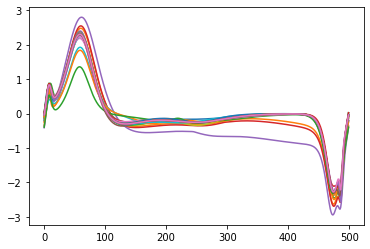

In [150]:
plt.plot(pred_profile.points.T)

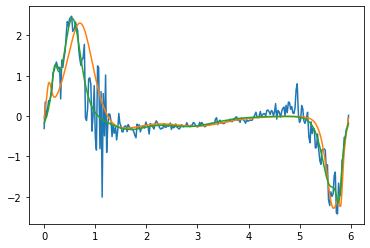

In [117]:
plt.plot(stroke_profile)
plt.plot(t, profile.observe_logistic(popt, t, box=t1))
plt.plot(t, profile.observe_logistic(p1, t, box=t1))

In [12]:
alpha = 0.8
pprec = np.linalg.inv(pcov)
pz = pprec.dot(popt)

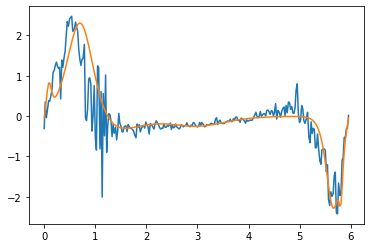

In [102]:
    stroke = fit_strokes.iloc[1]
    acc = acc_x
    s = np.s_[stroke.stroke_start:stroke.stroke_end]
    stroke_profile = acc[s].copy()
    stroke_profile.index = stroke_profile.index - stroke.stroke_start

    t1 = stroke.stroke_time
    t = stroke_profile.index 
    
    plt.plot(stroke_profile)
    plt.plot(t, profile.observe_logistic(popt, t, box=t1))


In [105]:
from rowing.model import kalman 

array([2.47567601e-02, 1.35121668e-04, 8.27490254e-02, 4.84447476e-01,
       2.11819718e-04, 2.72685830e-02, 1.04896403e-01, 6.33050221e-01,
       8.58283221e-01, 3.29987683e-03, 5.33631628e-02, 1.40029952e-01,
       2.05128017e-02, 2.26737607e-04, 9.08996829e-03, 6.60811019e-02,
       6.01272844e-05, 1.43945069e-01])

In [110]:
sigma_points = kalman.MSSP(
    # n=popt.size, alpha=1e-3, beta=2e0, kappa=0.
    n=popt.size, alpha=0.5, beta=2, kappa=0.
)
points = kalman.SigmaPoints(
    sigma_points.sigma_points(popt, pcov), sigma_points
)

transition = kalman.UnscentedKalmanTransition(
    noise=pcov.diagonal() / 10
)
observe = kalman.UnscentedKalmanObserve(
    profile.observe_logistic, noise=acc_x.diff().var()
)

new_points = transition.unscented_update(
    points, 
)
updated = observe.unscented_observe(
    stroke_profile.values, 
    new_points, 
    stroke_profile.index, 
    stroke.stroke_time
)

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


ValueError: array must not contain infs or NaNs

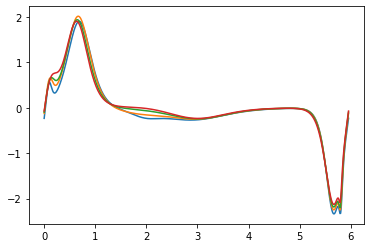

In [115]:
updated = points 
for i in range(10):
    updated = observe.unscented_observe(
        stroke_profile.values, 
        updated, 
        stroke_profile.index, 
        stroke.stroke_time
    )
    plt.plot(t, profile.observe_logistic(updated.mean, t, t1))

plt.plot(stroke_profile)



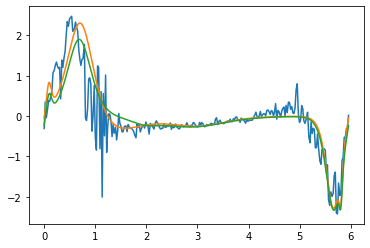

In [111]:
t1 = stroke.stroke_time
t = np.linspace(0, t1, 500)
plt.plot(stroke_profile)
plt.plot(t, profile.observe_logistic(popt, t, t1))
plt.plot(t, profile.observe_logistic(updated_points.mean, t, t1))

In [85]:
updated_points.mean

array([ 0.50411687,  0.1047889 , -3.25712482,  2.05922054,  0.68144564,
       -1.92462777, -0.07671442,  1.86830135, -1.39014641, -0.26445118,
        2.99052915, -1.02289195, -2.2086358 ,  5.66856201, -2.30869556,
       -0.71288599,  5.81108361, -3.70971716])

In [67]:
stroke_profile 

timestamp
0.000000   -0.308351
0.021136    0.348354
0.042245   -0.040344
0.063373    0.145149
0.087765    0.384168
              ...   
5.872605   -0.528304
5.893738   -0.534765
5.914855   -0.315774
5.935987   -0.297292
5.957130    0.017395
Name: accX, Length: 272, dtype: float64

In [ ]:
Wm = sigma_points.Wm 
Wc = sigma_points.Wc 


In [ ]:
pred_mean = sigma_points.Wm.dot(points)
delta_x = points - pred_mean[None, :]
pred_cov = pred_cov = (
    sigma_points.Wc[:, None, None] 
    * delta_x[..., None] 
    * delta_x[:, None, :]
).sum(0)


In [39]:
def observe(p, t, t1):
    return profile.logistics(t, *p, t1)

In [38]:
profiles = np.array([
    profile.logistics(t, *p, box=t1) for p in points
])
profiles.shape

(37, 272)

array([[ 0.74939311,  0.09076834, -3.38584398,  2.53529467,  0.70950106,
        -1.76267382, -0.40661175,  1.28215571, -1.01907141, -0.23971099,
         3.00953778, -0.98650609, -2.28824329,  5.66336936, -2.39913115,
        -0.94655079,  5.80818691, -3.75216189],
       [ 1.08316761,  0.09007951, -3.49455123,  3.13330265,  0.71544623,
        -1.64124672, -0.6541672 ,  0.6248973 , -0.19713469, -0.20615196,
         3.16225532, -1.18797295, -2.20905398,  5.66154326, -2.43437185,
        -0.9595213 ,  5.80710425, -3.78176174],
       [ 0.74939311,  0.11541733, -3.39819123,  2.64978445,  0.71064044,
        -1.75109393, -0.4410578 ,  1.16696257, -0.8404426 , -0.23180758,
         3.04664562, -1.03222335, -2.24874128,  5.65348336, -2.45901134,
        -1.08843979,  5.80801924, -3.55535825],
       [ 0.74939311,  0.09076834, -2.78551   ,  3.21730482,  0.71619748,
        -1.63876568, -0.67294787,  0.54749089, -0.05292874, -0.20018879,
         3.19490435, -1.23514028, -2.21404814,  5.669

In [25]:
pred_mean = sigma_points.Wm.dot(points)
delta_x = points - pred_mean[None, :]
pred_cov = pred_cov = (
    sigma_points.Wc[:, None, None] 
    * delta_x[..., None] 
    * delta_x[:, None, :]
).sum(0)

# update 

profiles = np.array([
    profile.logistics(t, *p, box=t1) for p in points
])

mean_profile = sigma_points.Wm.dot(profiles)
delta_prof = (profiles - mean_profile[None, :])
cov_profile = (
    sigma_points.Wc[:, None, None] 
    * delta_prof[..., None] 
    * delta_prof[:, None, :]
).sum(0)
cov_profile.flat[::mean_profile.size + 1] += acc_noise

cross_cov = (
    sigma_points.Wc[:, None, None] 
    * delta_prof[..., None] 
    * delta_x[:, None, :]
).sum(0)

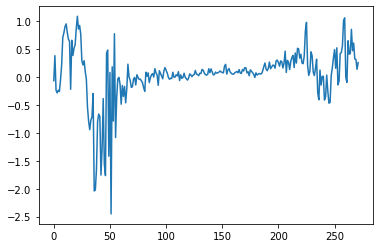

In [27]:
kalman_gain = np.linalg.solve(cov_profile, cross_cov)
pred_error = stroke_profile.values - mean_profile
plt.plot(pred_error) 

In [28]:
p1 = popt + pred_error.dot(kalman_gain)
p1 

array([ 0.60535619,  0.09105517, -3.31779207,  1.9074336 ,  0.68689728,
       -1.88059241, -0.12885869,  1.97480574, -1.69438657, -0.26770719,
        2.89471617, -0.8345626 , -2.34250275,  5.67008507, -2.29842591,
       -0.79868779,  5.80651608, -3.87810865])

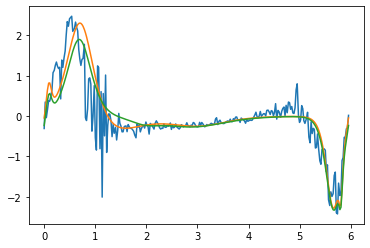

In [30]:
plt.plot(stroke_profile)
plt.plot(t, profile.logistics(t, *popt, box=t1))
plt.plot(t, profile.logistics(t, *p1, box=t1))

In [342]:
cross_cov.shape, cov_profile.shape

((18, 272), (272, 272))

In [ ]:
pred_mean = sigma_points.Wm.dot(preds)
pred_cov = (
    sigma_points.Wc[:, None, None] 
    * (preds - pred_mean[None, :])[..., None] 
    * (preds - pred_mean[None, :])[:, None, :]
).sum(0)

update



In [297]:
preds[:] = profile.logistics(t, *popt, box=t1).values[None, :]

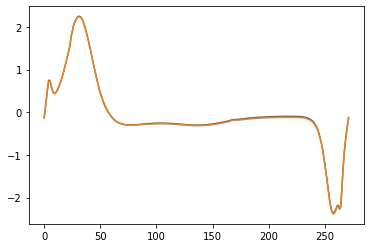

In [318]:
plt.plot(preds.mean(0))
plt.plot((sigma_points.Wm[:, None] * preds).sum(0))

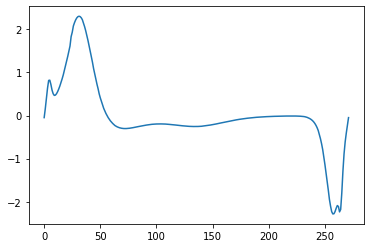

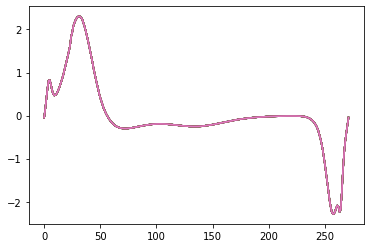

In [281]:
plt.plot(preds.T);

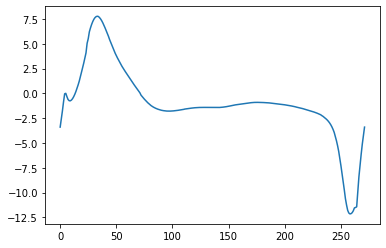

In [275]:
plt.plot((sigma_points.Wc[:, None] * preds).sum(0))

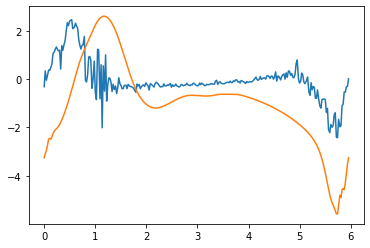

In [271]:
plt.plot(stroke_profile)
plt.plot(stroke_profile.index, pred_mean)

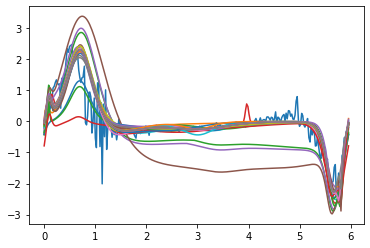

In [246]:
points = sigma_points.sigma_points(popt, pcov * 100)
preds = np.array([
    profile.logistics(t, *p, box=t1) for p in points
])

plt.plot(stroke_profile) 

for a in preds:
    plt.plot(stroke_profile.index, a)

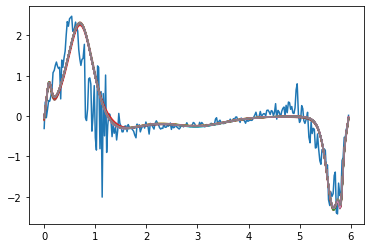

In [211]:
for t, stroke in tqdm(fit_strokes.iloc[1:].iterrows()):
    p0 = np.linalg.solve(pprec, pz)
    
    stroke_profile, popt, pcov = profile.fit_stroke_profile(
        stroke, acc_x, p0=p0)
    prec = np.linalg.inv(pcov) 
        
    stroke_params[t] = popt
    stroke_cov[t] = pcov

    pprec *= alpha 
    pz *= alpha  
    pprec += prec 
    pz += prec.dot(popt)

0it [00:00, ?it/s]

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/matthew/venv/rowing/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3820/4161332868.py", line 4, in <cell line: 1>
    stroke_profile, popt, pcov = profile.fit_stroke_profile(
  File "/mnt/c/Users/matthew/Dropbox/PC/Documents/Source/rowing/rowing/model/profile.py", line 73, in fit_stroke_profile
    popt, pcov = optimize.curve_fit(
  File "/home/matthew/venv/rowing/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py", line 794, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + errmsg)
RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3800.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthew/venv/rowing/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1992, in show

In [207]:
discount  

array([ 0.74939311,  0.09076834, -3.38584398,  2.53529467,  0.70950106,
       -1.76267382, -0.40661175,  1.28215571, -1.01907141, -0.23971099,
        3.00953778, -0.98650609, -2.28824329,  5.66336936, -2.39913115,
       -0.94655079,  5.80818691, -3.75216189])

In [206]:
p0 = np.linalg.solve(pprec, pz)
p0 

array([ 0.74939311,  0.09076834, -3.38584398,  2.53529467,  0.70950106,
       -1.76267382, -0.40661175,  1.28215571, -1.01907141, -0.23971099,
        3.00953778, -0.98650609, -2.28824329,  5.66336936, -2.39913115,
       -0.94655079,  5.80818691, -3.75216189])

In [205]:
stroke 

a                  0.777312
v                146.683456
smooth             0.023151
smooth_v         144.378342
var_smooth_a       0.955104
sgn_chg            1.000000
DeltaV            -0.772202
stroke_end      1918.443088
stroke_start    1912.485958
stroke_time        5.957130
stroke_rate       10.071964
Name: 1918.594151, dtype: float64

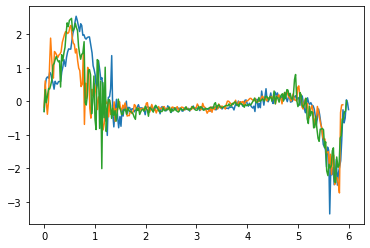

In [157]:
for t, stroke in strokes[
    (strokes.stroke_rate > 10)
    & (strokes.stroke_rate < 10.5)   
].iterrows():
    
    s = np.s_[stroke.stroke_start:stroke.stroke_end]

    stroke_profile = acc_x.loc[s].copy()
    stroke_profile.index -= stroke_profile.index[0]

    plt.plot(stroke_profile)

<ErrorbarContainer object of 3 artists>

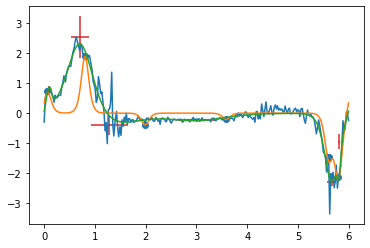

In [178]:


    

plt.plot(stroke_profile)
plt.scatter(peaks, stroke_profile.loc[peaks])
plt.plot(t, profile.logistics(t, *p0.ravel(), box=t1))
plt.plot(t, profile.logistics(t, *popt, box=t1))
plt.errorbar( 
    ms, As, 
    xerr=np.exp(logT), 
    yerr=np.sqrt(As_var),
    ls=''
)

<ErrorbarContainer object of 3 artists>

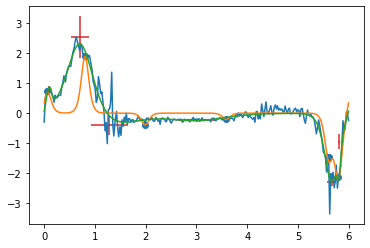

/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/matthew/venv/rowing/lib/python3.8/site-packages/pandas

<ErrorbarContainer object of 3 artists>

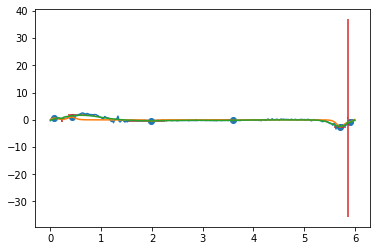

In [167]:
x = stroke_profile.index
t1 = stroke.stroke_end - stroke.stroke_start
t = np.linspace(0, t1, 1000)

peak_times = np.r_[
    0.05, 0.4, 
    (t1 - 0.7) * 0.3 + 0.4, (t1 - 0.7) * 0.6 + 0.4, 
    t1 - 0.3, t1 - 0.1
]

peaks = stroke_profile.index[
    stroke_profile.index.searchsorted(peak_times)
]

p0 = np.c_[
    stroke_profile.loc[peaks], 
    peaks, 
    np.full_like(peaks, -3)
]

popt, pcov = profile.optimize.curve_fit(
    lambda x, *params: profile.logistics(x, *params, box=t1), 
    x, stroke_profile.values, 
    p0=p0.ravel(),
)
As, ms, logT = popt.reshape(-1, 3).T
As_var, ms_var, logT_var = pcov.diagonal().reshape(-1, 3).T

plt.plot(stroke_profile)
plt.scatter(peaks, stroke_profile.loc[peaks])
plt.plot(t, profile.logistics(t, *p0.ravel(), box=t1))
plt.plot(t, profile.logistics(t, *popt, box=t1))
plt.errorbar(
    ms, As, 
    xerr=np.exp(logT), 
    yerr=np.sqrt(As_var),
    ls=''
)

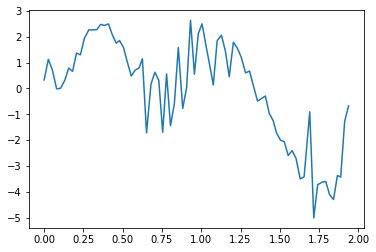

In [71]:
stroke = strokes.iloc[701]
s = np.s_[stroke.stroke_start:stroke.stroke_end]
stroke_profile = acc_x[s].copy()
stroke_profile.index = stroke_profile.index - stroke.stroke_start

plt.plot(stroke_profile)

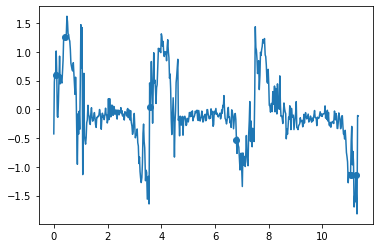

In [126]:


stroke = strokes[
    (strokes.stroke_rate > 5)
    & (strokes.stroke_rate < 6)
].iloc[0]

# stroke = strokes.iloc[503]

s = np.s_[stroke.stroke_start:stroke.stroke_end]
stroke_profile = acc_x[s].copy()
stroke_profile.index = stroke_profile.index - stroke.stroke_start

x = stroke_profile.index
t1 = stroke.stroke_end - stroke.stroke_start
t = np.linspace(0, t1, 1000)

peak_times = np.r_[
    0.05, 0.4, 
    (t1 - 0.7) * 0.3 + 0.4, (t1 - 0.7) * 0.6 + 0.4, 
    t1 - 0.3, t1 - 0.1
]
peaks = stroke_profile.index[
    stroke_profile.index.searchsorted(peak_times)
]

plt.plot(stroke_profile)
plt.scatter(peaks, stroke_profile.loc[peaks])

In [118]:
%%time 
popt, pcov = profile.optimize.curve_fit(
    lambda x, *params: profile.logistics(x, *params, box=t1), 
    x, stroke_profile.values, 
    p0=popt,
)

CPU times: user 62.4 ms, sys: 76 µs, total: 62.5 ms
Wall time: 61.5 ms


<ErrorbarContainer object of 3 artists>

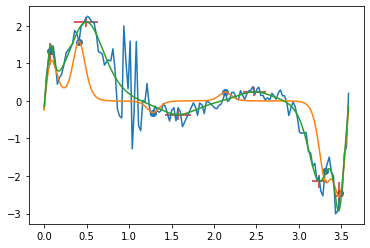

In [112]:
x = stroke_profile.index
t1 = stroke.stroke_end - stroke.stroke_start
t = np.linspace(0, t1, 1000)

peak_times = np.r_[
    0.05, 0.4, 
    (t1 - 0.7) * 0.3 + 0.4, (t1 - 0.7) * 0.6 + 0.4, 
    t1 - 0.3, t1 - 0.1
]

peaks = stroke_profile.index[
    stroke_profile.index.searchsorted(peak_times)
]

p0 = np.c_[
    stroke_profile.loc[peaks], 
    peaks, 
    np.full_like(peaks, -3)
]

popt, pcov = profile.optimize.curve_fit(
    lambda x, *params: profile.logistics(x, *params, box=t1), 
    x, stroke_profile.values, 
    p0=p0.ravel(),
)
As, ms, logT = popt.reshape(-1, 3).T
As_var, ms_var, logT_var = pcov.diagonal().reshape(-1, 3).T

plt.plot(stroke_profile)
plt.scatter(peaks, stroke_profile.loc[peaks])
plt.plot(t, profile.logistics(t, *p0.ravel(), box=t1))
plt.plot(t, profile.logistics(t, *popt, box=t1))
plt.errorbar(
    ms, As, 
    xerr=np.exp(logT), 
    yerr=np.sqrt(As_var),
    ls=''
)

<ErrorbarContainer object of 3 artists>

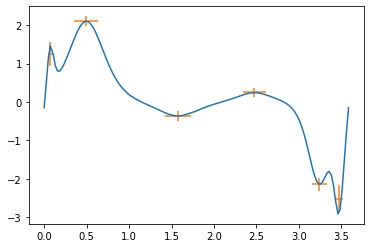

In [114]:
t = np.linspace(0, t1, 1000)
plt.plot(x, profile.logistics(x, *popt, box=t1))
plt.errorbar(
    ms, As, 
    xerr=np.exp(logT), 
    yerr=np.sqrt(As_var),
    ls=''
)

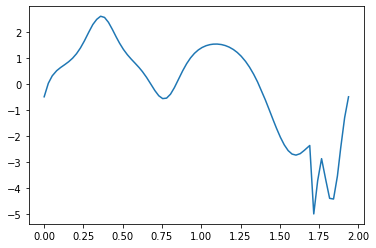

In [76]:
plt.plot(x, profile.logistics(x, *popt, box=t))

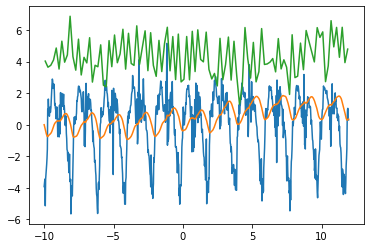

In [69]:
stroke = strokes.iloc[701]
s = np.s_[stroke.stroke_start - 10:stroke.stroke_end + 10]
stroke_profile = acc_x[s].copy()
stroke_profile.index = stroke_profile.index - stroke.stroke_start

vel_profile = utils.integrate_series(stroke_profile)

stroke_gps = valid_gps_data.loc[s].copy()
stroke_gps.index = stroke_gps.index - stroke.stroke_start

gps_times = stroke_profile.index[
    stroke_profile.index.searchsorted(stroke_gps.index)
]


plt.plot(stroke_profile)
plt.plot(vel_profile)
plt.plot(stroke_gps.metrePerSecond)

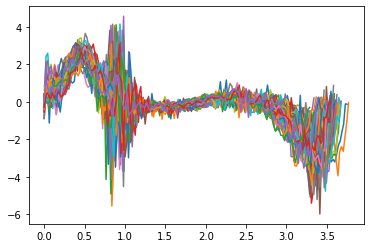

In [67]:
s = np.s_[2500:2800]
for t, stroke in strokes.loc[s].iterrows():
    stroke_profile = acc_x[stroke.stroke_start:stroke.stroke_end].copy()
    stroke_profile.index = stroke_profile.index - stroke.stroke_start
    plt.plot(stroke_profile)


In [130]:
from rowing.model import profile
from scipy import optimize 

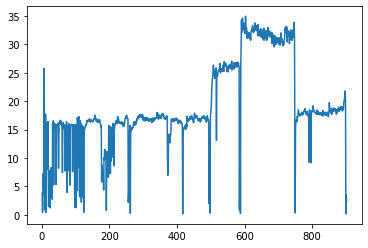

In [184]:
plt.plot(60 / strokes.stroke_time.values)

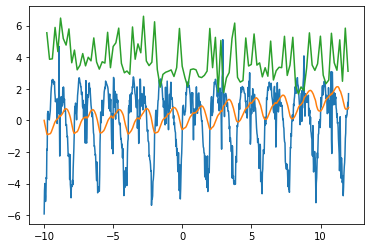

In [243]:
stroke = strokes.iloc[701]
s = np.s_[stroke.stroke_start - 10:stroke.stroke_end + 10]
stroke_profile = acc_x[s].copy()
stroke_profile.index = stroke_profile.index - stroke.stroke_start

stroke_gps = valid_gps_data.loc[s].copy()
stroke_gps.index = stroke_gps.index - stroke.stroke_start

gps_times = stroke_profile.index[
    stroke_profile.index.searchsorted(stroke_gps.index)
]

v_profile = integrate_series(stroke_profile)

plt.plot(stroke_profile)
plt.plot(v_profile)
plt.plot(stroke_gps.metrePerSecond)

In [1]:

v_profile = integrate_series(stroke_profile)
v_profile.index = pd.to_timedelta(
    v_profile.index - v_profile.index[0], 's'
)



NameError: name 'integrate_series' is not defined

In [273]:
v_profile

timestamp
0 days 00:00:00          NaN
0 days 00:00:00.024861   NaN
0 days 00:00:00.049698   NaN
0 days 00:00:00.074521   NaN
0 days 00:00:00.099352   NaN
                          ..
0 days 00:00:22.918483   NaN
0 days 00:00:22.943350   NaN
0 days 00:00:22.970276   NaN
0 days 00:00:22.998788   NaN
0 days 00:00:23.024394   NaN
Length: 1754, dtype: float64

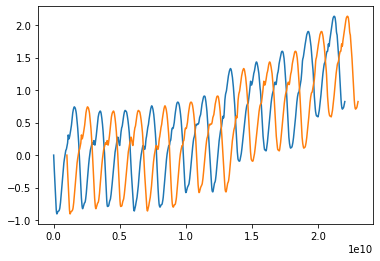

In [272]:
plt.plot(v_profile)
plt.plot(
    v_profile.shift(periods=1, freq='s')
)

In [257]:
v_profile.index = pd.to_timedelta(v_profile.index + v_profile.index[0])
v_profile.shift(periods=1, freq='s')

timestamp
0 days 00:00:00.999999991    0.000000
0 days 00:00:00.999999991   -0.128873
0 days 00:00:00.999999991   -0.233723
0 days 00:00:00.999999991   -0.341079
0 days 00:00:00.999999991   -0.462564
                               ...   
0 days 00:00:01.000000011    0.727491
0 days 00:00:01.000000011    0.740917
0 days 00:00:01.000000011    0.765746
0 days 00:00:01.000000012    0.792425
0 days 00:00:01.000000012    0.823435
Length: 877, dtype: float64

NotImplementedError: This method is only implemented for DatetimeIndex, PeriodIndex and TimedeltaIndex; Got type Float64Index

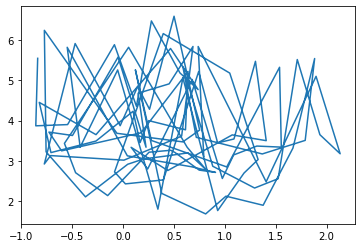

In [249]:

plt.plot(v_profile[gps_times], stroke_gps.metrePerSecond)

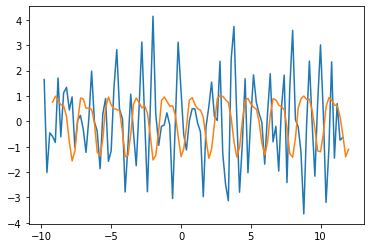

In [238]:
plt.plot(
    stroke_gps.metrePerSecond.diff(-2),
)
plt.plot(
    integrate_series(stroke_profile).loc[gps_times].diff(3)
)

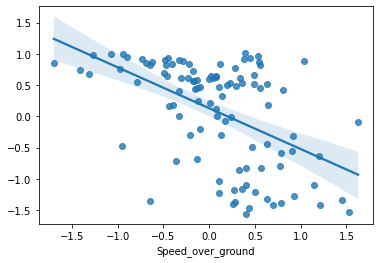

In [234]:
sns.regplot(
    x = stroke_gps.Speed_over_ground.diff(-3),
    y = integrate_series(stroke_profile).loc[gps_times].diff(3)
)

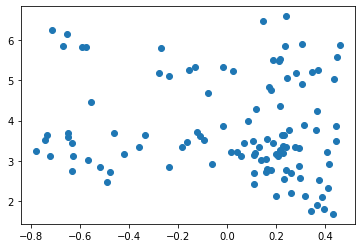

In [198]:
# plt.plot(
#     stroke_profile
# )
plt.scatter(
    integrate_series(stroke_profile).loc[gps_times].diff().iloc[],
    stroke_gps.metrePerSecond
)

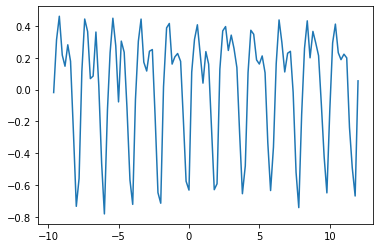

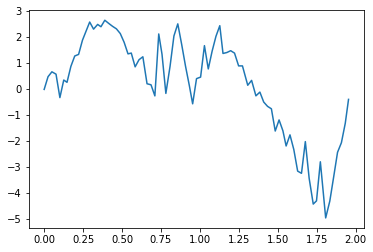

In [154]:
stroke = strokes.iloc[700]
stroke_profile = acc_x[stroke.stroke_start:stroke.stroke_end].copy()
stroke_profile.index = stroke_profile.index - stroke.stroke_start

plt.plot(stroke_profile)


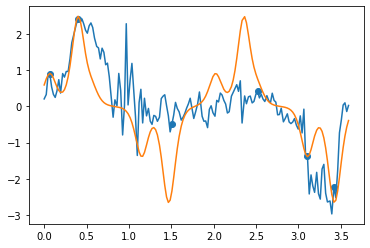

In [153]:
plt.plot(stroke_profile)
x = stroke_profile.index
t = stroke.stroke_end - stroke.stroke_start
peaks = stroke_profile.index[
    stroke_profile.index.searchsorted(
        np.r_[0.05, 0.4, 1.5, 2.5, 3.1, 3.4]
    )
]

p0 = np.c_[
    stroke_profile.loc[peaks], 
    peaks, 
    np.full_like(peaks, -3)
]

plt.scatter(peaks, stroke_profile.loc[peaks])
plt.plot(x, profile.logistics(x, *p0.ravel(), box=t))

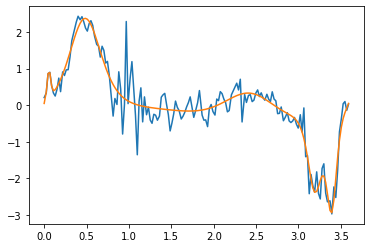

In [141]:
popt, pcov = optimize.curve_fit(
    lambda x, *params: profile.logistics(x, *params, box=t), 
    x, stroke_profile.values, 
    p0=p0.ravel(),
)

plt.plot(stroke_profile)
plt.plot(x, profile.logistics(x, *popt, box=t))

In [ ]:

peaks = np.r_[27, 134, 400, 700, 961]
x = np.linspace(0, 1, n_interp)
y = - profiles.mean(0)
y_std = profiles.std(0)
y[0] = y[-1] = 0.

p0 = np.c_[
    y[peaks], 
    peaks/n_interp, 
    np.full_like(peaks, -4)
]

# plt.plot(x, logistics(x, *p0.ravel(), box=1.))

popt, pcov = optimize.curve_fit(
    logistics, x, y, p0=p0.ravel(), 
)
As, ms, logT = popt.reshape(-1, 3).T

plt.plot(x, y)
plt.plot(x, logistics(x, *popt, box=1.))
plt.scatter(ms, As)

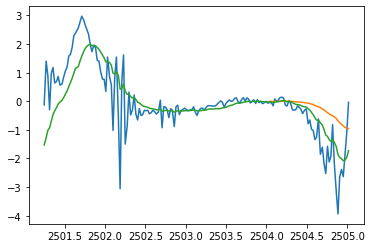

In [97]:
t0, t1 = strokes.loc[2500:].iloc[:2].v_peak_time
s = np.s_[t0:t1]

plt.plot(acc_x[s])
plt.plot(integrate_series(acc_x[t1 - 1:t1]))
plt.plot(data.a[s])

In [ ]:
acc = 

In [7]:
def integrate_series(s, initial=0):
    return pd.Series(
        integrate.cumtrapz(s, s.index, initial=initial), 
        index=s.index 
    )

In [8]:
alpha = 0.1
ema = acc_x.ewm(alpha=alpha).mean()
ema2 = ema.ewm(alpha=alpha).mean()
ema3 = ema2.ewm(alpha=alpha).mean()
dema = ema * 2 - ema2
tema = 3 * ema - 3 * ema2 + ema3 

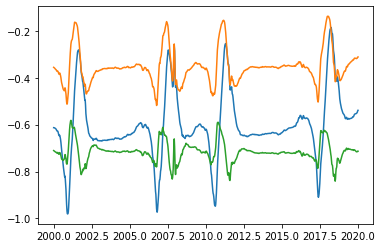

In [9]:
s = np.s_[2000:2020]
v = integrate_series(acc_x)[s]
# plt.plot(integrate_series(acc_x)[s])
plt.plot(v - integrate_series(ema)[s])
plt.plot(v - integrate_series(dema)[s])
plt.plot(v - integrate_series(tema)[s])

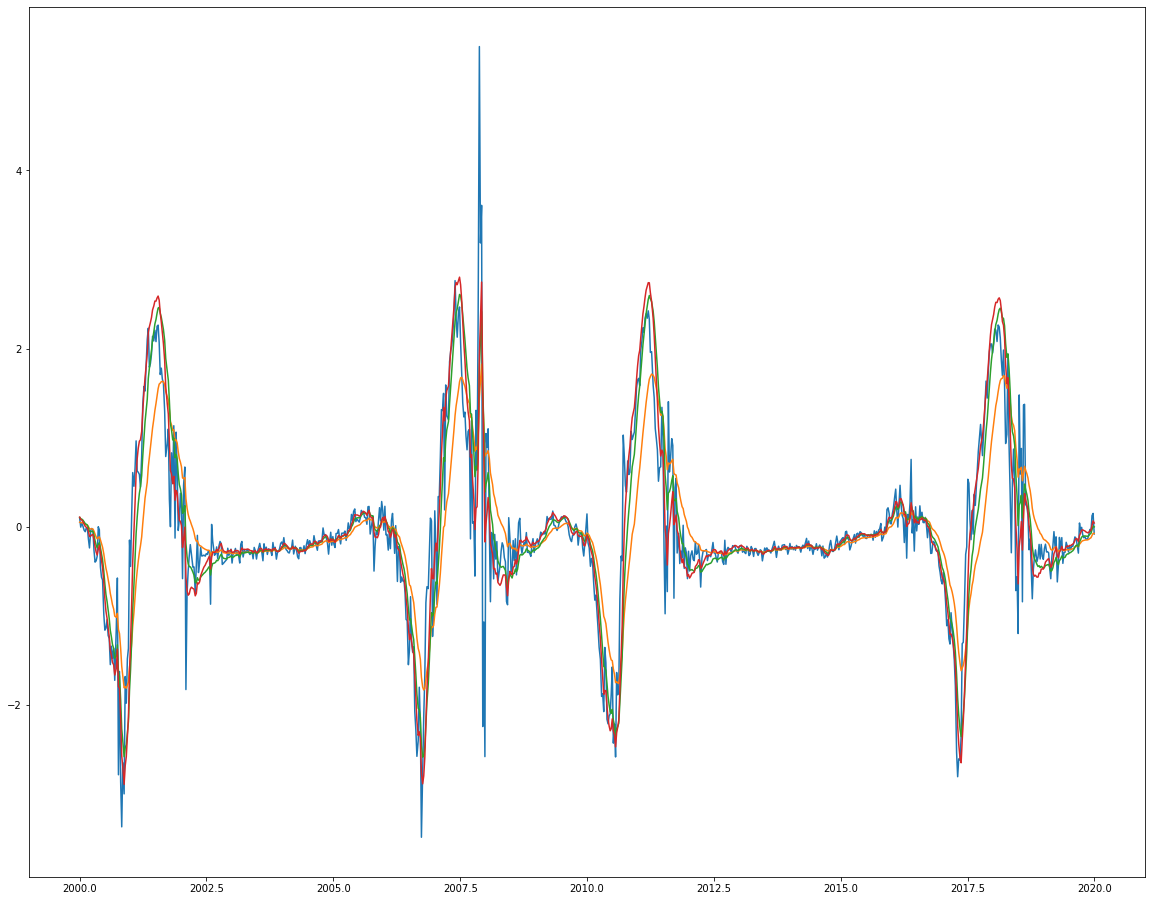

In [142]:
f, ax = plt.subplots(figsize=(20, 16))
plt.plot(acc_x[2000:2020])
plt.plot(ema[2000:2020])
plt.plot(dema[2000:2020])
plt.plot(tema[2000:2020])
# plt.plot(acc_x.loc[2000:2020] - ema[2000:2020])
# plt.plot(acc_x.loc[2000:2020] - dema[2000:2020])

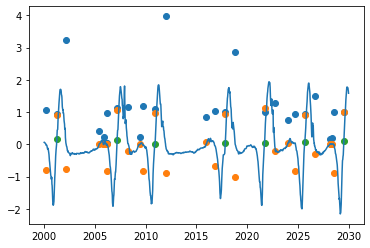

In [113]:
Dv_peaks = - v_peaks.reset_index().diff(-1)
Dv_peaks.index = v_peaks.index 
p = Dv_peaks.loc[s].index

plt.scatter(p, Dv_peaks.loc[s].timestamp)
plt.scatter(p, Dv_peaks.loc[s].v)

strokes = Dv_peaks[
    (Dv_peaks.timestamp < 2) & 
    (Dv_peaks.v > 0.5)
][s].index

plt.scatter(strokes, data.a.loc[strokes])

plt.plot(data.a.loc[s])

timestamp
2000.173144    0.013687
2001.243925   -0.796143
2002.181336    0.912369
2005.422447   -0.751541
2005.843706    0.025848
2005.910508    0.000031
2006.124527    0.009720
2006.166470   -0.000290
2006.208392   -0.000198
2007.172333   -0.832626
2008.306927    1.075623
2009.475936   -0.199005
2009.694519    0.006592
2010.890073   -0.829620
2011.978806    0.956726
2015.952994   -0.887299
2016.794992    0.080170
2017.835955   -0.678635
2018.837852    0.933792
2021.716263   -1.023193
2022.730679    1.141159
2024.001408   -0.209442
2024.762447    0.055557
2025.690752   -0.815338
2026.643100    0.907303
2028.154131   -0.289200
2028.306996    0.001648
2028.328142    0.000000
2028.532455    0.001938
2029.537647   -0.892944
Name: v, dtype: float32

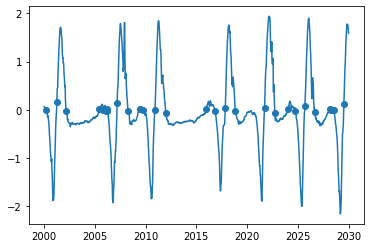

In [29]:

s = slice(2000, 2030)

plt.plot(data.a.loc[s])


peak_data['DeltaV'] = data.v.loc[peak_data.index].diff()
peaks = peak_data.Dv[s].index

# plt.scatter(peak_data.Dv[s].index, peak_data.Dv[s])
plt.scatter(peaks, data.a[peaks])


In [30]:
peak_data

v         a     var_a        Dv  sgn_chg     DeltaV
timestamp                                                               
2.094606      0.002588  0.224436  0.455314  0.002588      1.0        NaN
5.335164      6.736841 -0.110356  1.171211  0.002481      1.0   6.734253
5.837689      6.587417  0.002377  0.409452 -0.003345      1.0  -0.149425
5.861615      6.586246 -0.100287  0.476822 -0.004517      1.0  -0.001171
6.092837      6.545703  0.069761  2.890657 -0.011611      1.0  -0.040542
...                ...       ...       ...       ...      ...        ...
5713.373984  44.167595 -0.202942  3.225157  0.003525      1.0   0.003525
5713.494592  44.144680  0.096059  3.533274 -0.008774      1.0  -0.022915
5722.046133  59.389477 -0.051103  0.953090  0.002480      1.0  15.244797
5722.071005  59.389004  0.013026  0.919589  0.002007      1.0  -0.000473
5722.095920  59.388180 -0.079267  0.937607  0.001183      1.0  -0.000824

[6982 rows x 6 columns]

timestamp
2.094606        6.734253
5.335164       -0.149425
5.837689       -0.001171
5.861615       -0.040542
6.092837        0.005978
                 ...    
5713.373984    -0.022915
5713.494592    15.244797
5722.046133    -0.000473
5722.071005    -0.000824
5722.095920          NaN
Name: DeltaV, Length: 6982, dtype: float32

In [36]:
peak_data['DvDv'] = peak_data.DeltaV * peak_data.DeltaV.shift(-1)

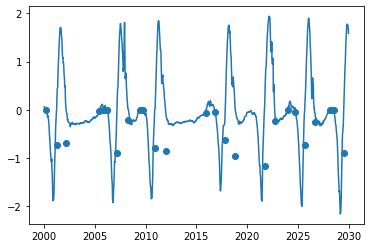

In [39]:
plt.plot(data.a[s])

plt.scatter(
    peak_data.DvDv.loc[s].index, 
    peak_data.DvDv.loc[s],
)

In [34]:
strokes = peak_data.loc[
    (peak_data.DeltaV < - 0.5)
    & (peak_data.DeltaV.shift(-1) > 0.5)
]

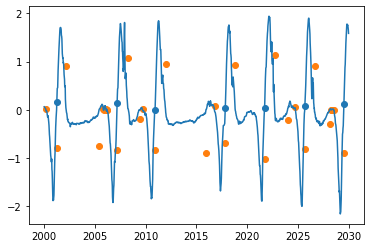

In [35]:
plt.plot(data.a[s])
plt.scatter(
    strokes.loc[s].index,
    data.a.loc[strokes.index][s],
)
plt.scatter(
    peak_data.loc[s].index,
    data.v.loc[peak_data.index].diff().loc[s],
)

In [14]:
peak_data.Dv[s]

timestamp
2000.173144    0.000641
2001.243925    0.000534
2002.181336    0.000305
2005.422447   -0.000504
2005.843706    0.000458
2005.910508    0.000153
2006.124527    0.000198
2006.166470   -0.000290
2006.208392   -0.000198
2007.172333   -0.002243
2008.306927    0.000916
2009.475936    0.000015
2009.694519    0.000488
2010.890073   -0.006042
2011.978806    0.000320
2015.952994   -0.000626
2016.794992    0.000305
2017.835955   -0.005508
2018.837852    0.000916
2021.716263   -0.002213
2022.730679    0.001862
2024.001408   -0.000076
2024.762447    0.001129
2025.690752   -0.000748
2026.643100    0.000381
2028.154131   -0.000046
2028.306996    0.000290
2028.328142    0.000290
2028.532455    0.000168
2029.537647   -0.002563
Name: Dv, dtype: float32

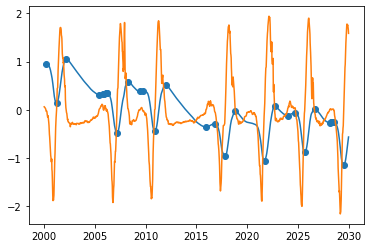

In [13]:
peak_data.Dv[s]

s = slice(2000, 2030)
v = data.v.loc[s] - data.v.loc[s].mean()

v_peaks = data.v[data.sgn_chg == 1] - data.v.loc[s].mean()
peaks = 2 * v_peaks - v_peaks.shift() - v_peaks.shift(-1)

plt.plot(v)
plt.plot(data.a.loc[s])
# plt.scatter(v_peaks.loc[s].index, v_peaks.loc[s])
plt.scatter(v_peaks.loc[s].index, v_peaks.loc[s])

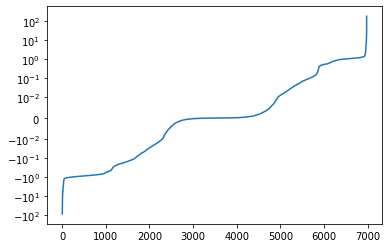

In [97]:
plt.plot(v_peaks.diff().sort_values().values)
plt.yscale("symlog", linthreshy=1e-2)

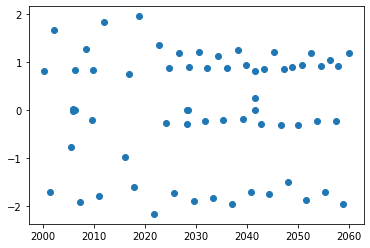

In [86]:

plt.scatter(peaks.loc[s].index, peaks.loc[s])

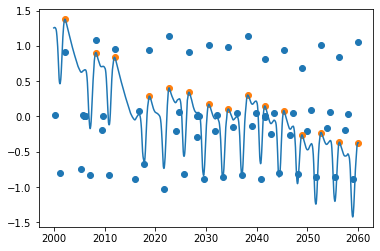

In [78]:

v = data.v.loc[2000:2060] - data.v.loc[2000:2060].mean()


plt.plot(v)
v_peaks = data.v[data.sgn_chg == 1].diff().loc[2000:2060]

plt.scatter(v_peaks.index, v_peaks)
plt.scatter(v_peaks[v_peaks > 0.5].index, v[v_peaks[v_peaks > 0.5].index])

timestamp
2.094606             NaN
5.335164        6.734253
5.837689       -0.149425
5.861615       -0.001171
6.092837       -0.040542
                 ...    
5713.373984     0.003525
5713.494592    -0.022915
5722.046133    15.244797
5722.071005    -0.000473
5722.095920    -0.000824
Name: v, Length: 6982, dtype: float32

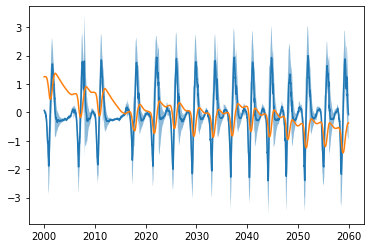

In [49]:
plt.plot(data.a.loc[2000:2060])
plt.plot(data.v.loc[2000:2060] - data.v.loc[2000:2060].mean())
plt.fill_between(
    data.a.loc[2000:2060].index, 
    data.a.loc[2000:2060] + np.sqrt(data.var_a.loc[2000:2060]),
    data.a.loc[2000:2060] - np.sqrt(data.var_a.loc[2000:2060]),
    alpha=0.5
)

In [15]:
acc_x.reset_index()

timestamp      accX
0          2.071541  2.962814
1          2.094606  2.253134
2          2.118511  3.108643
3          2.142450  4.036104
4          2.163732  3.016237
...             ...       ...
247315  5734.436001 -3.757423
247316  5734.460822 -3.252951
247317  5734.485550 -4.210388
247318  5734.510267 -5.226530
247319  5734.534975 -3.454002

[247320 rows x 2 columns]

In [9]:
times = acc_x.index

vel_x = pd.Series(
    integrate.cumtrapz(
        - acc_x, acc_x.index, initial=0
    ),
    times, 
)
smooth = acc_x.ewm(alpha=0.2).mean()
pos_accel = smooth > 0 
accel_changes = times[
    pos_accel.diff().fillna(False).values.nonzero()
]
delta_v = vel_x[accel_changes].diff(-1).fillna(0)
peak_w = - pd.Series(accel_changes, accel_changes).diff(-1).fillna(0)

In [334]:
np.log10(peak_w[peak_w < 1])

timestamp
3.431162      -1.331521
5.190471      -1.620985
5.214405      -1.124863
5.289418      -0.280383
5.813763      -1.320100
                 ...   
5721.420609   -1.019769
5721.516159   -1.303722
5721.565850   -1.100229
5721.645241   -0.428667
5722.017918        -inf
Name: timestamp, Length: 9203, dtype: float64

In [338]:
10**-1.5

0.03162277660168379

/home/matthew/venv/rowing/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


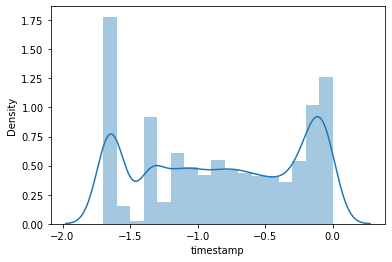

In [336]:
sns.distplot(np.log10(peak_w[(peak_w < 1) & (peak_w > 0)]))

(0.0, 3.0)

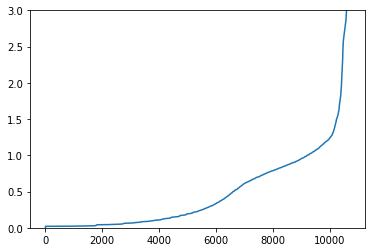

In [328]:
plt.plot(np.sort(peak_w))
plt.ylim(0, 3)

In [316]:
peak_w

timestamp
3.431162      -0.046610
3.477772      -1.712699
5.190471      -0.023934
5.214405      -0.075013
5.289418      -0.524345
                 ...   
5721.420609   -0.095550
5721.516159   -0.049691
5721.565850   -0.079391
5721.645241   -0.372677
5722.017918    0.000000
Name: timestamp, Length: 10701, dtype: float64

In [377]:
np.r_[np.diff(pos_peaks.index) > 1]

array([False,  True,  True, ...,  True,  True,  True])

Float64Index([  15.957849,   22.012339,   25.728544,   32.830432,   37.316662,
               146.322629,  185.986786,  190.590105,  202.589472,  211.085305,
              ...
              5672.148618, 5679.870408,  5685.21708, 5686.247423, 5688.845378,
              5689.918898, 5692.497972, 5695.185176,  5701.90302, 5703.689329],
             dtype='float64', name='timestamp', length=1147)

In [390]:
pos_peaks = delta_v[(delta_v > 0.4) & (peak_w > 0.3)]
peak_sep = np.diff(pos_peaks.index)
peak_sep = peak_sep[peak_sep > 1.]

array([9.793785, 6.05449 , 3.716205, ..., 2.687204, 6.717844, 1.786309])

In [392]:

pos_peaks = delta_v[(delta_v > 0.4) & (peak_w > 0.3)]
pos_peaks.index

Float64Index([   6.164064,   15.957849,   22.012339,   25.728544,   32.830432,
                37.316662,  146.322629,  185.986786,  190.590105,  202.589472,
              ...
              5672.148618, 5679.870408,  5685.21708, 5686.247423, 5688.845378,
              5689.918898, 5692.497972, 5695.185176,  5701.90302, 5703.689329],
             dtype='float64', name='timestamp', length=1151)

In [395]:
peaks

timestamp
3.477772       -1.952914
6.164064        0.576817
7.400208       -1.345474
8.872926       -5.699892
12.000932      -7.709246
                 ...    
5701.903020     3.023008
5703.689329    15.942700
5707.221874    -6.136267
5709.958456    -3.444596
5713.494592   -15.158538
Length: 2162, dtype: float64

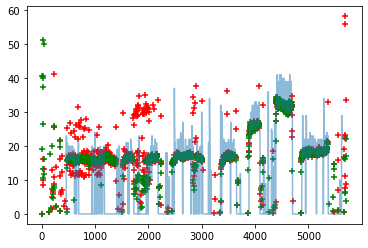

In [406]:

pos_peaks = delta_v[(delta_v > 0.4) & (peak_w > 0.3)]
pos_peaks = pos_peaks.index[1:][np.diff(pos_peaks.index) > 0.8]
peak_sep = np.diff(pos_peaks)
stroke_rates = pd.Series(
    np.r_[0, 60/peak_sep],
    pos_peaks,
)
neg_peaks = delta_v[(delta_v < - 0.4) & (peak_w > 0.5)]
neg_peaks = neg_peaks.index[1:][np.diff(neg_peaks.index) > 0.8]
peak_sep = np.diff(neg_peaks)
stroke_rates2 = pd.Series(
    np.r_[0, 60/peak_sep],
    neg_peaks,
)

s = slice(2000, 3000)
s = slice(None)
# s = slice(4400, 4700)
activity_rates = activity.set_index('timestamp').cadence
plt.plot(activity_rates.loc[s],  alpha=0.5)

plt.scatter(
    stroke_rates.loc[s].index, stroke_rates.loc[s], 
    marker='+', c='r'
)
plt.scatter(
    stroke_rates2.loc[s].index, stroke_rates2.loc[s], 
    marker='+', c='g'
)

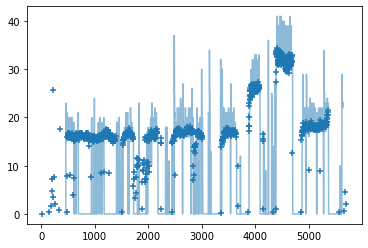

In [461]:
sel_peaks = delta_v[
    (delta_v < -0.4) 
    & (delta_v.shift() > 0.4)
    & (peak_w > 0.2)
]
rates = pd.Series(
    np.r_[0, 60/np.diff(sel_peaks.index)],
    sel_peaks.index,
)

s = slice(2000, 3000)
s = slice(None)
# s = slice(4400, 4700)
activity_rates = activity.set_index('timestamp').cadence
plt.plot(activity_rates.loc[s],  alpha=0.5)


plt.scatter(rates[s].index, rates[s], marker='+')

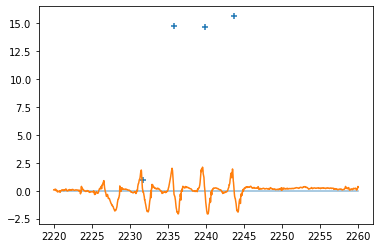

In [460]:

s = slice(2220, 2260)
# s = slice(None)
# s = slice(4400, 4700)
activity_rates = activity.set_index('timestamp').cadence
plt.plot(activity_rates.loc[s],  alpha=0.5)

plt.plot(smooth[s])
plt.scatter(rates[s].index, rates[s], marker='+')

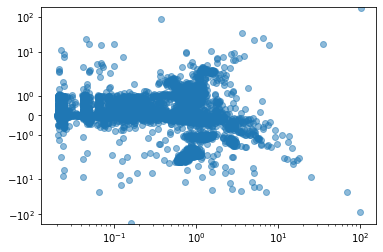

In [418]:
plt.scatter(
    np.diff(delta_v.index), 
    np.diff(delta_v.values),
    alpha=0.5
)
plt.xscale("log")
plt.yscale("symlog")

In [424]:
DDv = delta_v + delta_v.shift(-1)

10701

timestamp
3.477772       -1.952914
7.400208       -1.345474
8.872926       -5.699892
12.000932      -7.709246
16.520203      -1.050471
                 ...    
5677.892339    -6.383900
5681.591724    -6.828624
5707.221874    -6.136267
5709.958456    -3.444596
5713.494592   -15.158538
Length: 1064, dtype: float64

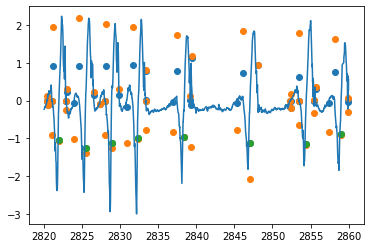

In [446]:

plt.plot(-smooth.loc[s])



DDv = delta_v - delta_v.shift(-1)
sel = (DDv < -0.5) & (delta_v < -0.5)

plt.scatter(DDv[s].index, delta_v[s])
plt.scatter(DDv[s].index, DDv[s])

plt.scatter(delta_v[sel][s].index, delta_v[sel][s])

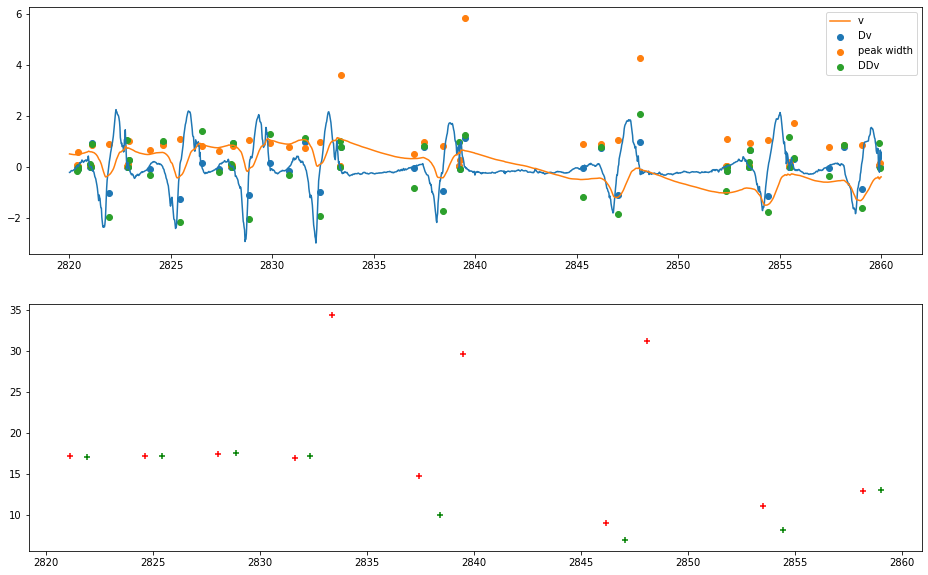

In [425]:
s = slice(2820, 2860)

f, (ax1, ax2) = plt.subplots(2, figsize=(16, 10))

ax2.scatter(
    stroke_rates.loc[s].index, stroke_rates.loc[s], 
    marker='+', c='r'
)
ax2.scatter(
    stroke_rates2.loc[s].index, stroke_rates2.loc[s], 
    marker='+', c='g'
)

ax1.plot(-smooth.loc[s])
ax1.plot(vel_x.loc[s] - vel_x.loc[s].mean(), label='v')
ax1.scatter(delta_v.loc[s].index, delta_v.loc[s], label='Dv')
ax1.scatter(peak_w.loc[s].index, peak_w.loc[s], label='peak width')

ax1.scatter(
    delta_v.loc[s].index,
    DDv.loc[s],
    label='DDv'
)
ax1.legend()

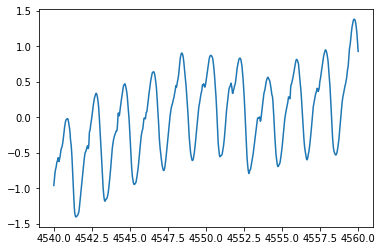

In [360]:

plt.plot(vel_x.loc[s] - vel_x.loc[s].mean())

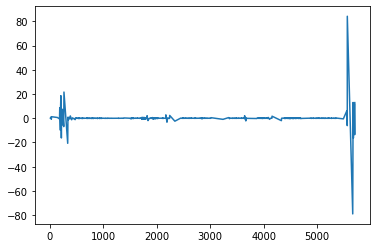

In [271]:
plt.plot(pos_peaks.diff())

In [229]:
s = slice(2700, 2730)
acc = - acc_x.loc[s]
vel = vel_x.loc[s]

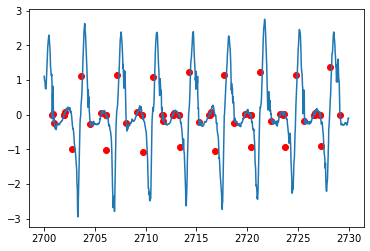

In [264]:
smooth = acc.ewm(alpha=0.2).mean()
pos_accel = smooth > 0 
accel_change = acc.index[
    pos_accel.diff().fillna(False).values.nonzero()
]
delta_v = vel[accel_change].diff(-1).fillna(0)

plt.plot(smooth)
plt.scatter(accel_change, - delta_v, color='r')


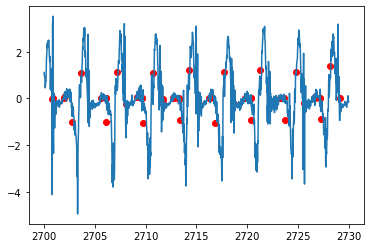

In [243]:
np.diff(pos_accel.diff().fillna(False).values).nonzero()

(array([  35,   36,   37,   38,   41,   42,   89,   92,  122,  123,  165,
         166,  205,  206,  256,  257,  277,  280,  326,  327,  368,  369,
         417,  418,  441,  444,  488,  489,  532,  535,  577,  578,  579,
         580,  582,  583,  604,  605,  607,  609,  649,  650,  694,  695,
         738,  739,  742,  744,  762,  763,  806,  807,  849,  850,  897,
         898,  920,  922,  923,  926,  965,  966, 1016, 1017, 1057, 1058,
        1070, 1072, 1079, 1080, 1126, 1127, 1165, 1166, 1206, 1207, 1211,
        1213, 1233, 1235, 1236, 1237, 1276, 1277, 1324, 1325]),)

In [240]:
pos_accel.diff().fillna(False).nonzero()

AttributeError: 'Series' object has no attribute 'nonzero'

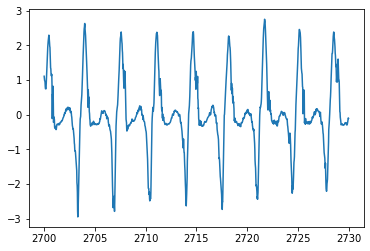

In [234]:
plt.plot(acc.ewm(alpha=0.2).mean())

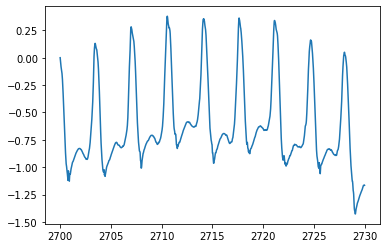

In [220]:
plt.plot(
    pd.Series(
        integrate.cumtrapz(
            acc_x.loc[s], acc_x.loc[s].index, initial=0
        ), 
        acc_x.loc[s].index, 
    )
)

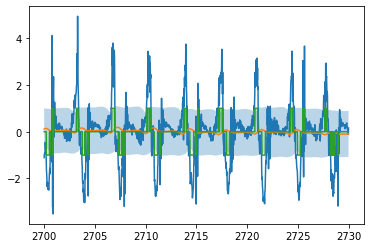

In [218]:
s = slice(2700, 2730)

plt.plot(
    acc_x.loc[s]
)
plt.plot(avg_filter.loc[s])
plt.fill_between(
    avg_filter.loc[s].index, 
    avg_filter.loc[s] + std_filter.loc[s], 
    avg_filter.loc[s] - std_filter.loc[s], 
    alpha=0.3
)

plt.plot(signals.loc[s])

# plt.plot(
#     signals.loc[s]
# )

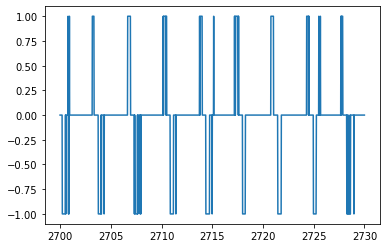

In [219]:
plt.plot(
    signals.loc[s]
)

## Checking acceleration profile

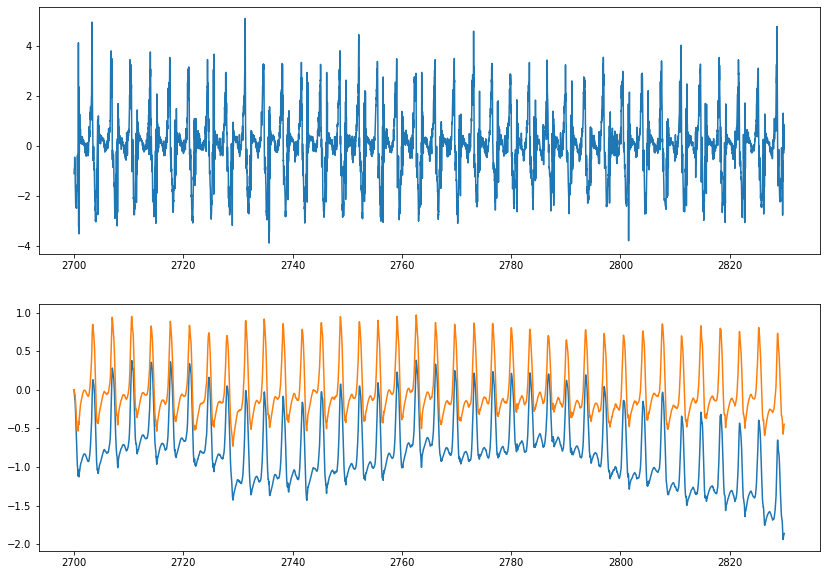

In [6]:
s = slice(2700, 2830)
# s = slice(2000, 4000)
f, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
times, acc = acc_x.loc[s].index.values, acc_x.loc[s].values 

vel = pd.Series(
    integrate.cumulative_trapezoid(acc, times, initial=0),
    index=times
)
s_vel = vel - vel.ewm(alpha=1e-2).mean()
ax1.plot(times, acc) 
ax2.plot(times, vel)
ax2.plot(times, s_vel)

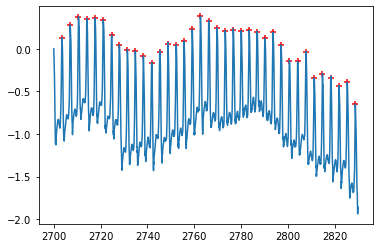

In [7]:
peaks, peak_data = signal.find_peaks(acc, height=3000, distance=70)
peaks, peak_data = signal.find_peaks(s_vel, height=0.2, distance=70)

plt.plot(times, vel)
plt.scatter(times[peaks], vel.iloc[peaks], c='r', marker='+')

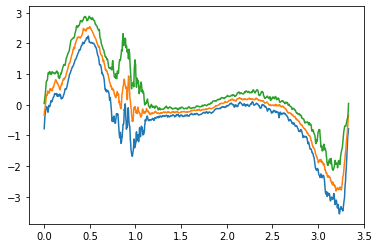

In [8]:
n_interp = 1000
profiles = np.zeros(
    (len(peaks) - 1, n_interp)
)
for j, (i0, i1) in enumerate(np.c_[peaks[:-1], peaks[1:]]):
    profiles[j, :] = np.interp(
        np.linspace(0, 1, n_interp), 
        np.linspace(0, 1, i1 - i0 + 1), 
        acc[i0:i1 + 1]
    )

plt.plot(
    np.linspace(0, 60/18, n_interp),
    np.quantile(-profiles, [0.1,0.5,0.9], axis=0).T
)
# plt.plot(-profiles.mean(0))
# plt.plot(
#     - profiles.mean(0)
#     # -np.roll(profiles.mean(0), 500)
# )

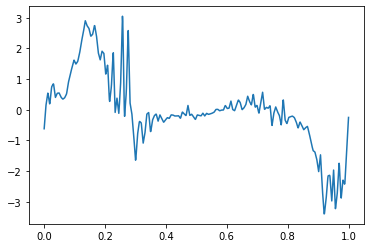

In [160]:
plt.plot(x, -profiles[1])

In [9]:
from scipy import optimize

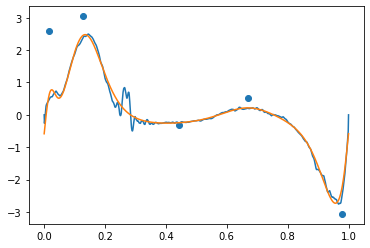

In [151]:
def periodic(v, box=1):
    return v - np.round(v / box) * box

def logistic(x, A, mean, logscale, box=1):
    # diff = np.c_[mean - box, mean, mean + box] - x[:, None]
    diff = periodic(mean - x, box)
    s = np.exp(logscale)
    diff /= s
    expx = np.exp(diff)
    return A * 4 * (expx / (1 + expx)**2)

def logistics(x, *params, box=1):
    return sum(
        logistic(x, *args, box=box) for args in zip(*[iter(params)]*3)
    )

def logistic_1(x, A, mean, logscale, box=1, x0=None):
    # diff = np.c_[mean - box, mean, mean + box] - x[:, None]
    diff = mean - x
    shift = np.round(diff / box)
    diff -= shift * box
    s = np.exp(logscale)
    x0 = x[0] if x0 is None else x0
    d0 = mean - x0
    i0 = np.round(d0 / box)
    d0 -= i0 * box

    A4s = A * 4 * s
    inta = A4s / (1 + np.exp(diff/s))
    int0 = A4s / (1 + np.exp(d0/s))
    intr1 = A4s / (1 + np.exp(- box/s/2))
    intr2 = A4s / (1 + np.exp(box/s/2))
    
    return inta - int0 - (shift - i0) * (intr1 - intr2)

def logistics_1(x, *params, box=1):
    return sum(
        logistic_1(x, *args, box=box) for args in zip(*[iter(params)]*3)
    )

peaks = np.r_[27, 134, 400, 700, 961]
x = np.linspace(0, 1, n_interp)
y = - profiles.mean(0)
y_std = profiles.std(0)
y[0] = y[-1] = 0.

p0 = np.c_[
    y[peaks], 
    peaks/n_interp, 
    np.full_like(peaks, -4)
]

# plt.plot(x, logistics(x, *p0.ravel(), box=1.))

popt, pcov = optimize.curve_fit(
    logistics, x, y, p0=p0.ravel(), 
)
As, ms, logT = popt.reshape(-1, 3).T

plt.plot(x, y)
plt.plot(x, logistics(x, *popt, box=1.))
plt.scatter(ms, As)

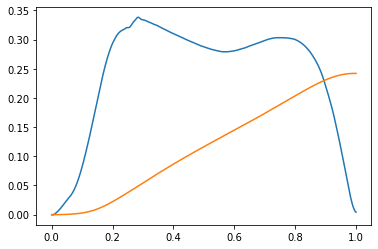

In [154]:
x = np.linspace(0, 1, 1000)
y1 = integrate.cumtrapz(y, x, initial=0)
y2 = integrate.cumtrapz(y1, x, initial=0)
plt.plot(x, y1)
plt.plot(x, y2)

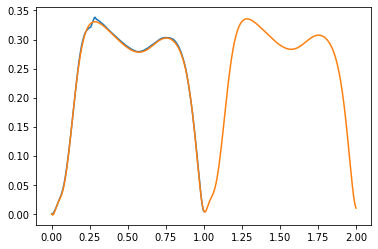

In [152]:
x = np.linspace(0, 1, 1000)
plt.plot(x, integrate.cumtrapz(y, x, initial=0))
x = np.linspace(0, 2, 2000)
plt.plot(x, logistics_1(x, *popt, box=1.))

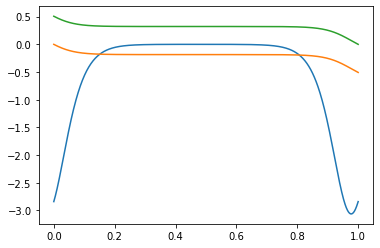

In [129]:
    A, mean, logscale = popt[-3:]
    box = 1

    a0 = logistics(x, A, mean, logscale, box=box)
    a1i = integrate.cumtrapz(a0, x, initial=0)
    a1 = logistics_1(x, A, mean, logscale, box=box)

    plt.plot(x, a0)
    plt.plot(x, a1i)
    plt.plot(x, a1)

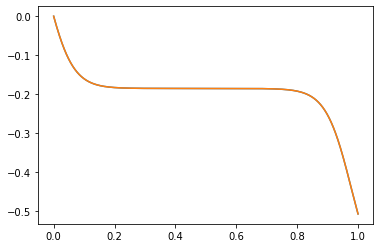

In [138]:

    diff = mean - x
    shift = np.round(diff / box)
    diff -= shift * box
    s = np.exp(logscale)
    i0 = shift[0]

    A4s = A * 4 * s
    inta = A4s / (1 + np.exp(diff/s))
    int0 = A4s / (1 + np.exp((mean - i0 * box)/s))
    intr1 = A4s / (1 + np.exp(- box/s/2))
    intr2 = A4s / (1 + np.exp(box/s/2))

    
    # plt.plot(x, a0)
    plt.plot(x, a1i)
    # plt.plot(x, inta - int0)
    plt.plot(x, inta - int0 - (shift - i0) * (intr1 - intr2))

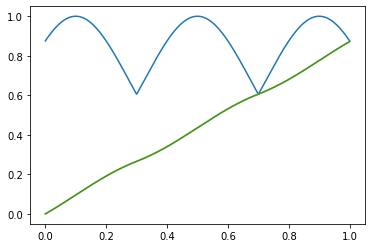

In [108]:
if 1:
    A, mean, logscale, box = 1, 0.1, -2, 0.4
    
    a0 = logistics(x, A, mean, logscale, box=box)
    a1 = integrate.cumtrapz(a0, x, initial=0)

    # diff = np.c_[mean - box, mean, mean + box] - x[:, None]
    diff = mean - x
    shift = np.round(diff / box)
    diff -= shift * box
    s = np.exp(logscale)

    A4s = A * 4 * s
    inta = A4s / (1 + np.exp(diff/s))
    int0 = A4s / (1 + np.exp(mean/s))
    intr1 = A4s / (1 + np.exp(- box/s/2))
    intr2 = A4s / (1 + np.exp(box/s/2))

    plt.plot(x, a0)
    plt.plot(x, a1)
    # plt.plot(x, inta - int0)
    plt.plot(x, inta - int0 - shift * (intr1 - intr2))
    # plt.plot(x, - shift * (intr1 - int0))
    # plt.plot(x, - shift * (intr2 - int0))
    # plt.plot(x, - shift * (intr1 - intr2))
    # plt.plot(x, A * 4 * s / (1 + exps))

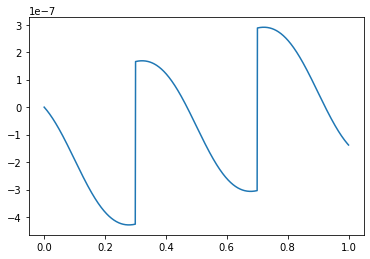

In [109]:

    plt.plot(x, a1 - (inta - int0 - shift * (intr1 - intr2)))

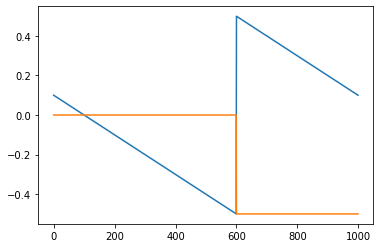

In [59]:
plt.plot(diff)
plt.plot(shift / 2)

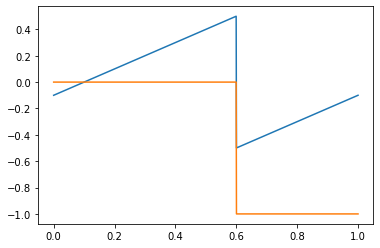

In [34]:
diff = mean - x
shift = np.round(diff / box)
diff -= shift * box
plt.plot(x, - diff)
plt.plot(x, shift)

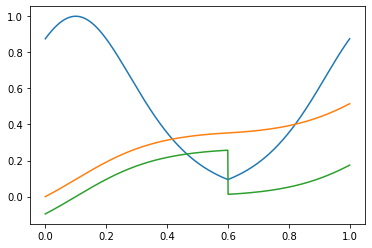

In [12]:
a0 = logistics(x, 1, 0.1, -2, -1, 0.7, -2)
a0 = logistics(x, 1, 0.1, -2)
a1 = integrate.cumtrapz(a0, x, initial=0)
a2 = integrate.cumtrapz(a1, x, initial=0)
plt.plot(x, a0)
plt.plot(x, a1)
plt.plot(x, logistic_1(x, 1, 0.1, -2))
# plt.plot(x, np.round((0.1 - x) / 1))

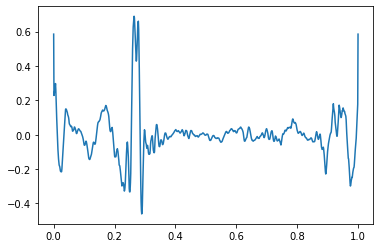

In [85]:

plt.plot(x, y - logistics(x, *popt, box=1.))

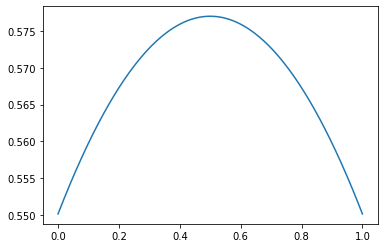

In [84]:
    A, mean, logscale, box = 1, 0.5, -.3, 1.

    diff = np.c_[mean - box, mean, mean + box] - x[:, None]
    # diff -= np.round(diff / box)
    s = np.exp(logscale)
    diff /= s
    expx = np.exp(diff)

    plt.plot(x, (expx / (1 + expx)**2).sum(1))


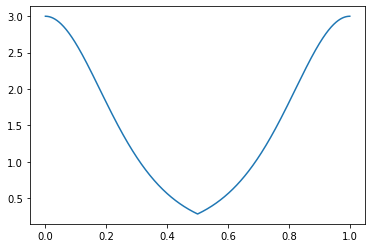

In [65]:
def logistic(x, A, mean, logscale, box=1):
    diff = np.c_[mean - box, mean, mean + box] - x[:, None]
    # diff = mean - x
    diff -= np.round(diff / box)
    s = np.exp(logscale)
    diff /= s
    expx = np.exp(diff)
    return A * 4 * (expx / (1 + expx)**2).sum(1)
    
plt.plot(x, logistic(x, 1, 0., -2, box=1.))

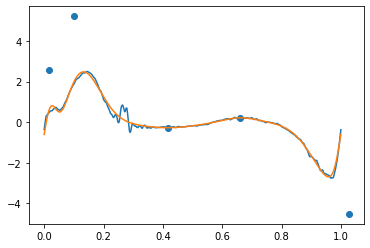

In [35]:
def gaussian(x, A, mean, logprec, box=1):
    diff = x - mean
    diff -= np.round(diff / box)
    return A * np.exp(- np.square(diff) * np.exp(logprec))

def gaussians(x, *params, box=1):
    return sum(
        gaussian(x, *args, box=box) for args in zip(*[iter(params)]*3)
    )

peaks = np.r_[27, 134, 400, 700, 961]
avg_profile = - profiles.mean(0)

p0 = np.c_[
    avg_profile[peaks], 
    peaks/n_interp, 
    np.full_like(peaks, 5)
]

x = np.linspace(0, 1, n_interp)
y = - profiles.mean(0)
y_std = profiles.std(0)
y[0] = y[-1] = 0.

popt, pcov = optimize.curve_fit(
    gaussians, x, y, p0=p0.ravel(), 
    # sigma=y_std + 0.01
)
As, ms, logT = popt.reshape(-1, 3).T

plt.plot(x, avg_profile)
plt.plot(x, gaussians(x, *popt, box=1.))
plt.scatter(ms, As)

## Observed state

$$\begin{align*}
& \mathbf{a} = \{a_x, a_y, a_z\}, & \text{acceleration in recorder frame}
\\
& \boldsymbol{\omega} = \{\omega_x, \omega_y, \omega_z\}, & \text{angular acceleration in recorder frame}
\\
& \phi, & \text{latitude}
\\
& \theta, & \text{longitude}
\\
& v, & \text{horizontal speed}
\\
& \beta & \text{bearing}
\end{align*}$$


$$\mathbf{y}_t = \{\mathbf{a}, \boldsymbol{\omega}, \phi, \theta, v, \beta\}$$



## System State

at time, $t_k$, define system state,

$$\begin{align*}
& \phi_k & \text{latitude}
\\
& \theta_k & \text{longitude}
\\
& v^0_k & \text{average horizontal speed}
\\
& b_k & \text{bearing}
\\ & 
n_k & \text{total stroke phase}
\\ & 
s_k & \text{stroke rate}
\\ & 
\mathbf{c}_k = \{c^1_k,  c_k^2, ...\} & \text{stroke acceleration amplitudes}
\\ & 
\mathbf{d}_k = \{d_k^1,  d_k^2, ...\} & \text{stroke acceleration amplitudes}
\\ & 
\mathbf{e}_k = \{e_k^x, e_k^y, e_k^z\} & \text{recorder euler angles}
\\ & 
\mathbf{f}_k = \{r_k^x, r_k^y, r_k^z\} & \text{acceleration axes 0 offset}
\\ & 
\mathbf{r}_k = \{r_k^x, r_k^y, r_k^z\} & \text{acceleration axes scales}
\\ & 
\mathbf{g}_k = \{g_k^x, g_k^y, g_k^z\} & \text{gyro 0 offset}
\end{align*}$$

## Dynamical Model 

Define the transition model, 

$$\begin{align*}
\Delta t &= t_{k+1} - t_k
\\
n_{k + 1} &= n_{k} + s \Delta t
\\
a_{k + 1} &= \sum_j 
c_j \cos(2\pi j n_{k + 1})
+ d_j \sin(2\pi j n_{k + 1}) 
\\
v_{k + 1} &= v_0 + \sum_j \left(
\frac{c_j}{2\pi j s} \sin(2\pi j n_{k + 1}) 
- \frac{d_j}{2\pi j s} \cos(2\pi j n_{k + 1})
\right)
\\t
\Delta x_k &= v_0 \Delta t - \sum_j \left(
\frac{c_j}{(2\pi j s)^2} \cos(2\pi j n_{k + 1}) 
+ \frac{d_j}{(2\pi j s)^2} \sin(2\pi j n_{k + 1})
\right. \\
& \left.
- \frac{c_j}{(2\pi j s)^2} \cos(2\pi j n_{k}) 
- \frac{d_j}{(2\pi j s)^2} \sin(2\pi j n_{k})
\right) 
\\
\delta_k &= \frac{\Delta x_k}{R_\text{earth}}
\\
\phi_{k+1} &= 
\arcsin\left(
    \sin \phi_k \cos \delta_k + \cos \phi_k \sin \delta_k \cos \beta_k
\right)
\\
\theta_{k+1} &=
\theta_k + \arctan2(
    \sin \beta_k \sin \delta_k \cos \phi_k, \cos \delta_k - \sin \phi_k \sin \phi_{k+1}
)
\\
s_{k+1}, b_{k+1} &= s_k, b_{k}
\\
\mathbf{c}_{k+1}, \mathbf{d}_{k+1}
&= 
\mathbf{c}_{k}, \mathbf{d}_{k}
\\
\mathbf{e}_{k+1}, \mathbf{r}_{k+1}, \mathbf{g}_{k+1}
&= 
\mathbf{e}_{k}, \mathbf{r}_{k}, \mathbf{g}_{k}
\end{align*}$$

## Dynamical Model 

Define the transition model, 

$$\begin{align*}
\Delta t &= t_{k+1} - t_k
\\
n_{k + 1} &= n_{k} + s \Delta t
\\
a_{k + 1} &= \sum_j c_j \sin(2\pi j n_{k + 1} + \phi_j), \phi_1 = 0 
\\
v_{k + 1} &= v_0 + \sum_j \left(
- \frac{c_j}{2\pi j s} \cos(2\pi j n_{k + 1} + \phi_j)
\right)
\\t
\Delta x_k &= v_0 \Delta t + \sum_j 
\frac{c_j}{(2\pi j s)^2}
\left( \sin(2\pi j n_{k + 1} + \phi_j) - \sin(2\pi j n_{k} + \phi_j) 
\right) 
\\
\delta_k &= \frac{\Delta x_k}{R_\text{earth}}
\\
\phi_{k+1} &= 
\arcsin\left(
    \sin \phi_k \cos \delta_k + \cos \phi_k \sin \delta_k \cos \beta_k
\right)
\\
\theta_{k+1} &=
\theta_k + \arctan2(
    \sin \beta_k \sin \delta_k \cos \phi_k, \cos \delta_k - \sin \phi_k \sin \phi_{k+1}
)
\\
s_{k+1}, b_{k+1} &= s_k, b_{k}
\\
\mathbf{c}_{k+1}, \mathbf{d}_{k+1}
&= 
\mathbf{c}_{k}, \mathbf{d}_{k}
\\
\mathbf{e}_{k+1}, \mathbf{r}_{k+1}, \mathbf{g}_{k+1}
&= 
\mathbf{e}_{k}, \mathbf{r}_{k}, \mathbf{g}_{k}
\end{align*}$$


## Observation Model
Defining the dense rotation matrix from the set of Euler angles, 
$$\boldsymbol{O}(d_1, d_2, d_3) = \\
\begin{bmatrix} 
\cos d_1\cos d_3-\cos d_2\sin d_1\sin d_3&-\cos d_1\sin d_3-\cos d_2\cos d_3\sin d_1&\sin d_1\sin d_2
\\
\cos d_3\sin d_1+\cos d_1\cos d_2\sin d_3&\cos d_1\cos d_2\cos d_3-\sin d_1\sin d_3&-\cos d_1\sin d_2
\\
\sin d_2\sin d_3&\cos d_3\sin d_2&\cos d_2
\end{bmatrix}$$

We can then define the observation model

$$\begin{align*}
\mathbf{a} &=
\text{diag}(\boldsymbol{r}) \cdot \boldsymbol{O}(d_1, d_2, d_3) \cdot [a_t, 0, g] + \boldsymbol{\epsilon}_a
\\
\phi &= \phi_t + \boldsymbol{\epsilon}_\phi
\\
\theta &= \theta_t + \boldsymbol{\epsilon}_\theta
\\
v &= v_t + \boldsymbol{\epsilon}_v
\\
\beta &= \beta_t + \boldsymbol{\epsilon}_\beta
\end{align*}$$

where
$$
\boldsymbol{\epsilon}_\kappa \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma}_\kappa)
$$

Is the observation noise

In [9]:
from scipy import integrate, stats, signal 

from filterpy.kalman import (
    UnscentedKalmanFilter as UKF, 
    MerweScaledSigmaPoints as MSSP
)

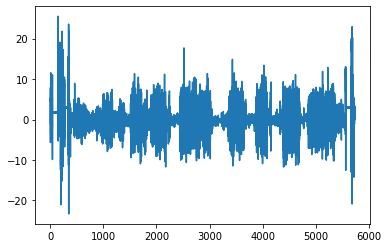

In [133]:
plt.plot(accel_data.dot(y) * acc_scale)

In [138]:
acc_x.diff().var()

0.42691091632220585

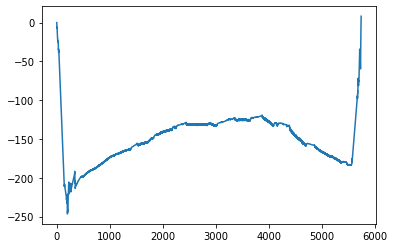

In [172]:
acc_x = accel_data.dot(x) * acc_scale

vel_x = pd.Series(
    integrate.cumulative_trapezoid(acc_x, acc_x.index, initial=0),
    index=acc_x.index
)
activity_speed = activity.set_index("timestamp").speed
gps_speed = valid_gps_data.Speed_over_ground * 1000 / 3600

plt.plot(vel_x)

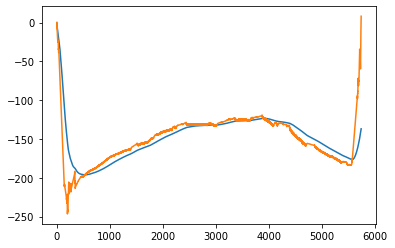

In [206]:
plt.plot(vel_x.ewm(alpha=1e-4).mean())
plt.plot(vel_x)

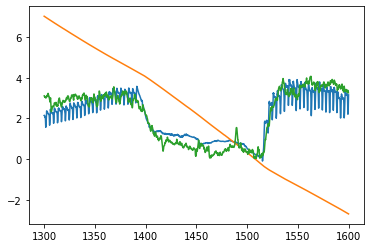

In [209]:
s = slice(1300, 1600)
vel = - vel_x.loc[s]
vm = - vel_x.ewm(alpha=1e-4).mean().loc[s]
v = vel - vm
speed = gps_speed.loc[s]
plt.plot(v - v.mean() + speed.mean())
plt.plot(vm - vm.mean() + speed.mean())
plt.plot(speed)
# plt.plot(vel - vel.mean() + speed.mean())

In [232]:
v.groupby(pd.cut(v.index, speed.index)).mean()

(1300.072, 1300.47]    -7.131117
(1300.47, 1300.668]    -7.157302
(1300.668, 1300.869]   -7.201382
(1300.869, 1301.068]   -7.217943
(1301.068, 1301.273]   -7.261075
                          ...   
(1598.867, 1599.068]   -6.217310
(1599.068, 1599.266]   -6.565455
(1599.266, 1599.466]   -7.007116
(1599.466, 1599.669]   -6.952543
(1599.669, 1599.866]   -6.646261
Length: 1473, dtype: float64

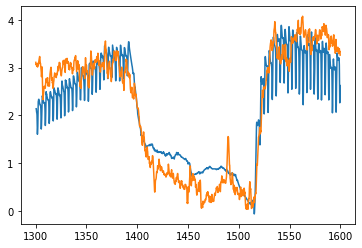

In [230]:
mean_v = v.groupby(pd.cut(v.index, speed.index)).mean()
mean_v.index = speed.index[1:]
plt.plot(mean_v - mean_v.mean() + speed.mean())
plt.plot(speed)

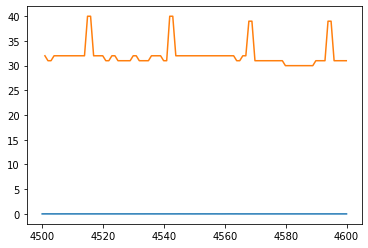

In [127]:
acc_x = accel_data.dot(x) * acc_scale
stroke_rates = activity.set_index('timestamp').cadence 

time_gap = slice(4500, 4600)

ts = np.linspace(acc_x.index[0], acc_x.index[-1], acc_x.size)
dt = ts[1] - ts[0]
acc = np.interp(
    ts,  
    acc_x.index, 
    acc_x 
)

plt.plot(acc_x.loc[time_gap] / 1e3)
plt.plot(stroke_rates.loc[time_gap])

NameError: name 'acc_x' is not defined

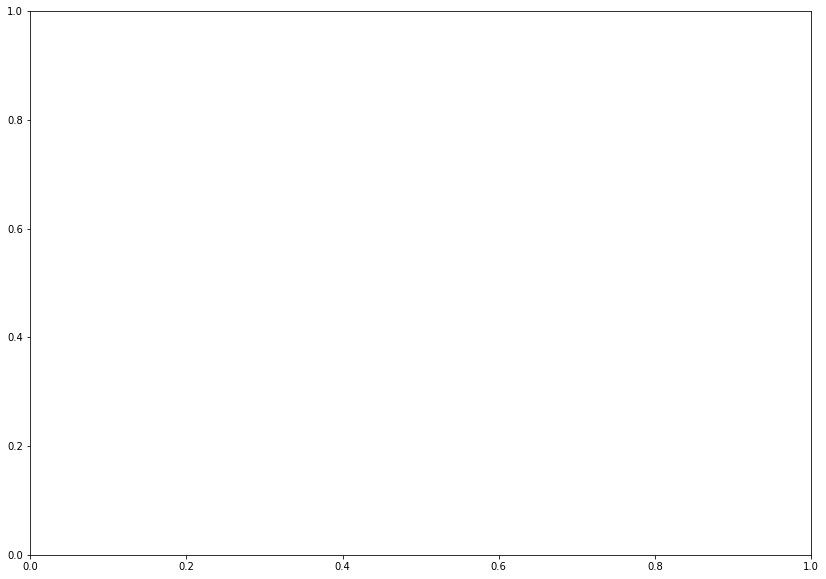

In [8]:
s = slice(2700, 2830)
# s = slice(2000, 4000)
f, ax = plt.subplots(figsize=(14, 10))
times, acc = acc_x.loc[s].index.values, acc_x.loc[s].values 
plt.plot(times, acc) 

In [7]:
vel = integrate.cumtrapz(acc, times, initial=0)
vel -= pd.Series(vel).ewm(alpha=0.001).mean()
peaks, peak_data = signal.find_peaks(vel, height=500, distance=70)

plt.plot(times, vel)
plt.scatter(times[peaks], vel[peaks], c='r', marker='+')

NameError: name 'acc' is not defined

In [236]:
acc_peaks = acc > 2000

0

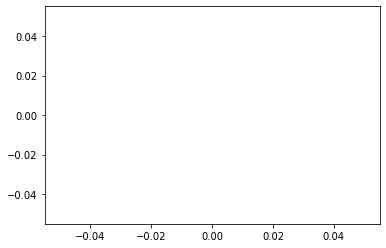

In [237]:
s0, = (np.diff(acc_peaks * 1) == 1).nonzero()
s1, = (np.diff(acc_peaks * 1) == -1).nonzero()
peak_widths = times[s1] - times[s0]

min_width = 0.1

plt.plot(np.sort(times[s1] - times[s0]))
w0 = s0[peak_widths > min_width]
w0 = w0[(np.diff(times[w0]) > 0.5).nonzero()]
w1 = s1[peak_widths > min_width]
w1 = w1[(np.diff(times[w1]) > 0.5).nonzero()]
w0.size 

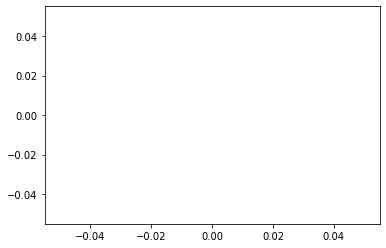

In [238]:
plt.plot(times[w1] - times[peaks[:-1]])

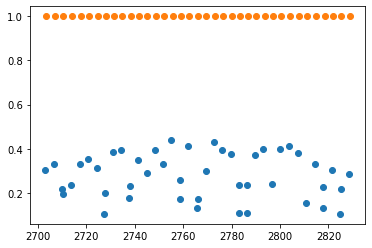

In [67]:
plt.scatter(times[w0], times[w1] - times[w0])
plt.scatter(times[peaks], np.ones_like(peaks))

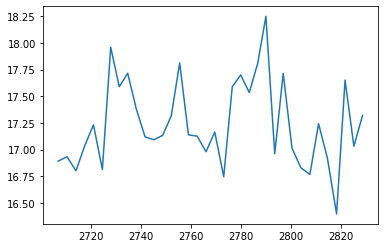

In [36]:
plt.plot(times[peaks[1:]], 60 / np.diff(times[peaks]))

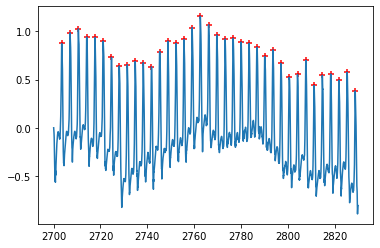

In [243]:
peaks, peak_data = signal.find_peaks(acc, height=3000, distance=70)
peaks, peak_data = signal.find_peaks(vel, height=0.2, distance=70)

plt.plot(times, vel )
plt.scatter(times[peaks], vel[peaks], c='r', marker='+')

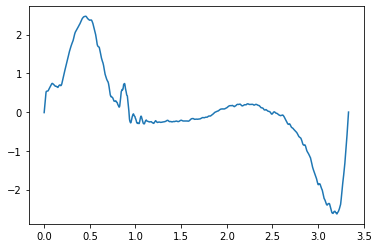

In [247]:
n_interp = 1000
profiles = np.zeros(
    (len(peaks) - 1, n_interp)
)
for j, (i0, i1) in enumerate(np.c_[peaks[:-1], peaks[1:]]):
    profiles[j, :] = np.interp(
        np.linspace(0, 1, n_interp), 
        np.linspace(0, 1, i1 - i0 + 1), 
        acc[i0:i1 + 1]
    )

# plt.plot(-profiles.mean(0))
plt.plot(
    np.linspace(0, 60/18, n_interp),
    - profiles.mean(0)
    # -np.roll(profiles.mean(0), 500)
)

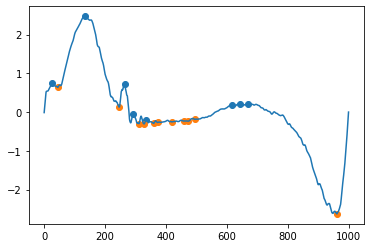

In [257]:
avg_profile = -profiles.mean(0)
prof_peak, _ = signal.find_peaks(avg_profile, width=10)
prof1_peak, _ = signal.find_peaks(-avg_profile, width=10)

t = np.linspace(0, 60/18, n_interp)
t = np.arange(n_interp)
plt.plot(t, avg_profile)
plt.scatter(t[prof_peak], avg_profile[prof_peak])
plt.scatter(t[prof1_peak], avg_profile[prof1_peak])

In [263]:
from scipy import interpolate

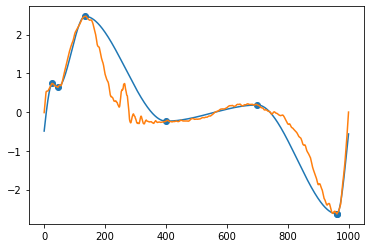

In [349]:
peaks = np.r_[961 - n_interp, 27, 45, 134, 400, 700, 961]
y = avg_profile[peaks]
dy = np.zeros_like(y)
spline = interpolate.CubicHermiteSpline(
    peaks, y, dy, extrapolate='periodic'
)

plt.plot(t, spline(t))
plt.scatter(t[peaks], avg_profile[peaks])
plt.plot(t, avg_profile)

In [294]:
from scipy import optimize

In [340]:
def gaussian(x, A, mean, logprec, box=1):
    diff = x - mean
    diff -= np.round(diff / box)
    return A * np.exp(- np.square(diff) * np.exp(logprec))

def gaussians(x, *params, box=1):
    return sum(
        gaussian(x, *args, box=box) for args in zip(*[iter(params)]*3)
    )

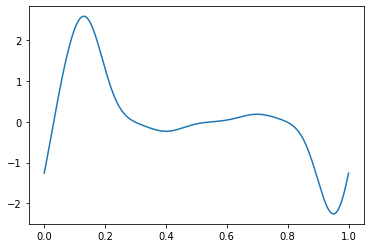

In [353]:
peaks = np.r_[27, 134, 400, 700, 961]

p0 = np.c_[
    avg_profile[peaks], 
    peaks/n_interp, 
    np.full_like(peaks, 5)
]
x = np.linspace(0, 1, n_interp)
plt.plot(x, gaussians(x, *p0.ravel(), box=1.))


y = - profiles.mean(0)
y_std = profiles.std(0)
y[0] = y[-1] = 0.
popt, pcov = optimize.curve_fit(
    gaussians, x, y, p0=p0.ravel(), 
    # sigma=y_std + 0.01
)
As, ms, logT = popt.reshape(-1, 3).T

plt.plot(x, avg_profile)
plt.plot(x, gaussians(x, *popt, box=1.))
plt.scatter(ms, As)

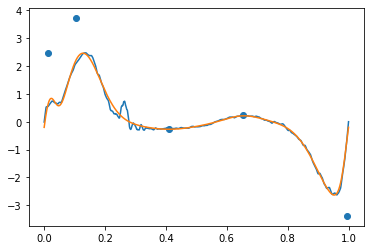

In [355]:
y = - profiles.mean(0)
y_std = profiles.std(0)
y[0] = y[-1] = 0.
popt, pcov = optimize.curve_fit(
    gaussians, x, y, p0=p0.ravel(), 
    # sigma=y_std + 0.01
)
As, ms, logT = popt.reshape(-1, 3).T

plt.plot(x, avg_profile)
plt.plot(x, gaussians(x, *popt, box=1.))
plt.scatter(ms, As)

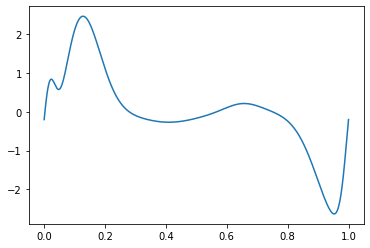

In [356]:
plt.plot(x, gaussians(x, *popt, box=1.))

In [261]:
spline = interpolate.CubicHermiteSpline(
    t[peaks], 
    y,
    bc_type='periodic',
)

array([ 27, 134, 618, 643, 668,  45, 961])

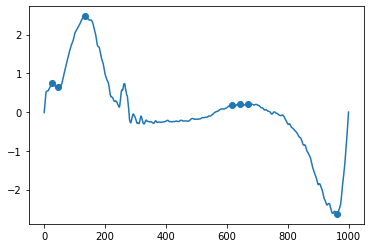

In [260]:
peaks = np.r_[prof_peak, prof1_peak]
peaks = peaks[(peaks > 600) | (peaks < 200)]
plt.plot(t, avg_profile)
plt.scatter(t[peaks], avg_profile[peaks])

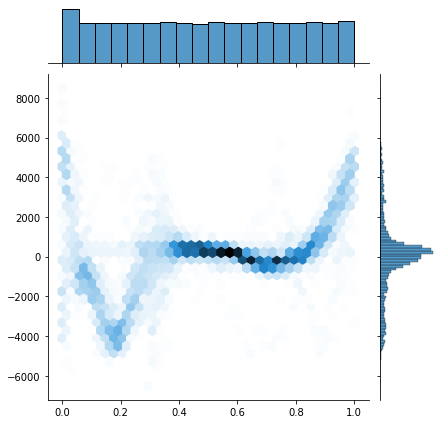

In [64]:
phase = np.zeros_like(acc)
stroke_times = np.zeros_like(peaks, dtype=float)
for i0, i1 in np.c_[peaks[:-1], peaks[1:]]:
    # dt = times[i1] - times[i0]
    phase[i0:i1] = np.linspace(0, 1, i1-i0)

sns.jointplot(x=phase, y=acc, kind='hex')

In [55]:
def build_harmonics(freq, t, harms):
    return jnp.concatenate([
        jnp.ones((1, len(t))), 
        jnp.sin(freq * harms[:, None] * t[None, :]),
        jnp.cos(freq * harms[::-1, None] * t[None, :]),
    ])

@jax.jit 
def fit_harmonic(freq, t, x, harms):
    t = jnp.array(t)
    x = jnp.array(x) 
    # harms = np.arange(1, n + 1)
    n_data = t.size 
    A = build_harmonics(freq, t, harms)
    LLT = jax.scipy.linalg.cho_factor(A.dot(A.T))
    f = jax.scipy.linalg.cho_solve(LLT, A.dot(x))

    return f

fit_harmonics = jax.vmap(fit_harmonic, (0, None, None, None))

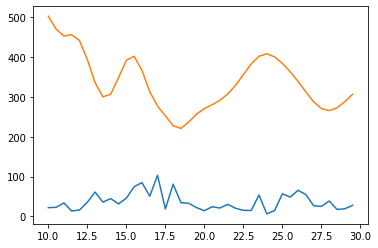

In [53]:
n_coefs = 3 

rates = np.arange(10, 30, 0.5)
freqs = 2 * np.pi * rates / 60
harms = np.arange(1, 3)
n_harms = harms.size 
n_freqs = rates.size
n_times = times.size 

A = np.concatenate([
    np.ones((n_freqs, 1, n_times)), 
    np.sin(freqs[:, None, None] * harms[None, :, None] * times[None, None, :]), 
    np.cos(freqs[:, None, None] * harms[None, :, None] * times[None, None, :]),
], axis=1)

AAT = np.einsum("ijk,ilk->ijl", A, A)
Ax = A.dot(acc)
coefs = np.linalg.solve(AAT, Ax)
plt.plot(rates.ravel(), np.linalg.norm(coefs[:, 1:], axis=1)) 

e = 1e-2
w = (1 - e) ** np.arange(n_times)[::-1]
AWAT = np.einsum("ijk,k,ilk->ijl", A, w, A)
AWy = A.dot(w * acc)
coefs = np.linalg.solve(AWAT, AWy)
plt.plot(rates.ravel(), np.linalg.norm(coefs[:, 1:], axis=1)) 


In [141]:
def _exp_rolling_lombscargle(carry, xt):
    AAT, Ax, t0, freqs, harms, alpha = carry
    n_freqs = len(freqs)
    t, x = xt
    dt = t - t0
    e1 = 1 - dt * alpha 
    AAT = AAT * e1 
    Ax = Ax * e1 
    
    a = jnp.c_[
        jnp.ones((n_freqs, 1)), 
        jnp.sin(freqs[:, None] * harms[None, :] * t), 
        jnp.cos(freqs[:, None] * harms[None, :] * t)
    ]
    AAT1 = AAT * e1 + a[:, None, :] * a[:, :, None]
    Ax1 = Ax * e1 + a * t * x
    coefs = jnp.linalg.solve(AAT, Ax)
    return (AAT1, Ax1, t, freqs, harms, alpha), coefs

def exp_rolling_lombscargle(times, acceleration, freqs, n_harms, alpha=1e-1):
    n_freqs = len(freqs)
    harms = np.arange(1, n_harms + 1)
    xt = jnp.c_[times, acceleration]
    AAT = jnp.concatenate([
        jnp.eye(2 * n_harms + 1)[None, ...] for i in range(n_freqs)
    ])
    Ax = jnp.zeros((n_freqs, 2 * n_harms + 1))
    init = (AAT, Ax, times[0], freqs, harms, alpha)
    carry, coefs = jax.lax.scan(
        _exp_rolling_lombscargle, init, xt
    )
    return coefs
    

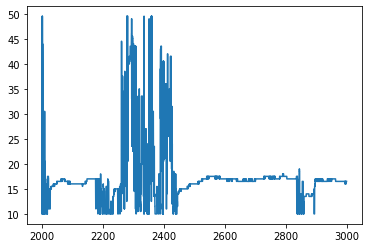

In [143]:
t0, t1 = 2000, 3000
times, acc = acc_x.loc[t0:t1].index.values, acc_x.loc[t0:t1].values 
rates = np.arange(10, 50, 0.5)
freqs = 2 * np.pi * rates / 60
n_harms = 5
coefs = exp_rolling_lombscargle(times, acc, freqs, n_harms, 1e-1)

power = pd.DataFrame(
    np.linalg.norm(np.array(coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

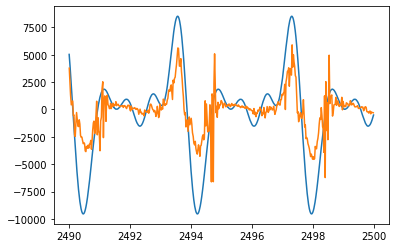

In [71]:
t0, t1 = 2490, 2500
i = times.searchsorted(t1)
j = power.values[times.searchsorted(t1)].argmax()

coef = coefs[i, j]
freq = freqs[j]

ts = np.linspace(t0, t1, 2**14)

basis = build_harmonics(
    freq, ts, np.arange(1, n_harms + 1)
)

plt.plot(ts, coef.dot(basis)/1e3)
plt.plot(acc_x.loc[t0:t1])

In [123]:
def build_int_harmonics(freq, t, harms):
    freq_harms = freq * harms[:, None]
    return jnp.concatenate([
        jnp.ones((1, len(t))) * t, 
        - jnp.cos(freq_harms * t[None, :]) / freq_harms,
        jnp.sin(freq_harms[::-1] * t[None, :]) / freq_harms[::-1],
    ])

def build_iint_harmonics(freq, t, harms):
    freq_harms = freq * harms[:, None]
    return jnp.concatenate([
        jnp.ones((1, len(t))) * t * t / 2, 
        - jnp.sin(freq_harms * t[None, :]) / freq_harms**2,
        - jnp.cos(freq_harms[::-1] * t[None, :]) / freq_harms[::-1]**2,
    ])

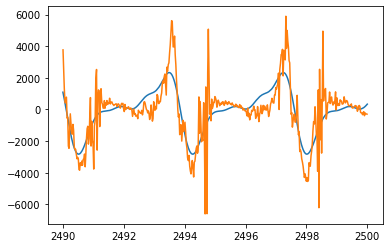

In [124]:
plt.plot(ts, coef.dot(basis)/1e3)
plt.plot(acc_x.loc[t0:t1])

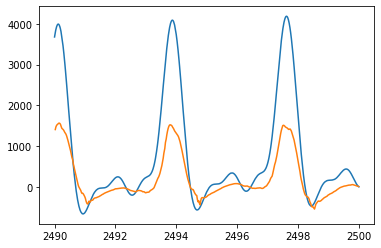

In [125]:
i_basis = build_int_harmonics(freq, ts, np.arange(1, n_harms + 1))
x, t = acc_x.loc[t0:t1].values[::-1], acc_x.loc[t0:t1].index[::-1]

v = coef.dot(i_basis)/1e3

plt.plot(ts, v - v[-1])
plt.plot(
    t[:-1], 
    integrate.cumtrapz(x, t),
)

In [136]:
integrate.cumulative_trapezoid(x, t, initial=1000).size

457

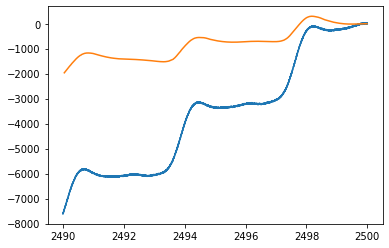

In [132]:
x, t = acc_x.loc[t0:t1].values[::-1], acc_x.loc[t0:t1].index[::-1]
ii_basis = build_iint_harmonics(freq, ts, np.arange(1, n_harms + 1))

iv = coef.dot(ii_basis) / 1e3 - v[-1] * ts
plt.plot(ts, iv - iv[-1])
plt.plot(
    t[:-2], 
    integrate.cumtrapz(
        integrate.cumtrapz(x, t),
        t[:-1]
    )
)

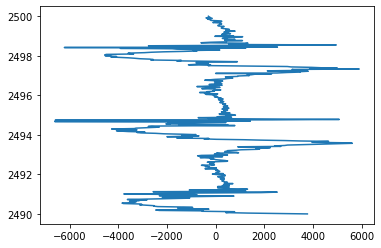

In [75]:
plt.plot(acc_x.loc[t0:t1], acc_x.loc[t0:t1].index)

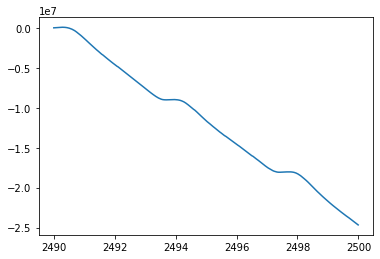

In [73]:
plt.plot(acc_x.loc[t0:t1].cumsum().cumsum())

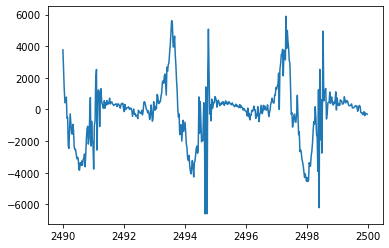

In [65]:
plt.plot(acc_x.loc[t0:t1])

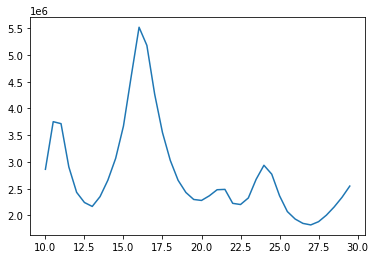

In [45]:
plt.plot(power.loc[2500:].iloc[0])

In [39]:
coefs.shape

(248305, 40, 7)

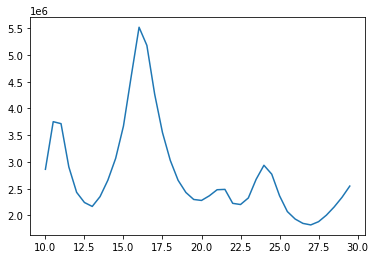

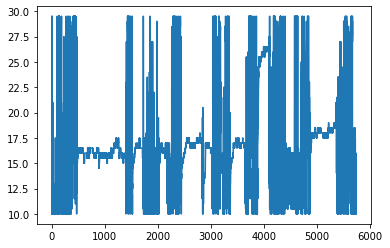

In [36]:
power = pd.DataFrame(
    np.linalg.norm(np.array(coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

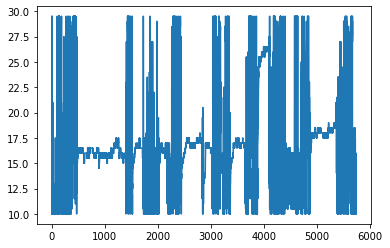

In [14]:
times, acc = acc_x.loc[:].index.values, acc_x.loc[:].values 
# plt.plot(times, acc) 

n_coefs = 3

rates = np.arange(10, 30, 0.5)
harms = np.arange(1, n_coefs + 1)

n_harms = harms.size
n_freqs = rates.size

e = 1e-1
e1 = 1 - e

freqs = 2 * np.pi * rates / 60
AAT = np.concatenate([
    np.eye(2 * n_coefs + 1)[None, ...] for i in range(n_freqs)
])
Ax = np.zeros((n_freqs, 2 * n_coefs + 1))

init = (AAT, Ax, times[0], freqs, harms, 1e-1)

carry, coefs = jax.lax.scan(
    exp_rolling_lombscargle, 
    init, 
    np.c_[times, acc]
)

power = pd.DataFrame(
    np.linalg.norm(np.array(coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

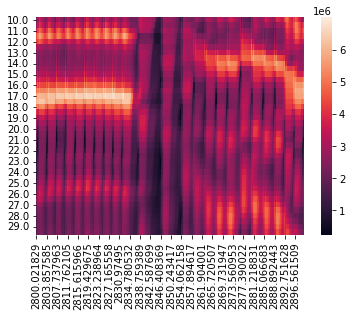

In [18]:
sns.heatmap(power.loc[s].T)

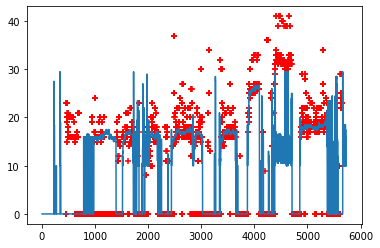

In [15]:
est_rate = power.idxmax(1)
est_rate[power.max(1) < 1e6] = 0
plt.plot(est_rate)
plt.scatter(
    stroke_rates.index, 
    stroke_rates, 
    marker='+',
    c='r'
)

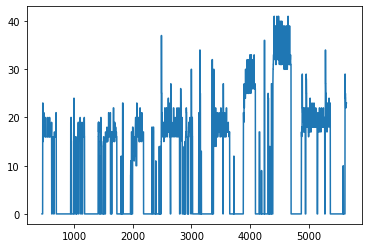

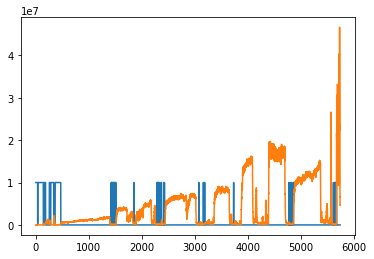

In [769]:

plt.plot(
    (power.max(1) < 1e5) * 1e7
)
plt.plot(
    power.max(1)
)

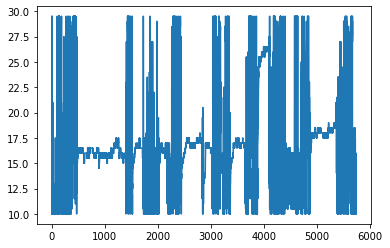

In [760]:
plt.plot(
    power.idxmax(1)
)

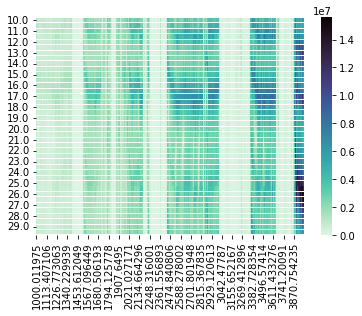

In [756]:
sns.heatmap(power.T, cmap='mako_r')

  0%|          | 0/25041 [00:00<?, ?it/s]

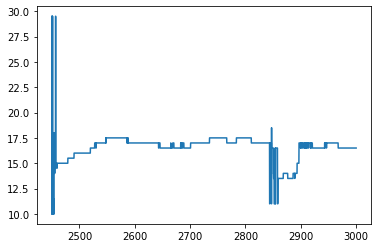

In [739]:
n_coefs = 3

rates = np.arange(10, 30, 0.5)
harms = np.arange(1, n_coefs + 1)

n_harms = harms.size
n_freqs = rates.size

e = 1e-1
e1 = 1 - e

freqs = 2 * np.pi * rates / 60
AAT = np.concatenate([
    np.eye(2 * n_coefs + 1)[None, ...] for i in range(n_freqs)
])
Ax = np.zeros((n_freqs, 2 * n_coefs + 1))
xs = np.c_[times, acc]

all_coefs = []

t0 = times[0]
for t, x in tqdm(xs):
    dt, t0 = t - t0, t 
    e1 = 1 - dt * e
    AAT *= e1
    Ax *= e1
    a = np.c_[
        np.ones((n_freqs, 1)), 
        np.sin(freqs[:, None] * harms[None, :] * t), 
        np.cos(freqs[:, None] * harms[None, :] * t)
    ]
    AAT += a[:, None, :] * a[:, :, None] 
    Ax += a * t * x
    all_coefs.append(np.linalg.solve(AAT, Ax))

all_coefs = np.array(all_coefs)

power = pd.DataFrame(
    np.linalg.norm(np.array(all_coefs)[:, :, 1:], axis=-1), 
    index=times, 
    columns=rates
)
plt.plot(
    power.idxmax(1)
)

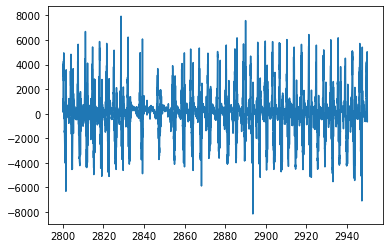

In [740]:
plt.plot(pd.Series(acc, index=times).loc[2800:2950])

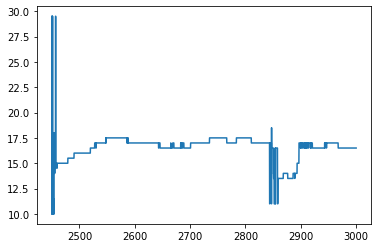

In [741]:
plt.plot(power.idxmax(1))

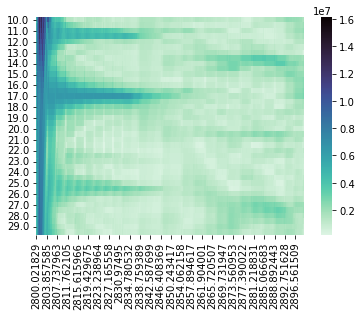

In [732]:
sns.heatmap(power.T, cmap='mako_r')

In [703]:
power.values.argsort(1)[:, 1]

array([35,  1,  1, ..., 33, 33, 33])

In [701]:
power.idxmax?

Signature: power.idxmax(axis: 'Axis' = 0, skipna: 'bool' = True) -> 'Series'
Docstring:
Return index of first occurrence of maximum over requested axis.

NA/null values are excluded.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    The axis to use. 0 or 'index' for row-wise, 1 or 'columns' for column-wise.
skipna : bool, default True
    Exclude NA/null values. If an entire row/column is NA, the result
    will be NA.

Returns
-------
Series
    Indexes of maxima along the specified axis.

Raises
------
ValueError
    * If the row/column is empty

See Also
--------
Series.idxmax : Return index of the maximum element.

Notes
-----
This method is the DataFrame version of ``ndarray.argmax``.

Examples
--------
Consider a dataset containing food consumption in Argentina.

>>> df = pd.DataFrame({'consumption': [10.51, 103.11, 55.48],
...                    'co2_emissions': [37.2, 19.66, 1712]},
...                    index=['Pork', 'Wheat Products', 'Beef'])

>>> 

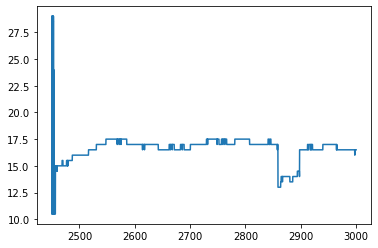

In [690]:
filt = np.ones(3)
spectrum = np.apply_along_axis(
    lambda m: np.convolve(m, filt, mode='same'), 
    axis=1, arr=power.values
)
plt.plot(
    times, 
    rates[spectrum.argmax(1)]
)

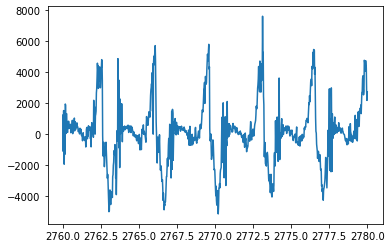

In [699]:
plt.plot(acc_x.loc[t-10:t+10])

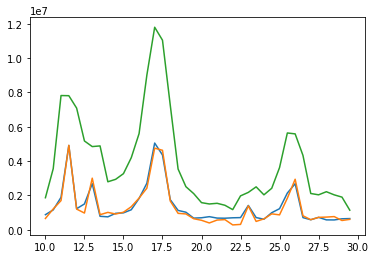

In [695]:
i = power.index.searchsorted(2775)
t = power.index[i]
plt.plot(power.loc[t])
i = power.index.searchsorted(2770)
t = power.index[i]
plt.plot(power.loc[t])
plt.plot(rates, spectrum[i])

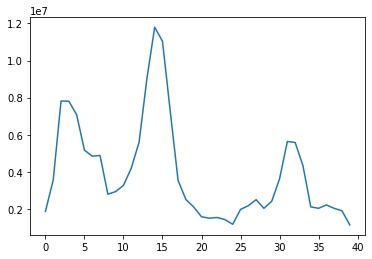

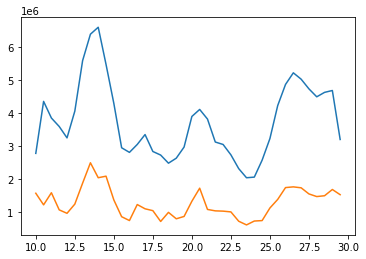

In [689]:
plt.plot(
    rates, 
    spectrum[19_000]
)
plt.plot(
    rates, 
    power.values[19_000]
)

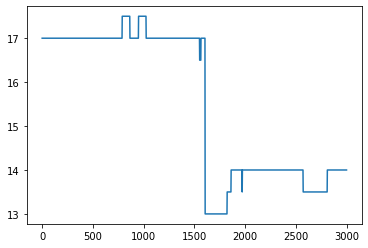

In [686]:

plt.plot(
    # times, 
    rates[spectrum[17_000:20_000].argmax(1)]
)

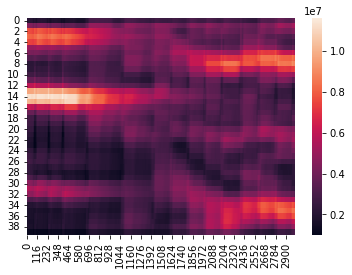

In [685]:
sns.heatmap(spectrum[17_000:20_000].T)

In [669]:
power.values.shape

(25041, 40)

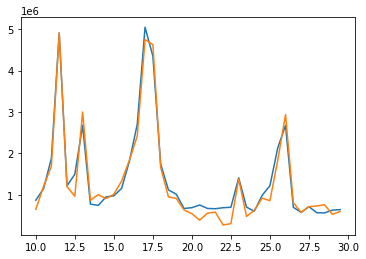

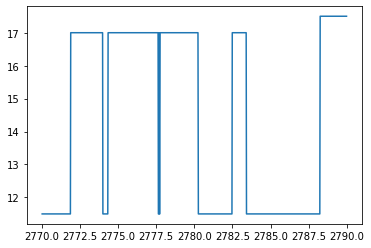

In [646]:
plt.plot(power.loc[2770:2790].idxmax(1))

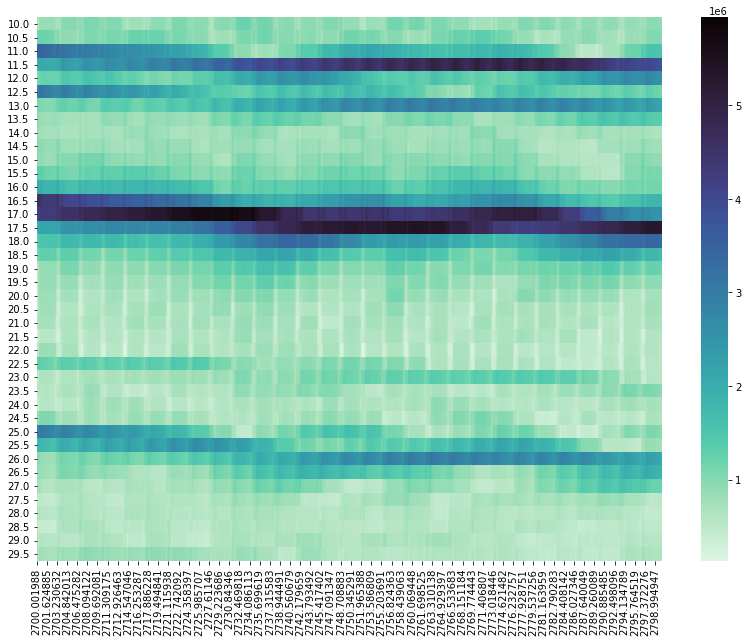

In [643]:
f, ax = plt.subplots(figsize=(14,10))
sns.heatmap(power.loc[2700:2800].T, cmap='mako_r')

In [374]:
def find_rate(pgram):
    peaks, data = signal.find_peaks(
        pgram / pgram.max(), 
        height=0.2
    )
    if len(peaks):
        return pgram.index[peaks[0]]
    else:
        return 0 

  0%|          | 0/574 [00:00<?, ?it/s]

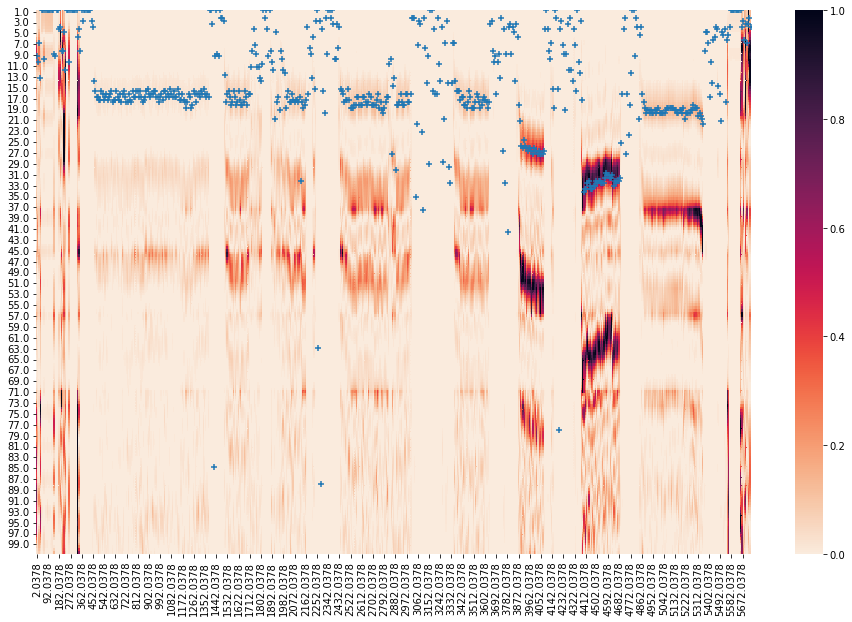

In [375]:
period = 10 
rates = np.arange(1, 101, 0.5)
freqs = rates * 2 * np.pi / 60

pgrams = {}
window = 10
times = np.arange(acc_x.index[0], acc_x.index[-1], window)

for t in tqdm(times):
    acc =  acc_x.loc[t:t+window]
    pgrams[t] = signal.lombscargle(
        acc.index, acc, freqs=freqs
    )
    
pgrams = pd.DataFrame(pgrams, index=rates).T
ls_rate = pgrams.T.apply(find_rate)
f, ax = plt.subplots(figsize=(16, 10))

n_pgrams = pgrams / pgrams.max()
n_pgrams.values[n_pgrams.values < 0.01] = 0 
sns.heatmap(n_pgrams.T, cmap='rocket_r')
plt.scatter(
    ls_rate.index * ls_rate.index.size / ls_rate.index[-1], 
    ls_rate * rates.size / rates[-1], 
    marker='+'
)

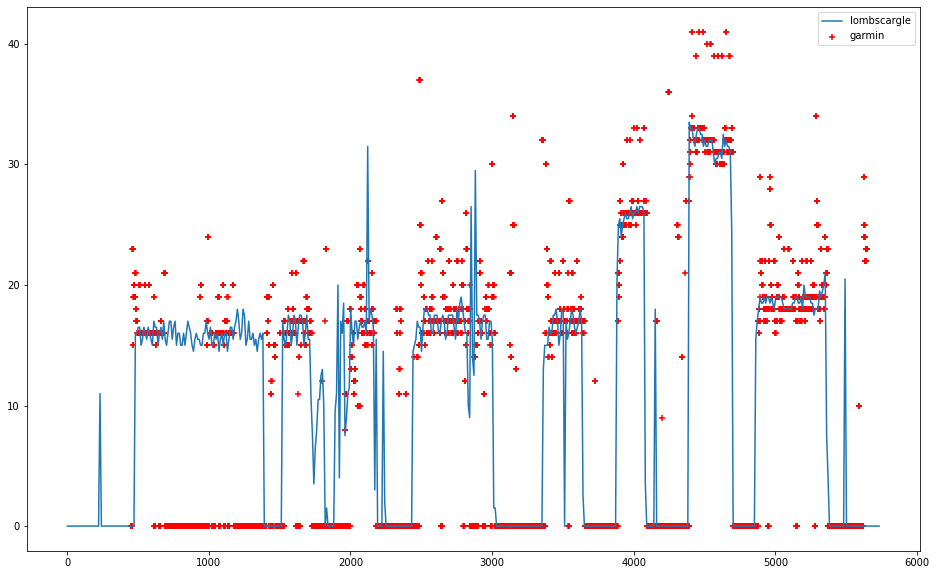

In [376]:
speed = valid_gps_data.Speed_over_ground

ispeed = pd.Series(
    np.interp(ls_rate.index, speed.index, speed),
    index=ls_rate.index
)
filt_rate = ls_rate.copy() 
filt_rate[ispeed < 5] = 0

f, ax = plt.subplots(figsize=(16, 10))

plt.plot(filt_rate, label='lombscargle')
plt.scatter(stroke_rates.index, stroke_rates, marker='+', c='r', label='garmin')
plt.legend()

Float64Index([31.5, 47.5], dtype='float64')

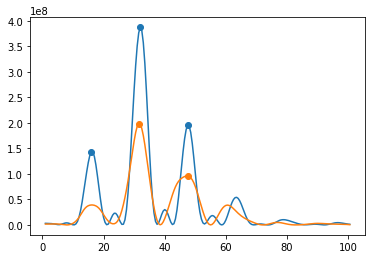

In [379]:
pgram =pgrams.loc[
    pgrams.index[filt_rate.loc[:3000].values.argmax() -1]
]
peaks, data = signal.find_peaks(
    pgram / pgram.max(), 
    height=0.2
)
rate_peaks = pgram.index[peaks]
plt.plot(pgram)
plt.scatter(rate_peaks, pgram.loc[rate_peaks])

pgram =pgrams.loc[
    # pgrams.index[200]
    filt_rate.loc[:3000].idxmax()
]
peaks, data = signal.find_peaks(
    pgram / pgram.max(), 
    height=0.2
)
rate_peaks = pgram.index[peaks]
plt.plot(pgram)
plt.scatter(rate_peaks, pgram.loc[rate_peaks])

rate_peaks 

In [150]:
def get_state(state, n_coefs=None):
    n_coefs = n_coefs or (len(state) - 2) // 2
    n, s = state[:2]
    cs = state[-n_coefs*2:-n_coefs]
    ds = state[-n_coefs:]
    return n, s, cs, ds

def make_state(n, s, cs, ds):
    return np.r_[n, s, cs, ds]

def transition(state, dt):
    n, s, cs, ds = get_state(state)
    n1, dx, v1, a1 = dynamics.rowing_stroke_model(
        dt, n, np.exp(s), 0, cs, ds
    )
    return make_state(n1, s, cs, ds)

def measurement(state):
    n, s, cs, ds = get_state(state)
    n1, dx, v1, a1 = dynamics.rowing_stroke_model(
        dt, n, np.exp(s), np.exp(v0), cs, ds
    )
    return np.r_[a1]

n_coefs = 3
n_state = 2 + n_coefs * 2
n_obs = 1
dt = 1

points = MSSP(
    n=n_state, alpha=1e-1, beta=2e0, kappa=0.
)

kf = UKF(
    n_state, n_obs, dt,
    measurement, 
    transition, 
    points=points
)


kf.R = np.eye(n_state) * 0.2
kf.Q = np.diag(observations.diff().var())

kf.x = np.zeros(n_state) 
kf.P = np.eye(n_state) * 1
kf.predict()



array([    0.        , -3373.13174802, -4293.33698405, ...,
        7228.1341095 ,  8502.92046614,  5747.14166828])

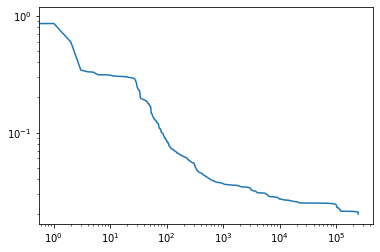

In [158]:
plt.loglog(np.sort(np.diff(acc_x.index))[::-1])

In [139]:
last_obs = observations.iloc[0]
last_time = last_obs.name 

kf_state = []
kf_cov = []

for timestamp, obs in tqdm(observations.iloc[1:].iterrows(), total=len(observations) - 1):
    dt, last_time = timestamp - last_time, timestamp
    kf.predict(dt)
    kf.update(obs.values)
    kf_state.append(kf.x.copy())
    kf_cov.append(kf.P.copy())

  0%|          | 0/3988 [00:00<?, ?it/s]

/home/matthew/venv/rowing/lib/python3.8/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (8,8)

In [24]:
def make_walk(size, alpha=0.1):
    walk = stats.norm.rvs(size=size).cumsum()
    walk -= pd.Series(walk).ewm(alpha=0.01).mean().values
    return walk


0.00014594350853602833

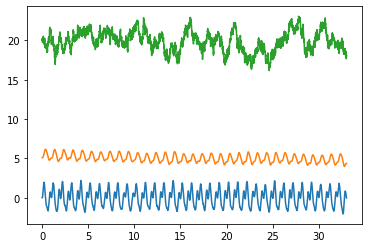

In [36]:
m = 5000
cs = (
    np.array([5, -3, -2]) / 5 
    + np.c_[make_walk(m), make_walk(m), make_walk(m)]/100
)
ds = (
    np.array([4, -1, -1]) / 5 
    + np.c_[make_walk(m), make_walk(m), make_walk(m)]/100
)
v0 = 5.
s = 20/60 + make_walk(m)/300

# cs = np.array([10, -3, -2]) * np.ones((m, 1)) / 5
# ds = np.array([0, -3, -1]) * np.ones((m, 1)) / 5
# s = 20 / 60 * np.ones(m)

v0 = 5.
ts = np.linspace(0, 100, m)
ns = np.r_[0, integrate.cumtrapz(s, ts)]

j = np.arange(1, 4)

a = (
    cs * np.cos(2 * np.pi * j * ns[:, None])
    + ds * np.sin(2 * np.pi * j * ns[:, None])
).sum(1)

inta = integrate.cumtrapz(a, ts)

v = np.r_[0, inta] + v0 - inta[0:ns.searchsorted(int(ns.max()))].mean()
x = np.r_[0, integrate.cumtrapz(v, ts)]

plt.plot(ns, a)
plt.plot(ns, v)
plt.plot(ns, s * 60)

v[:ns.searchsorted(int(ns.max()))].mean() - v0


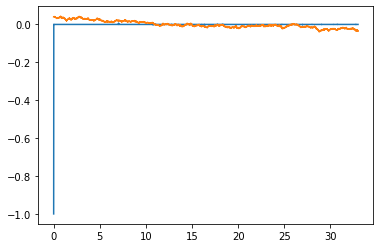

In [37]:
pred_dx = np.zeros_like(x)
pred_n = np.zeros_like(ns)
pred_v = np.zeros_like(v)
pred_a = np.zeros_like(a)
dt = ts[1] - ts[0]

# pred_n[0], pred_dx[0], pred_v[0], pred_a[0] = (
#     ns[0], 0., v[0], a[0]
# )

for j in range(len(ns)):
    preds = dynamics.rowing_stroke_model(
        dt, ns[j], s[j], v0, cs[j], ds[j]
    )
    pred_n[j], pred_dx[j], pred_v[j], pred_a[j] = preds

pred_x = pred_dx.cumsum()

# plt.plot(ns, x - pred_x)
plt.plot(ns, (a - pred_a) / (a + pred_a))
plt.plot(ns, (v - pred_v) / (v + pred_v))

In [38]:
def get_state(state, n_coefs=None):
    n_coefs = n_coefs or (len(state) - 4) // 2
    n, s, v0, x = state[:4]
    cs = state[-n_coefs*2:-n_coefs]
    ds = state[-n_coefs:]
    return n, s, v0, x, cs, ds

def make_state(n, s, v0, x, cs, ds):
    return np.r_[n, s, v0, x, cs, ds]

def transition(state, dt):
    n, s, v0, x, cs, ds = get_state(state)
    n1, dx, v1, a1 = dynamics.rowing_stroke_model(
        dt, n, np.exp(s), np.exp(v0), cs, ds
    )
    return make_state(n1, s, v0, x + dx, cs, ds)

def measurement(state):
    n, s, v0, x, cs, ds = get_state(state)
    n1, dx, v1, a1 = dynamics.rowing_stroke_model(
        dt, n, np.exp(s), np.exp(v0), cs, ds
    )
    return np.r_[x, a1]

In [40]:
true_states = np.c_[ns, s, np.full_like(s, v0), x, cs, ds]
observations = np.c_[x, a]

process_var = np.diff(true_states, axis=0).var(axis=0) + 1e-6
observe_var = np.diff(observations, axis=0).var(axis=0) + 1e-3

state = make_state(
    0., s[0], v[0], 0., cs[0], ds[0]
)
obs = measurement(state)

points = MSSP(
    n=len(state), alpha=1e-1, beta=2e0, kappa=0.
)

kf = UKF(
    len(state), len(obs), dt,
    measurement, 
    transition, 
    points=points
)

kf.R = np.diag(observe_var)
kf.Q = np.diag(process_var)

kf.x = state 
kf.P = np.eye(state.size) * 0.2
kf.predict()
kf.update(obs)
kf.x, kf.P.diagonal()

(array([ 2.32153081e-02,  3.32833114e-01,  4.18505427e+00,  1.52432666e-03,
         9.99215117e-01, -6.00750661e-01, -4.00694855e-01,  8.00501098e-01,
        -1.99944430e-01, -2.00170537e-01]),
 array([0.19800434, 0.20000953, 0.0190014 , 0.00119618, 0.19995837,
        0.19997401, 0.1999921 , 0.20009302, 0.20008118, 0.20006296]))

  0%|          | 0/5000 [00:00<?, ?it/s]

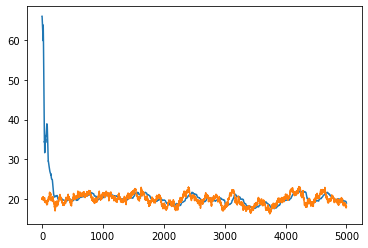

In [41]:
kf_state = []
kf_cov = []

kf.x = state * 0 + 0.1
kf.P = np.eye(state.size) * 0.2

for obs in tqdm(observations):
    kf.predict()
    kf.update(obs)
    kf_state.append(kf.x.copy())
    kf_cov.append(kf.P.copy())

k_n, k_s, k_v0, k_x, k_cs, k_ds = get_state(np.array(kf_state).T)

plt.plot(np.exp(k_s) * 60)
plt.plot(s * 60)

In [42]:
k_n1, k_dx, k_v, k_a = dynamics.rowing_stroke_model(
    dt, k_n[None, :], np.exp(k_s), np.exp(k_v0), k_cs, k_ds
)

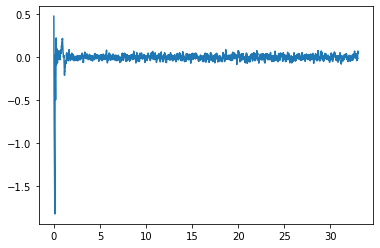

In [43]:
plt.plot(ns, k_a - a)

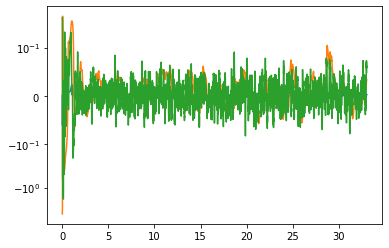

In [45]:
plt.plot(ns, k_x - x)
plt.plot(ns, k_v - v)
plt.plot(ns, k_a - a)
# plt.ylim(-1, 1)
plt.yscale("symlog", linthreshy=1e-1)

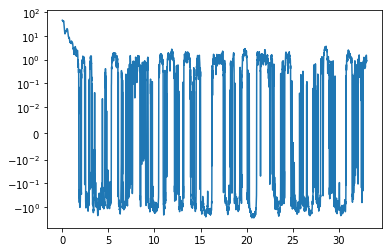

In [46]:
plt.plot(ns, np.exp(k_s) * 60 - s * 60)
plt.yscale("symlog", linthreshy=1e-2)

In [37]:
np.exp(k_s)

array([1.09932048, 1.10283894, 1.09893874, ..., 0.33337735, 0.3333755 ,
       0.33337417])

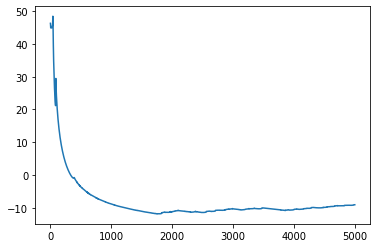

In [288]:
k_n, k_s, k_v0, k_x, k_cs, k_ds = get_state(np.array(kf_state).T)


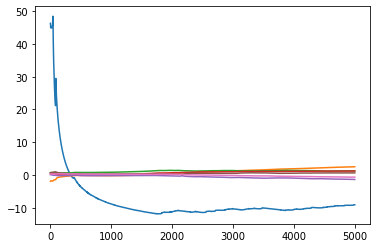

In [290]:
plt.plot(np.exp(k_s) * 60 - s * 60)

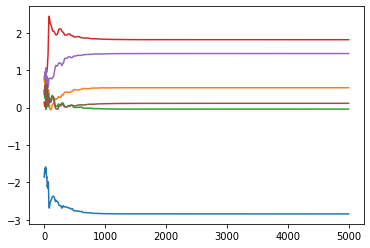

In [68]:
plt.plot(k_cs.T - cs)
plt.plot(k_ds.T - ds)

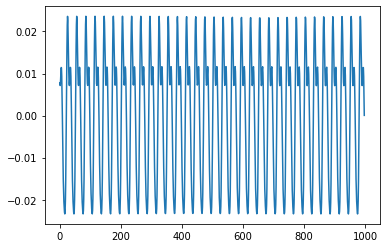

In [270]:
plt.plot(np.diff(np.diff(x)))

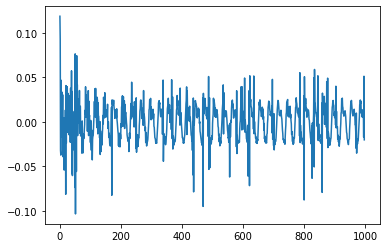

In [269]:
plt.plot(np.diff(np.diff(k_x)))

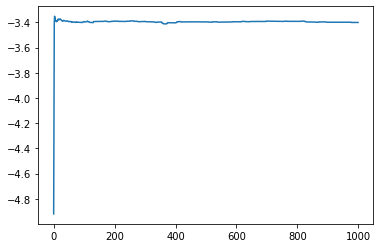

In [248]:
plt.plot(k_v0 - v0)

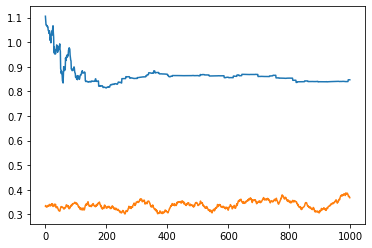

In [252]:
plt.plot(np.exp(k_s))
plt.plot(s)

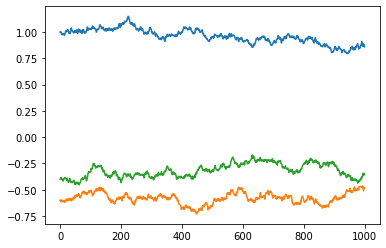

In [224]:
plt.plot(cs)

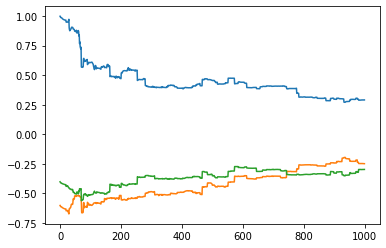

In [223]:
plt.plot(k_cs.T)

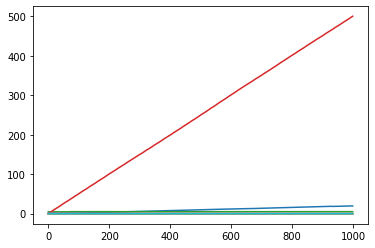

In [218]:
plt.plot(np.array(kf_state))

In [140]:
state = make_state(
    0., s[0], v[0], 0., cs[0], ds[0]
)
cov = np.eye(state.size)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])